In [17]:
import mie_py
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import glob
import json
import os
import pandas as pd
import pickle
import scipy
import seaborn as sns
from scipy.interpolate import interp1d
import scipy.io as sio
from scipy.optimize import curve_fit

rc = {
    "figure.figsize": (12,6),
    "xtick.major.size": 12.0,
    "xtick.minor.size": 8.0,
    "ytick.major.size": 12.0,
    "ytick.minor.size": 8.0,
    "axes.linewidth": 1.75,
    "xtick.color": '0',
    "ytick.color": '0',
    "axes.labelcolor": '0'
}

sns.set("notebook", style="ticks", palette='deep', rc=rc, font_scale=1.75)

%matplotlib inline


# Define functions

In [18]:

def gamma_dist(d,alpha,b,Constant = 1):
    r = 0.5*d
    n_r = Constant*(r**alpha)*np.exp(-1*b*r)
    return n_r
    
def load_MAT_FILE(mat_path):
    if os.path.exists(mat_path):
        print("loading the 3D mat from: {}".format(mat_path))
    else:
        print("{} not exists".format(mat_path))    
    
    matrix3D = sio.loadmat(mat_path)
    return matrix3D

def calcHG(mu, g):
    """Calculate the Henyey-Greenstein function for each voxel.
    The HG function is taken from: http://www.astro.umd.edu/~jph/HG_note.pdf
    """

    HG = (1 - g**2) / (1 + g**2 - 2*g*mu)**(3/2) / (4*np.pi)
    
    return HG

# load 3d data for Mie calculations

In [19]:
# mat_path = "BOMEX_128x128x100_500CCN_0000106200_pdfVARS.mat"
mat_path = "Eshkols data/BOMEX_128x128x100_50CCN_50m_0000008400_pdfVARS.mat"
matrix3D = load_MAT_FILE(mat_path)

#matrix3D.keys() = dict_keys(['B', 'C', '__version__', '__globals__', 'fails', 'DominPDFcoeff', '__header__', 'CldMtrx', 'alpha'])
CldMtrx = matrix3D['CldMtrx']# a binary cloud matrix that points out where there are cloud, 1- cloude, 0 - no cloud voxel
alpha = matrix3D['alpha']
B = matrix3D['B']
C = matrix3D['C']# modeled droplet concentration, units are [cm^-3]
fails = matrix3D['fails']

"""new parameters 30/7/2018, where:
matrix3D.keys() = dict_keys(['__header__', '__version__', '__globals__', 'B', 
           'BinMPhdata', 'C', 'CldMtrx', 'DominPDFcoeff', 'LWC', 'N', 'RE', 'alpha', 'fails', 'p', 'rd', 'rho'])"""

rd = matrix3D['rd'] #rd - the bins vector (micron)
BinMPhdata = matrix3D['BinMPhdata']#a 4D matrix of the droplet size bins (first 3 are spatial dimensions and the 4th is the 33 size bins) [1/um].
N = matrix3D['N']#number concentration of droplets per voxel (integral of BinMphdata over the 33 bins)  (cm^-3)


print("content information:")
print("CldMtrx shape is: {}".format(CldMtrx.shape))
print("alpha shape is: {}".format(alpha.shape))
print("B shape is: {}".format(B.shape))
print("C shape is: {}".format(C.shape))
print("fails shape is: {}".format(fails.shape))
print("rd shape is: {}".format(rd.shape))
print("BinMPhdata shape is: {}".format(BinMPhdata.shape))
print("N shape is: {}".format(N.shape))
print("total mediume voxels: {}\n".format(CldMtrx.size))
print("========================================================\n")
M = np.ones(alpha.shape)
print("In {} voxels there are no full fitted parameters.".format(fails.flatten().sum()))
print("There are {} voxels with cloud content".format(CldMtrx.flatten().sum()))
print("In {} voxels there is fitted alpha parameter".format(M.sum() - M[np.isnan(alpha)].flatten().sum()))
print("In {} voxels there is fitted B parameter".format(M.sum() - M[np.isnan(B)].flatten().sum()))
print("In {} voxels there is fitted C parameter".format(M.sum() - M[np.isnan(C)].flatten().sum()))

alpha_not_with_nan = np.nan_to_num(alpha)
B_not_with_nan = np.nan_to_num(B)
C_not_with_nan = np.nan_to_num(C)


loading the 3D mat from: Eshkols data/BOMEX_128x128x100_50CCN_50m_0000008400_pdfVARS.mat
content information:
CldMtrx shape is: (128, 128, 100)
alpha shape is: (128, 128, 100)
B shape is: (128, 128, 100)
C shape is: (128, 128, 100)
fails shape is: (128, 128, 100)
rd shape is: (33, 1)
BinMPhdata shape is: (128, 128, 100, 33)
N shape is: (128, 128, 100)
total mediume voxels: 1638400


In 3249 voxels there are no full fitted parameters.
There are 23535 voxels with cloud content
In 20286.0 voxels there is fitted alpha parameter
In 20286.0 voxels there is fitted B parameter
In 20286.0 voxels there is fitted C parameter


# Work on one voxel to test the units and some operations

Eshkols N = 16.27105712890625, tested (sanity check) N = 16.271055603701942
the total extinction cross section is 15943.296266683943[um^2]
the beta in this example is 0.25941428437829217[1/m]
the beta in this example is 0.25941426006150803[1/m]


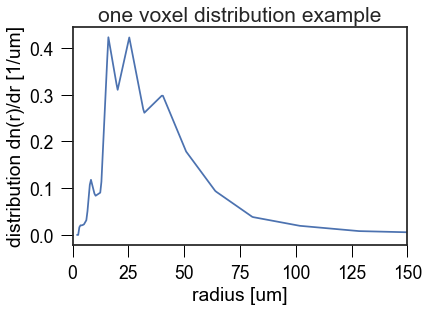

In [26]:
# from plt.plot(rd) - you can see that the bins are not linear
diameters = 2*np.squeeze(rd) # (microns)
min_diff = np.diff(np.squeeze(rd)).min()
interp_bins = int(np.ceil((rd.max() - rd.min())/min_diff))
r = np.linspace(rd.min(), rd.max(), interp_bins)

indxs = np.argwhere(CldMtrx > 0)# cloudy voxel indexes
# here, take for example one voxel with fitted parameters
example_vox_indx = indxs[1050]
DOPC = BinMPhdata[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2],:] # distribution of droplets consintration 
NC = N[example_vox_indx[0],example_vox_indx[1],example_vox_indx[2]] # number concentration of droplets
DOPC_interpulated = interp1d(np.squeeze(rd),DOPC)(r)

plt.plot(r,DOPC_interpulated)
plt.xlim([0 ,150])
plt.xlabel('radius [um]')
plt.ylabel('distribution dn(r)/dr [1/um]')
plt.title('one voxel distribution example')

# sanity check on the consintration
# NC_test = np.trapz(DOPC_interpulated,r, axis=0)
NC_test = np.trapz(DOPC,np.squeeze(rd), axis=0)
print("Eshkols N = {}, tested (sanity check) N = {}".format(NC,NC_test))

# test integrals:
# Generate a mie object
mc = mie_py.Bohren_Huffman()
real_ = 1.33*np.ones(diameters.shape)
imag_ = 1e-7*np.ones(diameters.shape)
y = real_ + imag_*1j
wavelengths = [0.650]# microns
refractive_index = y;

extinction_crosssection_d = np.zeros([diameters.size,len(wavelengths)])
#loop over all the sizes
for indx,d in enumerate(diameters):
    #input
    mc.parameters.diameter = d
    mc.parameters.wavelength = wavelengths[0]
    mc.parameters.refractive_index = refractive_index[indx]
    #output
    extinction_crosssection_d[indx,0] = mc.extinction_crosssection

scatt_cross_vector = extinction_crosssection_d[:,0]*DOPC
I1 = np.trapz(scatt_cross_vector,diameters, axis=0)
I2 = np.trapz(DOPC,diameters, axis=0)
ext_cross_section_effective = I1/I2
print('the total extinction cross section is {}[um^2]'.format(ext_cross_section_effective))
# if working with um umint the cross section will be with [um^2] units
# from [1/cm^3]->[1/m^3] do *1e6
# from [um^2]->[m^2] do *1e-12
beta_example = 1e6*NC*ext_cross_section_effective*1e-12 # in [1/m] umits
print('the beta in this example is {}[1/m]'.format(beta_example))

beta_example1 = 0.5*1e6*I1*1e-12 # in [1/m] umits
print('the beta in this example is {}[1/m]'.format(beta_example1))

In [250]:
print(rd.max())
print(rd.min())

3251.0
2.0


# Prepare Variables for Mie calculations and calculate cross sections per radius

In [22]:
# Generate a mie object
mc = mie_py.Bohren_Huffman()
diameters = 2*np.squeeze(rd) # (microns)
min_diff = np.diff(np.squeeze(rd)).min()
interp_bins = int(np.ceil((rd.max() - rd.min())/min_diff))
r = np.linspace(rd.min(), rd.max(), interp_bins)

# low_d = 0.1
# high_d = 100
# diameters = np.linspace(low_d,high_d,500)*1e-6
TotalSamples = 1

real_ = 1.33*np.ones(diameters.shape)
imag_ = 1e-7*np.ones(diameters.shape)
y = real_ + imag_*1j
# wavelengths = [650*1e-9];# in meter
wavelengths = [0.650]# microns
# if working with um umint the cross section will be with [um^2] units
# ---note: if you work with meters , don't forget to convert to [cm]
refractive_index = y;

# for phase function calculation
ang_num = 1000;
cor_ang_num = 4*ang_num - 3 #i don't know why but i found this inside the main code "https://github.com/hagne/mie-py/blob/master/mie_py/mie.py"
ang = np.linspace(0, np.pi * 2, cor_ang_num)
mc.parameters.no_of_angles = ang_num
theta = ang[ang < np.pi]
# define containers (for all the sizes)
scattering_crosssection_d = np.zeros([diameters.size,len(wavelengths)])
extinction_crosssection_d = np.zeros([diameters.size,len(wavelengths)])
        
phase_func_natural_d = np.zeros([diameters.size,cor_ang_num,len(wavelengths)])
Phase_Total = np.zeros([TotalSamples,cor_ang_num,len(wavelengths)])
NORM = np.zeros([TotalSamples,len(wavelengths)])

zers = np.zeros(cor_ang_num, dtype=np.float64)
dzers = pd.DataFrame(zers, index=ang,columns=['natural'])
dzers.index.name = 'angle'  
pf_counter = zers # print(mc.phase_func.natural.values.shape) = print(zers.shape)
normalization = zers

#loop over all the sizes
# meanwhile We are using one wavelengh 
for indx,d in enumerate(diameters):
    mc.parameters.diameter = d
    mc.parameters.wavelength = wavelengths[0]
    mc.parameters.refractive_index = refractive_index[indx]

    scattering_crosssection_d[indx,0] = mc.scattering_crosssection
    phase_func_natural_d[indx,:,0] = mc.phase_func.natural.values
    extinction_crosssection_d[indx,0] = mc.extinction_crosssection
    




# Loop over the medium voxsels to prepare 3D $\beta$ 

In [23]:
indxs = np.argwhere(CldMtrx > 0)# cloudy voxel indexes
beta3D = np.zeros(CldMtrx.shape)
Estimated_g_3D = np.zeros(CldMtrx.shape)
# meanwhile We are using one wavelengh
# loop over all cloudy voxels
for vox_indx in indxs:
#     to take gaama distributed voxels, use: if(not fails[vox_indx[0],vox_indx[1],vox_indx[2]]):
#     otherwise don't uncomment the line above

    DOPC = BinMPhdata[vox_indx[0],vox_indx[1],vox_indx[2],:] # distribution of droplets consintration [1/um]
    NC = N[vox_indx[0],vox_indx[1],vox_indx[2]] # number concentration of droplets [1/cm^3]
    # to convert NC to meters, do 1e6*NC
    # to convert DOPC to [1/m], do 1e-12*DOPC
    
    scatt_cross_vector = extinction_crosssection_d[:,0]*DOPC
    I1 = np.trapz(scatt_cross_vector,diameters, axis=0)
    I2 = np.trapz(DOPC,diameters, axis=0)
    ext_cross_section_effective = I1/I2 # the total extinction cross section (ext_cross_section_effective) [um^2]
    # print('the total extinction cross section is {}[um^2]'.format(ext_cross_section_effective))
    
    # from [1/cm^3]->[1/m^3] do *1e6
    # from [um^2]->[m^2] do *1e-12
    beta3D[vox_indx[0],vox_indx[1],vox_indx[2]] = 1e6*NC*ext_cross_section_effective*1e-12 # in [1/m] umits
    
    # calculate phase function:
    p = phase_func_natural_d[:,:,0] # p.shape = (diameters.size,3997,) , scatt_cross_vector.size = diameters.size
    trp_toint = p.T*scatt_cross_vector
    trp_int = np.trapz(trp_toint,diameters,axis=1) 
    trp_normalization = 2*np.pi*np.trapz(trp_int[ang < np.pi]*np.sin(theta),theta,axis=0) 
    
    Phase_Total = trp_int/trp_normalization
    v_natural = Phase_Total[ang < np.pi] # to ensure integration from 0 to pi

    h = (v_natural*np.sin(theta))*(2*np.pi/cor_ang_num)
    # print("sanity check: integral of the Phase function over sphere {}".format(2*np.pi*h.sum()) )
    
    # calculate g:
    ge = np.trapz(v_natural*np.cos(theta)*2*np.pi*np.sin(theta),theta)
    Estimated_g_3D[vox_indx[0],vox_indx[1],vox_indx[2]] = ge
    # print('estimated g = {}'.format(ge))
    
#         for gamma distribution i used: n_r = gamma_dist(1e6*diameters,alpha_,b,Constant = 1)
        
   

# plt.figure(figsize=(12, 12))
# plt.semilogy(ang,Phase_Total)
# plt.xlabel('angle [rad]')
# plt.ylabel('angular distribution [1/st]')
# plt.title('Phase function in some voxel')


# plt.plot(diameters*0.5e6,n_d)
# plt.xlabel('radius [um]')
# plt.ylabel('distribution')
# plt.title('one voxel distribution example')

# # here, take for example one voxel with fitted parameters -
# # - calculate scattering cross section and pahes function
# for idw,w in enumerate(wavelengths):
#     scatt_cross_vector = scattering_crosssection_d[:,idw]*n_d
#     I1 = np.trapz(scatt_cross_vector, x = diameters, axis=0)
#     I2 = np.trapz(n_d, x = diameters, axis=0)
#     scatt_cross_section_effective = I1/I2
#     print('the total scatterin cross section is {}'.format(scatt_cross_section_effective))

#     beta_example = consintration*scatt_cross_section_effective
#     print('the beta in this example is {}'.format(beta_example))
    
#     p = phase_func_natural_d[:,:,idw] # p.shape = (31,3997,) , scatt_cross_vector.shape = 31
#     trp_toint = p.T*scatt_cross_vector
#     trp_int = np.trapz(trp_toint,diameters,axis=1) 
#     trp_normalization = 2*np.pi*np.trapz(trp_int[ang < np.pi]*np.sin(theta),theta,axis=0) 
    
#     theta = ang[ang < np.pi]
#     Phase_Total = trp_int/trp_normalization
#     v_natural = Phase_Total[ang < np.pi] # to ensure integration from 0 to pi

#     h = (v_natural*np.sin(theta))*(2*np.pi/cor_ang_num)
#     print("sanity check: integral of the Phase function over sphere {}".format(2*np.pi*h.sum()) )

#     fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
#     axs.plot(ang, Phase_Total)
#     axs.grid(False)
#     axs.set_title('average phase function')
    
# # calculate g:
# ge = np.trapz(v_natural*np.cos(theta)*2*np.pi*np.sin(theta),theta)
# print('estimated g = {}'.format(ge))

sanity check: integral of the Phase function over sphere 0.9997501632389701
estimated g = 0.8621644698578653
sanity check: integral of the Phase function over sphere 0.999750154754109
estimated g = 0.8689227476351765
sanity check: integral of the Phase function over sphere 0.9997501569492255
estimated g = 0.87172468653004
sanity check: integral of the Phase function over sphere 0.9997501570898615
estimated g = 0.877558411643222
sanity check: integral of the Phase function over sphere 0.9997501562295895
estimated g = 0.8775622222866561
sanity check: integral of the Phase function over sphere 0.9997501829963669
estimated g = 0.8512466459907286
sanity check: integral of the Phase function over sphere 0.9997501787988331
estimated g = 0.8565588463233983
sanity check: integral of the Phase function over sphere 0.9997501700381954
estimated g = 0.864696149245473
sanity check: integral of the Phase function over sphere 0.9997501602569908
estimated g = 0.8742203476060131
sanity check: integral o

sanity check: integral of the Phase function over sphere 0.9997501443268831
estimated g = 0.8741895584330748
sanity check: integral of the Phase function over sphere 0.9997501385726173
estimated g = 0.8758287816063022
sanity check: integral of the Phase function over sphere 0.9997501396457577
estimated g = 0.875951173641608
sanity check: integral of the Phase function over sphere 0.9997501206956099
estimated g = 0.8752836091978324
sanity check: integral of the Phase function over sphere 0.999750124158906
estimated g = 0.8764933799260497
sanity check: integral of the Phase function over sphere 0.9997501281907144
estimated g = 0.8770222655635465
sanity check: integral of the Phase function over sphere 0.9997500626873405
estimated g = 0.866116100020657
sanity check: integral of the Phase function over sphere 0.9997500522191372
estimated g = 0.8672546902793608
sanity check: integral of the Phase function over sphere 0.9997500603839948
estimated g = 0.8694543324638012
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997501080633372
estimated g = 0.8730539280422404
sanity check: integral of the Phase function over sphere 0.9997500864861476
estimated g = 0.8756224192549376
sanity check: integral of the Phase function over sphere 0.9997500938801402
estimated g = 0.8771063040050603
sanity check: integral of the Phase function over sphere 0.9997501003052771
estimated g = 0.8783989973490733
sanity check: integral of the Phase function over sphere 0.9997501394425415
estimated g = 0.8785874999789652
sanity check: integral of the Phase function over sphere 0.999750115252833
estimated g = 0.8732294615533253
sanity check: integral of the Phase function over sphere 0.9997501193199427
estimated g = 0.8746575037986082
sanity check: integral of the Phase function over sphere 0.9997501021568694
estimated g = 0.8772382165035403
sanity check: integral of the Phase function over sphere 0.9997501353220942
estimated g = 0.8778025949390127
sanity check: integr

sanity check: integral of the Phase function over sphere 0.999750142011753
estimated g = 0.8751861439170997
sanity check: integral of the Phase function over sphere 0.9997501402601872
estimated g = 0.8769691511544624
sanity check: integral of the Phase function over sphere 0.9997501400926516
estimated g = 0.8772927156482758
sanity check: integral of the Phase function over sphere 0.999750100136522
estimated g = 0.8771432269335686
sanity check: integral of the Phase function over sphere 0.9997501306271804
estimated g = 0.8764655461056536
sanity check: integral of the Phase function over sphere 0.999750152202932
estimated g = 0.8777077132011969
sanity check: integral of the Phase function over sphere 0.9997501826137584
estimated g = 0.8391880992701776
sanity check: integral of the Phase function over sphere 0.9997501056731379
estimated g = 0.8472728382308226
sanity check: integral of the Phase function over sphere 0.9997501006614142
estimated g = 0.8541251733558199
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997500904672952
estimated g = 0.8589844527200361
sanity check: integral of the Phase function over sphere 0.9997500976470692
estimated g = 0.8675783881980966
sanity check: integral of the Phase function over sphere 0.9997500866765591
estimated g = 0.8722853085621392
sanity check: integral of the Phase function over sphere 0.9997500721132099
estimated g = 0.8702840610031035
sanity check: integral of the Phase function over sphere 0.9997501084593218
estimated g = 0.8725848801700471
sanity check: integral of the Phase function over sphere 0.9997501176852684
estimated g = 0.8750134041739173
sanity check: integral of the Phase function over sphere 0.999750123505139
estimated g = 0.875532967234568
sanity check: integral of the Phase function over sphere 0.9997501259778353
estimated g = 0.8784219383747567
sanity check: integral of the Phase function over sphere 0.9997501898525756
estimated g = 0.8777617554356478
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997501431629506
estimated g = 0.8735183285953622
sanity check: integral of the Phase function over sphere 0.999750152661775
estimated g = 0.8772224583323447
sanity check: integral of the Phase function over sphere 0.9997501279435208
estimated g = 0.8771214151466351
sanity check: integral of the Phase function over sphere 0.9997500372651923
estimated g = 0.8675369854346715
sanity check: integral of the Phase function over sphere 0.9997500378158576
estimated g = 0.8652813568470086
sanity check: integral of the Phase function over sphere 0.9997500212148427
estimated g = 0.8690485863453555
sanity check: integral of the Phase function over sphere 0.9997500725623134
estimated g = 0.8723654972059475
sanity check: integral of the Phase function over sphere 0.9997500963607852
estimated g = 0.8638964922192263
sanity check: integral of the Phase function over sphere 0.9997501365273388
estimated g = 0.8581510222399215
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997500516419725
estimated g = 0.8595954091360061
sanity check: integral of the Phase function over sphere 0.9997500819468169
estimated g = 0.8719172016247018
sanity check: integral of the Phase function over sphere 0.9997500728542951
estimated g = 0.8724606204098118
sanity check: integral of the Phase function over sphere 0.9997500806781654
estimated g = 0.869795782691039
sanity check: integral of the Phase function over sphere 0.9997500750488124
estimated g = 0.8727363916376017
sanity check: integral of the Phase function over sphere 0.9997501270355382
estimated g = 0.8758050725309753
sanity check: integral of the Phase function over sphere 0.9997501317965689
estimated g = 0.8756891969290205
sanity check: integral of the Phase function over sphere 0.9997501008525045
estimated g = 0.8742289290467606
sanity check: integral of the Phase function over sphere 0.9997501331985499
estimated g = 0.8774062097086801
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501916655211
estimated g = 0.8774199725042117
sanity check: integral of the Phase function over sphere 0.999750188503691
estimated g = 0.831940158651952
sanity check: integral of the Phase function over sphere 0.9997502021919185
estimated g = 0.8331460368884528
sanity check: integral of the Phase function over sphere 0.9997501988304096
estimated g = 0.8389318195651083
sanity check: integral of the Phase function over sphere 0.9997501981352379
estimated g = 0.8387890520201091
sanity check: integral of the Phase function over sphere 0.9997501962411139
estimated g = 0.8471955301882813
sanity check: integral of the Phase function over sphere 0.9997501691248387
estimated g = 0.862978483060955
sanity check: integral of the Phase function over sphere 0.9997501588008003
estimated g = 0.8683402010664703
sanity check: integral of the Phase function over sphere 0.9997501576089847
estimated g = 0.8584398319740499
sanity check: integral

estimated g = 0.8748453720510583
sanity check: integral of the Phase function over sphere 0.9997501640436675
estimated g = 0.87622391334182
sanity check: integral of the Phase function over sphere 0.9997501555715078
estimated g = 0.8777065981731421
sanity check: integral of the Phase function over sphere 0.9997501513571636
estimated g = 0.8779721176502521
sanity check: integral of the Phase function over sphere 0.999750170534628
estimated g = 0.878354846604686
sanity check: integral of the Phase function over sphere 0.9997501210488982
estimated g = 0.8606343177823458
sanity check: integral of the Phase function over sphere 0.9997501374075524
estimated g = 0.8686325397906749
sanity check: integral of the Phase function over sphere 0.9997501423801834
estimated g = 0.8729379767320554
sanity check: integral of the Phase function over sphere 0.9997501443585686
estimated g = 0.875193206796059
sanity check: integral of the Phase function over sphere 0.9997501446007363
estimated g = 0.87592628

sanity check: integral of the Phase function over sphere 0.9997499916241627
estimated g = 0.8733432247366231
sanity check: integral of the Phase function over sphere 0.9997501209631949
estimated g = 0.8754948320724427
sanity check: integral of the Phase function over sphere 0.9997500662568124
estimated g = 0.8736567491722934
sanity check: integral of the Phase function over sphere 0.9997500947031028
estimated g = 0.8747363288408813
sanity check: integral of the Phase function over sphere 0.9997500374411806
estimated g = 0.8745325653876256
sanity check: integral of the Phase function over sphere 0.9997500167757067
estimated g = 0.8725458973529399
sanity check: integral of the Phase function over sphere 0.9997501313970608
estimated g = 0.8619886317584726
sanity check: integral of the Phase function over sphere 0.999750107667326
estimated g = 0.8683670697461886
sanity check: integral of the Phase function over sphere 0.9997500885284838
estimated g = 0.8690242008789956
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501189998309
estimated g = 0.8542048913637803
sanity check: integral of the Phase function over sphere 0.9997499889430845
estimated g = 0.8696493569158508
sanity check: integral of the Phase function over sphere 0.9997500616909616
estimated g = 0.8560676318787094
sanity check: integral of the Phase function over sphere 0.9997501694623029
estimated g = 0.8661649969752938
sanity check: integral of the Phase function over sphere 0.9997501767956507
estimated g = 0.8716477517994744
sanity check: integral of the Phase function over sphere 0.9997501417118051
estimated g = 0.8739715150517856
sanity check: integral of the Phase function over sphere 0.999750117811407
estimated g = 0.8723997790654913
sanity check: integral of the Phase function over sphere 0.9997501225645954
estimated g = 0.8713530958241722
sanity check: integral of the Phase function over sphere 0.9997501316722138
estimated g = 0.8751483143115087
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501170835643
estimated g = 0.873075228476595
sanity check: integral of the Phase function over sphere 0.9997501150958377
estimated g = 0.8743728809007796
sanity check: integral of the Phase function over sphere 0.9997501169980855
estimated g = 0.8751519251629644
sanity check: integral of the Phase function over sphere 0.9997501230290026
estimated g = 0.8759078924427137
sanity check: integral of the Phase function over sphere 0.9997501355328144
estimated g = 0.8769553438318398
sanity check: integral of the Phase function over sphere 0.999750115194677
estimated g = 0.8768752702162512
sanity check: integral of the Phase function over sphere 0.9997501077102114
estimated g = 0.8777516011195513
sanity check: integral of the Phase function over sphere 0.999750158305947
estimated g = 0.8768969684466227
sanity check: integral of the Phase function over sphere 0.9997501236409614
estimated g = 0.8754036647344104
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997501457915902
estimated g = 0.8774624417001257
sanity check: integral of the Phase function over sphere 0.9997501716846702
estimated g = 0.8774258655097085
sanity check: integral of the Phase function over sphere 0.9997499884089325
estimated g = 0.8668369454196554
sanity check: integral of the Phase function over sphere 0.9997499623669304
estimated g = 0.8687380293817859
sanity check: integral of the Phase function over sphere 0.9997499742804732
estimated g = 0.8720685853516883
sanity check: integral of the Phase function over sphere 0.9997500282014022
estimated g = 0.8744202786099661
sanity check: integral of the Phase function over sphere 0.9997500445817447
estimated g = 0.8743996164331932
sanity check: integral of the Phase function over sphere 0.9997500518598074
estimated g = 0.8737759777675047
sanity check: integral of the Phase function over sphere 0.9997501111433322
estimated g = 0.8755523785725473
sanity check: integ

estimated g = 0.8742300266329796
sanity check: integral of the Phase function over sphere 0.9997501110314114
estimated g = 0.8758257977814077
sanity check: integral of the Phase function over sphere 0.9997501336159587
estimated g = 0.876808608328617
sanity check: integral of the Phase function over sphere 0.9997501498272879
estimated g = 0.8774543102859639
sanity check: integral of the Phase function over sphere 0.9997501841016546
estimated g = 0.8779081536921155
sanity check: integral of the Phase function over sphere 0.9997499847270527
estimated g = 0.8689503382116373
sanity check: integral of the Phase function over sphere 0.9997499707183626
estimated g = 0.8698746267483755
sanity check: integral of the Phase function over sphere 0.9997501086524953
estimated g = 0.8756050249650609
sanity check: integral of the Phase function over sphere 0.9997501178425676
estimated g = 0.875804793951676
sanity check: integral of the Phase function over sphere 0.9997501272144061
estimated g = 0.87562

sanity check: integral of the Phase function over sphere 0.9997501132278915
estimated g = 0.8728718831422358
sanity check: integral of the Phase function over sphere 0.9997501152678014
estimated g = 0.8744119857164832
sanity check: integral of the Phase function over sphere 0.9997501278745567
estimated g = 0.8773050849898943
sanity check: integral of the Phase function over sphere 0.999750128610019
estimated g = 0.8771094377875003
sanity check: integral of the Phase function over sphere 0.9997500640659363
estimated g = 0.8610822922138915
sanity check: integral of the Phase function over sphere 0.9997500352121742
estimated g = 0.8642229502126144
sanity check: integral of the Phase function over sphere 0.9997500162174162
estimated g = 0.8717000136163718
sanity check: integral of the Phase function over sphere 0.9997500327544488
estimated g = 0.8727207127510419
sanity check: integral of the Phase function over sphere 0.9997500485351358
estimated g = 0.87091871235071
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997500037848097
estimated g = 0.8732288752010268
sanity check: integral of the Phase function over sphere 0.9997500556838661
estimated g = 0.8745341703877598
sanity check: integral of the Phase function over sphere 0.9997500779316991
estimated g = 0.8748766848321858
sanity check: integral of the Phase function over sphere 0.9997500239684328
estimated g = 0.8733107748116175
sanity check: integral of the Phase function over sphere 0.9997500458132343
estimated g = 0.874103174883531
sanity check: integral of the Phase function over sphere 0.9997500785378023
estimated g = 0.8750740585417498
sanity check: integral of the Phase function over sphere 0.999750083995746
estimated g = 0.8751037841983528
sanity check: integral of the Phase function over sphere 0.9997501007559273
estimated g = 0.8753822624108093
sanity check: integral of the Phase function over sphere 0.9997501695106018
estimated g = 0.8777014063635917
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997500152167389
estimated g = 0.8647792781514195
sanity check: integral of the Phase function over sphere 0.999750102345704
estimated g = 0.8614888196759657
sanity check: integral of the Phase function over sphere 0.9997499946075337
estimated g = 0.8708872582128567
sanity check: integral of the Phase function over sphere 0.9997500186984671
estimated g = 0.8708588454765616
sanity check: integral of the Phase function over sphere 0.9997500565910756
estimated g = 0.8716688329051475
sanity check: integral of the Phase function over sphere 0.999750117340005
estimated g = 0.8709330943933623
sanity check: integral of the Phase function over sphere 0.9997501172651787
estimated g = 0.871311961359773
sanity check: integral of the Phase function over sphere 0.9997501115434162
estimated g = 0.8744516889990513
sanity check: integral of the Phase function over sphere 0.9997501212788503
estimated g = 0.8768783810238318
sanity check: integral

estimated g = 0.8680735771253468
sanity check: integral of the Phase function over sphere 0.9997501244952096
estimated g = 0.871073946157379
sanity check: integral of the Phase function over sphere 0.9997501333650162
estimated g = 0.872572557389676
sanity check: integral of the Phase function over sphere 0.999750133999186
estimated g = 0.8716039712923421
sanity check: integral of the Phase function over sphere 0.9997501348274483
estimated g = 0.8728200099052528
sanity check: integral of the Phase function over sphere 0.9997501411366694
estimated g = 0.8760998708139149
sanity check: integral of the Phase function over sphere 0.9997501548707307
estimated g = 0.8773259414165937
sanity check: integral of the Phase function over sphere 0.9997501460909656
estimated g = 0.8773860255281494
sanity check: integral of the Phase function over sphere 0.9997501125281624
estimated g = 0.8718412393892352
sanity check: integral of the Phase function over sphere 0.9997501131519217
estimated g = 0.871708

sanity check: integral of the Phase function over sphere 0.9997500940930899
estimated g = 0.8622495585906638
sanity check: integral of the Phase function over sphere 0.9997500416655092
estimated g = 0.8631584826274459
sanity check: integral of the Phase function over sphere 0.9997501254280137
estimated g = 0.8686148028126657
sanity check: integral of the Phase function over sphere 0.9997501285125344
estimated g = 0.86450263533298
sanity check: integral of the Phase function over sphere 0.9997501088986608
estimated g = 0.8706120816346681
sanity check: integral of the Phase function over sphere 0.9997501158716056
estimated g = 0.8748264812756084
sanity check: integral of the Phase function over sphere 0.9997501291207379
estimated g = 0.8770944788691867
sanity check: integral of the Phase function over sphere 0.999750030050117
estimated g = 0.8667997314958551
sanity check: integral of the Phase function over sphere 0.9997499948633193
estimated g = 0.865473153901598
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.9997501520527281
estimated g = 0.8545322061044882
sanity check: integral of the Phase function over sphere 0.9997501404605801
estimated g = 0.8592397569241439
sanity check: integral of the Phase function over sphere 0.99975014153151
estimated g = 0.8633748483934146
sanity check: integral of the Phase function over sphere 0.999750142371563
estimated g = 0.8677818512544647
sanity check: integral of the Phase function over sphere 0.9997501452761831
estimated g = 0.8718260803149811
sanity check: integral of the Phase function over sphere 0.9997501410918321
estimated g = 0.8759919403734462
sanity check: integral of the Phase function over sphere 0.9997501432316444
estimated g = 0.8772468121046736
sanity check: integral of the Phase function over sphere 0.9997501435708809
estimated g = 0.8766726609166512
sanity check: integral of the Phase function over sphere 0.9997501733595673
estimated g = 0.8774566353813045
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997501378289041
estimated g = 0.8635756575838379
sanity check: integral of the Phase function over sphere 0.9997501364910639
estimated g = 0.8692722962417057
sanity check: integral of the Phase function over sphere 0.9997501276586613
estimated g = 0.8711743097508529
sanity check: integral of the Phase function over sphere 0.9997501310930547
estimated g = 0.8735309780313709
sanity check: integral of the Phase function over sphere 0.9997501345146385
estimated g = 0.8762468538873801
sanity check: integral of the Phase function over sphere 0.9997501374620332
estimated g = 0.8766816181396957
sanity check: integral of the Phase function over sphere 0.9997501447522031
estimated g = 0.8772264717145214
sanity check: integral of the Phase function over sphere 0.9997501594904185
estimated g = 0.8775967880795459
sanity check: integral of the Phase function over sphere 0.9997501257301057
estimated g = 0.8615270507269214
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997501692190393
estimated g = 0.8524103236662949
sanity check: integral of the Phase function over sphere 0.9997501485203051
estimated g = 0.8660859195960233
sanity check: integral of the Phase function over sphere 0.9997501500965938
estimated g = 0.8724727470846485
sanity check: integral of the Phase function over sphere 0.9997501708065311
estimated g = 0.8540331664588942
sanity check: integral of the Phase function over sphere 0.9997501422713173
estimated g = 0.8579164919747789
sanity check: integral of the Phase function over sphere 0.9997501325974765
estimated g = 0.8669174698961112
sanity check: integral of the Phase function over sphere 0.9997501321367231
estimated g = 0.8726406196439314
sanity check: integral of the Phase function over sphere 0.9997501405961771
estimated g = 0.8766933103147561
sanity check: integral of the Phase function over sphere 0.9997501665061082
estimated g = 0.877278240238217
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997500157038001
estimated g = 0.869794552225502
sanity check: integral of the Phase function over sphere 0.9997499748651165
estimated g = 0.8732498374200672
sanity check: integral of the Phase function over sphere 0.999749988164881
estimated g = 0.8729461062051229
sanity check: integral of the Phase function over sphere 0.9997500917177216
estimated g = 0.8610556448836557
sanity check: integral of the Phase function over sphere 0.9997499744545885
estimated g = 0.8701369667576317
sanity check: integral of the Phase function over sphere 0.999749974076658
estimated g = 0.8717874248416245
sanity check: integral of the Phase function over sphere 0.9997499804532907
estimated g = 0.8729342764090587
sanity check: integral of the Phase function over sphere 0.9997500209605098
estimated g = 0.8724144820683032
sanity check: integral of the Phase function over sphere 0.99975014494218
estimated g = 0.8765450609189178
sanity check: integral o

estimated g = 0.8727124850985829
sanity check: integral of the Phase function over sphere 0.9997501312001288
estimated g = 0.8746994350937745
sanity check: integral of the Phase function over sphere 0.9997501463821304
estimated g = 0.8766053967005663
sanity check: integral of the Phase function over sphere 0.9997501526349123
estimated g = 0.8766386342456366
sanity check: integral of the Phase function over sphere 0.9997501630557777
estimated g = 0.8774842581070198
sanity check: integral of the Phase function over sphere 0.9997501508260292
estimated g = 0.8557326168290851
sanity check: integral of the Phase function over sphere 0.9997499868918371
estimated g = 0.864012683634666
sanity check: integral of the Phase function over sphere 0.9997499469035575
estimated g = 0.8722133723628966
sanity check: integral of the Phase function over sphere 0.9997499714176694
estimated g = 0.8714505247787885
sanity check: integral of the Phase function over sphere 0.9997499923964817
estimated g = 0.8728

sanity check: integral of the Phase function over sphere 0.9997501254884456
estimated g = 0.8774799708095571
sanity check: integral of the Phase function over sphere 0.9997501377871963
estimated g = 0.8739464640792198
sanity check: integral of the Phase function over sphere 0.9997501217242071
estimated g = 0.8740089050881632
sanity check: integral of the Phase function over sphere 0.9997500608113473
estimated g = 0.8655209851156382
sanity check: integral of the Phase function over sphere 0.9997501478546104
estimated g = 0.8584642608386
sanity check: integral of the Phase function over sphere 0.999749976752353
estimated g = 0.8683623923220432
sanity check: integral of the Phase function over sphere 0.9997499915682718
estimated g = 0.8711487472141971
sanity check: integral of the Phase function over sphere 0.9997501410329895
estimated g = 0.8640743467757919
sanity check: integral of the Phase function over sphere 0.9997499664294283
estimated g = 0.8679251554438195
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.9997501916073386
estimated g = 0.8313108961501889
sanity check: integral of the Phase function over sphere 0.9997501887057081
estimated g = 0.8351293714593944
sanity check: integral of the Phase function over sphere 0.999750180596773
estimated g = 0.8404584810280006
sanity check: integral of the Phase function over sphere 0.9997501756912092
estimated g = 0.8455838769471737
sanity check: integral of the Phase function over sphere 0.999750175407163
estimated g = 0.8471646096135071
sanity check: integral of the Phase function over sphere 0.9997501760500194
estimated g = 0.8490820116959541
sanity check: integral of the Phase function over sphere 0.9997501631302028
estimated g = 0.8539231325879385
sanity check: integral of the Phase function over sphere 0.9997501608693259
estimated g = 0.8550635617510431
sanity check: integral of the Phase function over sphere 0.9997501568172648
estimated g = 0.8534725479468167
sanity check: integra

sanity check: integral of the Phase function over sphere 0.999750144662653
estimated g = 0.8742779594104862
sanity check: integral of the Phase function over sphere 0.9997501408883896
estimated g = 0.8748080359486281
sanity check: integral of the Phase function over sphere 0.9997501426492897
estimated g = 0.87558988613402
sanity check: integral of the Phase function over sphere 0.9997501471265551
estimated g = 0.8651559535973548
sanity check: integral of the Phase function over sphere 0.9997501544631934
estimated g = 0.8594680427073341
sanity check: integral of the Phase function over sphere 0.9997501396806604
estimated g = 0.8548701115965583
sanity check: integral of the Phase function over sphere 0.9997501267126317
estimated g = 0.8622888095902195
sanity check: integral of the Phase function over sphere 0.9997501295942243
estimated g = 0.8730023328882648
sanity check: integral of the Phase function over sphere 0.9997501393130646
estimated g = 0.8771006742871624
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997501467245216
estimated g = 0.8765501297667778
sanity check: integral of the Phase function over sphere 0.9997501107128655
estimated g = 0.8752461347541095
sanity check: integral of the Phase function over sphere 0.9997500505166703
estimated g = 0.8745338106103254
sanity check: integral of the Phase function over sphere 0.9997500529528048
estimated g = 0.8748022873207545
sanity check: integral of the Phase function over sphere 0.9997501424495575
estimated g = 0.8767581870216312
sanity check: integral of the Phase function over sphere 0.9997501445358379
estimated g = 0.8766185649045636
sanity check: integral of the Phase function over sphere 0.9997501385040306
estimated g = 0.8761388874861793
sanity check: integral of the Phase function over sphere 0.9997500416686756
estimated g = 0.8669511663798678
sanity check: integral of the Phase function over sphere 0.9997499930262186
estimated g = 0.8715745041782379
sanity check: integ

estimated g = 0.868754505460729
sanity check: integral of the Phase function over sphere 0.9997501285117966
estimated g = 0.8585857597773615
sanity check: integral of the Phase function over sphere 0.9997499974680054
estimated g = 0.8684058859198228
sanity check: integral of the Phase function over sphere 0.9997499932108237
estimated g = 0.8683388407099876
sanity check: integral of the Phase function over sphere 0.9997500953449622
estimated g = 0.8606641287421422
sanity check: integral of the Phase function over sphere 0.9997499850171248
estimated g = 0.8705953579829743
sanity check: integral of the Phase function over sphere 0.9997499735078358
estimated g = 0.8697350755738485
sanity check: integral of the Phase function over sphere 0.9997500319169872
estimated g = 0.8657461369433432
sanity check: integral of the Phase function over sphere 0.9997501674007522
estimated g = 0.8539556801038162
sanity check: integral of the Phase function over sphere 0.9997501095369753
estimated g = 0.8605

sanity check: integral of the Phase function over sphere 0.9997501484181189
estimated g = 0.875751707735585
sanity check: integral of the Phase function over sphere 0.99975013104542
estimated g = 0.8727674442291717
sanity check: integral of the Phase function over sphere 0.9997501164455036
estimated g = 0.8772813105575926
sanity check: integral of the Phase function over sphere 0.9997501295082553
estimated g = 0.8775766950283335
sanity check: integral of the Phase function over sphere 0.9997501559275305
estimated g = 0.8770978096677898
sanity check: integral of the Phase function over sphere 0.9997501443379044
estimated g = 0.8771314243328124
sanity check: integral of the Phase function over sphere 0.9997501444513828
estimated g = 0.8765981633658043
sanity check: integral of the Phase function over sphere 0.999750132669306
estimated g = 0.8754172716347826
sanity check: integral of the Phase function over sphere 0.9997501428794505
estimated g = 0.876934222932045
sanity check: integral o

estimated g = 0.8725446204080534
sanity check: integral of the Phase function over sphere 0.9997500571593961
estimated g = 0.8740129307176637
sanity check: integral of the Phase function over sphere 0.9997499874694175
estimated g = 0.871407235578571
sanity check: integral of the Phase function over sphere 0.9997500176334678
estimated g = 0.869929462706703
sanity check: integral of the Phase function over sphere 0.9997500897001099
estimated g = 0.872086753611162
sanity check: integral of the Phase function over sphere 0.9997500934009522
estimated g = 0.873642727712978
sanity check: integral of the Phase function over sphere 0.9997501089129506
estimated g = 0.8753875224105603
sanity check: integral of the Phase function over sphere 0.9997501359543435
estimated g = 0.8763891019599666
sanity check: integral of the Phase function over sphere 0.9997501304198838
estimated g = 0.8760098946621672
sanity check: integral of the Phase function over sphere 0.9997500908805177
estimated g = 0.8747372

sanity check: integral of the Phase function over sphere 0.9997501449509767
estimated g = 0.8778645272623801
sanity check: integral of the Phase function over sphere 0.9997501204056478
estimated g = 0.8618319988867819
sanity check: integral of the Phase function over sphere 0.9997500805486506
estimated g = 0.8626835043940123
sanity check: integral of the Phase function over sphere 0.9997500719833089
estimated g = 0.8657539125476061
sanity check: integral of the Phase function over sphere 0.9997501086507651
estimated g = 0.8756624858199139
sanity check: integral of the Phase function over sphere 0.9997501403045846
estimated g = 0.875951507462646
sanity check: integral of the Phase function over sphere 0.9997501426379715
estimated g = 0.8742631968797769
sanity check: integral of the Phase function over sphere 0.9997501400784171
estimated g = 0.8738549787368353
sanity check: integral of the Phase function over sphere 0.999750147506441
estimated g = 0.8760906781693311
sanity check: integra

sanity check: integral of the Phase function over sphere 0.999750128461674
estimated g = 0.8760720243240057
sanity check: integral of the Phase function over sphere 0.9997501429231546
estimated g = 0.8768102432998844
sanity check: integral of the Phase function over sphere 0.9997499609668384
estimated g = 0.8678899512393995
sanity check: integral of the Phase function over sphere 0.9997499840146608
estimated g = 0.8724168369433579
sanity check: integral of the Phase function over sphere 0.9997500511861686
estimated g = 0.8748869396058447
sanity check: integral of the Phase function over sphere 0.9997500400697766
estimated g = 0.8751328376655333
sanity check: integral of the Phase function over sphere 0.9997501565920464
estimated g = 0.8771308411653529
sanity check: integral of the Phase function over sphere 0.9997501442582007
estimated g = 0.8768974073587836
sanity check: integral of the Phase function over sphere 0.9997501443699074
estimated g = 0.8762596040423997
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997499898591997
estimated g = 0.8692061449719143
sanity check: integral of the Phase function over sphere 0.999749999486128
estimated g = 0.8686965526505245
sanity check: integral of the Phase function over sphere 0.9997499911148005
estimated g = 0.8704477371395122
sanity check: integral of the Phase function over sphere 0.999749996490205
estimated g = 0.8706921371492577
sanity check: integral of the Phase function over sphere 0.9997499924135266
estimated g = 0.8685919240228049
sanity check: integral of the Phase function over sphere 0.9997499771416262
estimated g = 0.8705281258799579
sanity check: integral of the Phase function over sphere 0.9997500056461562
estimated g = 0.8680082753159134
sanity check: integral of the Phase function over sphere 0.9997501159197006
estimated g = 0.8620773787482519
sanity check: integral of the Phase function over sphere 0.9997500653108461
estimated g = 0.8661323696124577
sanity check: integra

estimated g = 0.871688452173727
sanity check: integral of the Phase function over sphere 0.9997500212847935
estimated g = 0.8742055531344467
sanity check: integral of the Phase function over sphere 0.9997500019538411
estimated g = 0.8735261734906059
sanity check: integral of the Phase function over sphere 0.9997501331752452
estimated g = 0.8764318170523017
sanity check: integral of the Phase function over sphere 0.9997501402334514
estimated g = 0.8760486458528889
sanity check: integral of the Phase function over sphere 0.999750142041311
estimated g = 0.8768999706776033
sanity check: integral of the Phase function over sphere 0.999750123329588
estimated g = 0.8647955919181277
sanity check: integral of the Phase function over sphere 0.9997499628255119
estimated g = 0.8679792124643091
sanity check: integral of the Phase function over sphere 0.9997499900639527
estimated g = 0.872609158008823
sanity check: integral of the Phase function over sphere 0.9997500512399838
estimated g = 0.8749491

estimated g = 0.8706511586416196
sanity check: integral of the Phase function over sphere 0.9997499978105095
estimated g = 0.8661578363995115
sanity check: integral of the Phase function over sphere 0.9997500720837589
estimated g = 0.8660313330842724
sanity check: integral of the Phase function over sphere 0.9997499689499911
estimated g = 0.8698820297730286
sanity check: integral of the Phase function over sphere 0.9997499710572898
estimated g = 0.8714709520679871
sanity check: integral of the Phase function over sphere 0.9997500017313421
estimated g = 0.8704920515471645
sanity check: integral of the Phase function over sphere 0.9997499873694711
estimated g = 0.8696361962063546
sanity check: integral of the Phase function over sphere 0.9997499965217354
estimated g = 0.8666459576907759
sanity check: integral of the Phase function over sphere 0.9997500097089331
estimated g = 0.8647639647995986
sanity check: integral of the Phase function over sphere 0.9997500233612515
estimated g = 0.867

sanity check: integral of the Phase function over sphere 0.9997502649245811
estimated g = 0.84985626879163
sanity check: integral of the Phase function over sphere 0.9997500368894939
estimated g = 0.8605918669153272
sanity check: integral of the Phase function over sphere 0.9997499843155513
estimated g = 0.8734392230626055
sanity check: integral of the Phase function over sphere 0.9997500240553494
estimated g = 0.872984474959651
sanity check: integral of the Phase function over sphere 0.9997500431259656
estimated g = 0.8677833861523544
sanity check: integral of the Phase function over sphere 0.9997499802947745
estimated g = 0.8735505979668239
sanity check: integral of the Phase function over sphere 0.9997500596415552
estimated g = 0.8743143560894387
sanity check: integral of the Phase function over sphere 0.9997500900568134
estimated g = 0.8637488600979961
sanity check: integral of the Phase function over sphere 0.9997500204877815
estimated g = 0.864663184787127
sanity check: integral 

estimated g = 0.8747126922359819
sanity check: integral of the Phase function over sphere 0.9997499827316381
estimated g = 0.8662413408995215
sanity check: integral of the Phase function over sphere 0.9997500974805309
estimated g = 0.8753204269269226
sanity check: integral of the Phase function over sphere 0.9997500921362938
estimated g = 0.8755279895327931
sanity check: integral of the Phase function over sphere 0.9997500853403232
estimated g = 0.8750318902909721
sanity check: integral of the Phase function over sphere 0.9997500568744953
estimated g = 0.8745948881602882
sanity check: integral of the Phase function over sphere 0.9997501408181199
estimated g = 0.8762181691040574
sanity check: integral of the Phase function over sphere 0.9997499826552474
estimated g = 0.8698799797909278
sanity check: integral of the Phase function over sphere 0.999750077013042
estimated g = 0.8746459791170298
sanity check: integral of the Phase function over sphere 0.999750047380305
estimated g = 0.87439

sanity check: integral of the Phase function over sphere 0.9997499787227857
estimated g = 0.869704748094837
sanity check: integral of the Phase function over sphere 0.9997499873523842
estimated g = 0.869115957817284
sanity check: integral of the Phase function over sphere 0.9997499628507173
estimated g = 0.8707266965947825
sanity check: integral of the Phase function over sphere 0.9997499606654524
estimated g = 0.8709212394708354
sanity check: integral of the Phase function over sphere 0.9997500011041245
estimated g = 0.8669288631768326
sanity check: integral of the Phase function over sphere 0.9997500263744987
estimated g = 0.8673338844117591
sanity check: integral of the Phase function over sphere 0.999749971388168
estimated g = 0.8710025782514697
sanity check: integral of the Phase function over sphere 0.9997499791477168
estimated g = 0.8694625443695783
sanity check: integral of the Phase function over sphere 0.9997499668025553
estimated g = 0.8681095790825712
sanity check: integral

estimated g = 0.8775267386576826
sanity check: integral of the Phase function over sphere 0.9997501595809238
estimated g = 0.877463035986714
sanity check: integral of the Phase function over sphere 0.9997501564771999
estimated g = 0.8773594552919087
sanity check: integral of the Phase function over sphere 0.9997501148522602
estimated g = 0.8774012944470062
sanity check: integral of the Phase function over sphere 0.9997501447069355
estimated g = 0.8777161824242716
sanity check: integral of the Phase function over sphere 0.9997501550539
estimated g = 0.8767553343995846
sanity check: integral of the Phase function over sphere 0.9997499710401868
estimated g = 0.8696075169145218
sanity check: integral of the Phase function over sphere 0.9997499888441947
estimated g = 0.8678594084220492
sanity check: integral of the Phase function over sphere 0.9997499663820357
estimated g = 0.8706170432318813
sanity check: integral of the Phase function over sphere 0.9997499795750089
estimated g = 0.8691439

estimated g = 0.8740272537459973
sanity check: integral of the Phase function over sphere 0.9997500291356254
estimated g = 0.8734533267023153
sanity check: integral of the Phase function over sphere 0.9997499688656559
estimated g = 0.8709616870917527
sanity check: integral of the Phase function over sphere 0.9997499767690311
estimated g = 0.8729283289362308
sanity check: integral of the Phase function over sphere 0.9997500200141153
estimated g = 0.8643554225467212
sanity check: integral of the Phase function over sphere 0.9997499690990538
estimated g = 0.872762874496502
sanity check: integral of the Phase function over sphere 0.9997499653370585
estimated g = 0.8713332433909647
sanity check: integral of the Phase function over sphere 0.9997500321137337
estimated g = 0.8658089038634297
sanity check: integral of the Phase function over sphere 0.9997500950014795
estimated g = 0.8752066766925662
sanity check: integral of the Phase function over sphere 0.9997499894377974
estimated g = 0.8703

sanity check: integral of the Phase function over sphere 0.9997500053241327
estimated g = 0.8693135168405567
sanity check: integral of the Phase function over sphere 0.9997501378902207
estimated g = 0.8776134129355058
sanity check: integral of the Phase function over sphere 0.999750155225312
estimated g = 0.8768668469639151
sanity check: integral of the Phase function over sphere 0.9997500117291247
estimated g = 0.8657930592976577
sanity check: integral of the Phase function over sphere 0.999750000576119
estimated g = 0.8664202057254502
sanity check: integral of the Phase function over sphere 0.9997499922733107
estimated g = 0.869245534347389
sanity check: integral of the Phase function over sphere 0.9997500213492443
estimated g = 0.8652600784923862
sanity check: integral of the Phase function over sphere 0.9997500004009071
estimated g = 0.8715730903341431
sanity check: integral of the Phase function over sphere 0.9997501475426807
estimated g = 0.8778065105388976
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997499881175916
estimated g = 0.8687334097804698
sanity check: integral of the Phase function over sphere 0.9997499880501084
estimated g = 0.8690020415025644
sanity check: integral of the Phase function over sphere 0.9997499847798278
estimated g = 0.8724252170480327
sanity check: integral of the Phase function over sphere 0.9997499946959852
estimated g = 0.8707790016006847
sanity check: integral of the Phase function over sphere 0.9997499935958926
estimated g = 0.8687236853663426
sanity check: integral of the Phase function over sphere 0.9997499969177205
estimated g = 0.8731428852154046
sanity check: integral of the Phase function over sphere 0.9997500181829341
estimated g = 0.8726791941442257
sanity check: integral of the Phase function over sphere 0.9997501588087055
estimated g = 0.8764307930332156
sanity check: integral of the Phase function over sphere 0.9997500306326403
estimated g = 0.8712120278446444
sanity check: integ

estimated g = 0.8653599649113707
sanity check: integral of the Phase function over sphere 0.999750138599899
estimated g = 0.8677830247670919
sanity check: integral of the Phase function over sphere 0.9997501351305853
estimated g = 0.8690566585452506
sanity check: integral of the Phase function over sphere 0.9997501285456707
estimated g = 0.8701781958091667
sanity check: integral of the Phase function over sphere 0.9997501203921344
estimated g = 0.8713733662789032
sanity check: integral of the Phase function over sphere 0.9997501257068107
estimated g = 0.8740755695840823
sanity check: integral of the Phase function over sphere 0.9997501367729442
estimated g = 0.8768258231678281
sanity check: integral of the Phase function over sphere 0.9997501701948155
estimated g = 0.8778804778916727
sanity check: integral of the Phase function over sphere 0.9997501105302911
estimated g = 0.8618377226836459
sanity check: integral of the Phase function over sphere 0.9997500900532542
estimated g = 0.8646

sanity check: integral of the Phase function over sphere 0.9997500806423009
estimated g = 0.8625074724494696
sanity check: integral of the Phase function over sphere 0.9997499785381652
estimated g = 0.8711310465111081
sanity check: integral of the Phase function over sphere 0.9997500002767546
estimated g = 0.873574652349967
sanity check: integral of the Phase function over sphere 0.999749994554924
estimated g = 0.8731707504941233
sanity check: integral of the Phase function over sphere 0.9997499821531205
estimated g = 0.8714749751248149
sanity check: integral of the Phase function over sphere 0.9997499629319053
estimated g = 0.8703174116784494
sanity check: integral of the Phase function over sphere 0.9997499978723295
estimated g = 0.8708789574517247
sanity check: integral of the Phase function over sphere 0.9997500084980955
estimated g = 0.8646223738466012
sanity check: integral of the Phase function over sphere 0.9997499668763061
estimated g = 0.870411239483884
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997499978367338
estimated g = 0.8730071205368091
sanity check: integral of the Phase function over sphere 0.9997501046475379
estimated g = 0.86178670005155
sanity check: integral of the Phase function over sphere 0.9997499703748872
estimated g = 0.8715749190281818
sanity check: integral of the Phase function over sphere 0.9997500083119172
estimated g = 0.8739804055650215
sanity check: integral of the Phase function over sphere 0.9997499968490402
estimated g = 0.8733493280154081
sanity check: integral of the Phase function over sphere 0.9997499774591249
estimated g = 0.8715451062247547
sanity check: integral of the Phase function over sphere 0.9997499631283425
estimated g = 0.8701758335706254
sanity check: integral of the Phase function over sphere 0.999750047077301
estimated g = 0.8620326821023485
sanity check: integral of the Phase function over sphere 0.9997499700964605
estimated g = 0.8700563103875573
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997501335651936
estimated g = 0.8684077377753662
sanity check: integral of the Phase function over sphere 0.9997501238538073
estimated g = 0.8715156651121037
sanity check: integral of the Phase function over sphere 0.9997501243988134
estimated g = 0.8730766003597795
sanity check: integral of the Phase function over sphere 0.9997501303706031
estimated g = 0.8765401168621457
sanity check: integral of the Phase function over sphere 0.99975018319767
estimated g = 0.8430148279776614
sanity check: integral of the Phase function over sphere 0.9997501644957404
estimated g = 0.8552762713030773
sanity check: integral of the Phase function over sphere 0.9997501525831644
estimated g = 0.8610525564963096
sanity check: integral of the Phase function over sphere 0.9997501450427282
estimated g = 0.8640729860422797
sanity check: integral of the Phase function over sphere 0.9997501359179434
estimated g = 0.8679774302044361
sanity check: integra

estimated g = 0.8758731914664338
sanity check: integral of the Phase function over sphere 0.999750143613402
estimated g = 0.8772364562552466
sanity check: integral of the Phase function over sphere 0.9997501582712853
estimated g = 0.8772414292026981
sanity check: integral of the Phase function over sphere 0.9997501641354065
estimated g = 0.8477685335508435
sanity check: integral of the Phase function over sphere 0.9997501439460715
estimated g = 0.8568384730248947
sanity check: integral of the Phase function over sphere 0.9997501277309886
estimated g = 0.8584972501685786
sanity check: integral of the Phase function over sphere 0.9997501040260163
estimated g = 0.8627920344195561
sanity check: integral of the Phase function over sphere 0.9997501283681716
estimated g = 0.8737965161296768
sanity check: integral of the Phase function over sphere 0.9997501436498494
estimated g = 0.8762329931923926
sanity check: integral of the Phase function over sphere 0.9997501239045966
estimated g = 0.8738

estimated g = 0.8759926751744416
sanity check: integral of the Phase function over sphere 0.9997501534703706
estimated g = 0.8765319953256832
sanity check: integral of the Phase function over sphere 0.9997501484691815
estimated g = 0.8769132765155304
sanity check: integral of the Phase function over sphere 0.999750147516259
estimated g = 0.8772535542202439
sanity check: integral of the Phase function over sphere 0.9997500508418181
estimated g = 0.8749578750242208
sanity check: integral of the Phase function over sphere 0.999750031286687
estimated g = 0.8741557597649882
sanity check: integral of the Phase function over sphere 0.9997500417491101
estimated g = 0.8746398748341495
sanity check: integral of the Phase function over sphere 0.9997500669346367
estimated g = 0.8751638735818053
sanity check: integral of the Phase function over sphere 0.9997501136606132
estimated g = 0.876041895414671
sanity check: integral of the Phase function over sphere 0.9997500753737875
estimated g = 0.874520

sanity check: integral of the Phase function over sphere 0.9997501181324812
estimated g = 0.8762469906613369
sanity check: integral of the Phase function over sphere 0.9997501375912075
estimated g = 0.8776203044032975
sanity check: integral of the Phase function over sphere 0.999750127707782
estimated g = 0.8602988326521843
sanity check: integral of the Phase function over sphere 0.999750129185266
estimated g = 0.8674102530764435
sanity check: integral of the Phase function over sphere 0.9997501231769254
estimated g = 0.8710012192851109
sanity check: integral of the Phase function over sphere 0.9997501198263692
estimated g = 0.8714596897037569
sanity check: integral of the Phase function over sphere 0.9997501163473008
estimated g = 0.8714477536080201
sanity check: integral of the Phase function over sphere 0.9997501145780939
estimated g = 0.8736238253738606
sanity check: integral of the Phase function over sphere 0.999750121270546
estimated g = 0.8768147570889806
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997501408340032
estimated g = 0.842516389272183
sanity check: integral of the Phase function over sphere 0.9997501381195717
estimated g = 0.8435069352749532
sanity check: integral of the Phase function over sphere 0.999750166117219
estimated g = 0.8261135254857188
sanity check: integral of the Phase function over sphere 0.9997501725330233
estimated g = 0.8470870295220374
sanity check: integral of the Phase function over sphere 0.9997501706757064
estimated g = 0.8511145659274215
sanity check: integral of the Phase function over sphere 0.9997501575170218
estimated g = 0.855940775884741
sanity check: integral of the Phase function over sphere 0.9997501544070807
estimated g = 0.856805904679731
sanity check: integral of the Phase function over sphere 0.9997501508258223
estimated g = 0.8586134936401855
sanity check: integral of the Phase function over sphere 0.9997501482371997
estimated g = 0.8619300981648896
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.999750040684193
estimated g = 0.8693052577464768
sanity check: integral of the Phase function over sphere 0.9997500988763066
estimated g = 0.8755631224621553
sanity check: integral of the Phase function over sphere 0.9997500943102416
estimated g = 0.8752917864162139
sanity check: integral of the Phase function over sphere 0.9997501378560256
estimated g = 0.8769014066578854
sanity check: integral of the Phase function over sphere 0.9997500943148859
estimated g = 0.8754541659293908
sanity check: integral of the Phase function over sphere 0.9997501019406099
estimated g = 0.8759661824627495
sanity check: integral of the Phase function over sphere 0.9997500661117377
estimated g = 0.8751697148911259
sanity check: integral of the Phase function over sphere 0.9997501272600855
estimated g = 0.8761965347780998
sanity check: integral of the Phase function over sphere 0.9997501452668006
estimated g = 0.8766077742013411
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997500855225354
estimated g = 0.8549136099459639
sanity check: integral of the Phase function over sphere 0.9997501389667995
estimated g = 0.8697247977396727
sanity check: integral of the Phase function over sphere 0.999750131804793
estimated g = 0.8762770388437567
sanity check: integral of the Phase function over sphere 0.999750133154709
estimated g = 0.8712854978481483
sanity check: integral of the Phase function over sphere 0.9997501359908723
estimated g = 0.8739253596437397
sanity check: integral of the Phase function over sphere 0.9997501291728799
estimated g = 0.8739697562975407
sanity check: integral of the Phase function over sphere 0.9997501361669036
estimated g = 0.8320137981554568
sanity check: integral of the Phase function over sphere 0.9997501833742363
estimated g = 0.8383086235100848
sanity check: integral of the Phase function over sphere 0.9997501857445443
estimated g = 0.8412074432198697
sanity check: integra

sanity check: integral of the Phase function over sphere 0.999750118353979
estimated g = 0.8727520246433975
sanity check: integral of the Phase function over sphere 0.9997501233089253
estimated g = 0.8757369205634156
sanity check: integral of the Phase function over sphere 0.9997501268172658
estimated g = 0.8764964568409147
sanity check: integral of the Phase function over sphere 0.9997500349294359
estimated g = 0.8724668228377515
sanity check: integral of the Phase function over sphere 0.9997500364560804
estimated g = 0.869774142838045
sanity check: integral of the Phase function over sphere 0.9997500298238361
estimated g = 0.8718988034333306
sanity check: integral of the Phase function over sphere 0.9997500429982424
estimated g = 0.8707808429858104
sanity check: integral of the Phase function over sphere 0.9997500387429951
estimated g = 0.8698225173026961
sanity check: integral of the Phase function over sphere 0.9997500968619917
estimated g = 0.8750853157007609
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997501336532922
estimated g = 0.874862455327102
sanity check: integral of the Phase function over sphere 0.9997501369060505
estimated g = 0.8760322194248255
sanity check: integral of the Phase function over sphere 0.9997501383152174
estimated g = 0.8768574686928546
sanity check: integral of the Phase function over sphere 0.9997500725849758
estimated g = 0.8637227723319286
sanity check: integral of the Phase function over sphere 0.9997500569480356
estimated g = 0.8663863922944067
sanity check: integral of the Phase function over sphere 0.9997500917074791
estimated g = 0.8752220146340408
sanity check: integral of the Phase function over sphere 0.9997500780735591
estimated g = 0.8758377895260588
sanity check: integral of the Phase function over sphere 0.9997500655759929
estimated g = 0.8749098923701838
sanity check: integral of the Phase function over sphere 0.9997501444324071
estimated g = 0.8760165635157183
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501472445063
estimated g = 0.8572027228268947
sanity check: integral of the Phase function over sphere 0.9997501470584073
estimated g = 0.8582930322351165
sanity check: integral of the Phase function over sphere 0.9997501403366353
estimated g = 0.8609907409401678
sanity check: integral of the Phase function over sphere 0.9997501274694133
estimated g = 0.8657124978091313
sanity check: integral of the Phase function over sphere 0.999750139343687
estimated g = 0.8725372885732172
sanity check: integral of the Phase function over sphere 0.9997501379312673
estimated g = 0.876638670675085
sanity check: integral of the Phase function over sphere 0.9997501312815575
estimated g = 0.8761451989756949
sanity check: integral of the Phase function over sphere 0.9997501215503054
estimated g = 0.8715531683622749
sanity check: integral of the Phase function over sphere 0.999750123398228
estimated g = 0.8742352989224665
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997499855855472
estimated g = 0.8661399265157305
sanity check: integral of the Phase function over sphere 0.9997499792536668
estimated g = 0.8696371450294181
sanity check: integral of the Phase function over sphere 0.9997500670562541
estimated g = 0.8640450014543508
sanity check: integral of the Phase function over sphere 0.9997499994454819
estimated g = 0.8690597267541346
sanity check: integral of the Phase function over sphere 0.9997500951901622
estimated g = 0.8728665812188868
sanity check: integral of the Phase function over sphere 0.9997501199013628
estimated g = 0.8730178844620332
sanity check: integral of the Phase function over sphere 0.9997501469572515
estimated g = 0.8712581833233696
sanity check: integral of the Phase function over sphere 0.9997501548797428
estimated g = 0.8704591353709229
sanity check: integral of the Phase function over sphere 0.999750152194909
estimated g = 0.8705924514489822
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501192814283
estimated g = 0.8621310288508846
sanity check: integral of the Phase function over sphere 0.9997500872966995
estimated g = 0.8692459929769106
sanity check: integral of the Phase function over sphere 0.9997501140984444
estimated g = 0.8741037103671702
sanity check: integral of the Phase function over sphere 0.9997501261197416
estimated g = 0.8769427415154283
sanity check: integral of the Phase function over sphere 0.9997501434467222
estimated g = 0.8772888189730585
sanity check: integral of the Phase function over sphere 0.9997501326950662
estimated g = 0.8769942809660313
sanity check: integral of the Phase function over sphere 0.9997501170027654
estimated g = 0.8742466359133172
sanity check: integral of the Phase function over sphere 0.9997501153745051
estimated g = 0.8729235718179365
sanity check: integral of the Phase function over sphere 0.9997501357958951
estimated g = 0.8767617211875944
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997500059007642
estimated g = 0.8731726998551322
sanity check: integral of the Phase function over sphere 0.9997500238365551
estimated g = 0.8737349235070325
sanity check: integral of the Phase function over sphere 0.9997500980327363
estimated g = 0.8759020884647959
sanity check: integral of the Phase function over sphere 0.9997501286506874
estimated g = 0.8763616204089938
sanity check: integral of the Phase function over sphere 0.9997501361953842
estimated g = 0.8766449319427049
sanity check: integral of the Phase function over sphere 0.9997501022880435
estimated g = 0.8654151306985735
sanity check: integral of the Phase function over sphere 0.9997499894690457
estimated g = 0.8704510739214205
sanity check: integral of the Phase function over sphere 0.9997499908492717
estimated g = 0.8714259867725279
sanity check: integral of the Phase function over sphere 0.9997500283403694
estimated g = 0.873646206511787
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997500001461995
estimated g = 0.8699594026793355
sanity check: integral of the Phase function over sphere 0.9997500453182897
estimated g = 0.8735955680422756
sanity check: integral of the Phase function over sphere 0.9997500861706374
estimated g = 0.873692018995581
sanity check: integral of the Phase function over sphere 0.9997500742236622
estimated g = 0.8753028820826939
sanity check: integral of the Phase function over sphere 0.999750102527847
estimated g = 0.8755447064817407
sanity check: integral of the Phase function over sphere 0.9997501377082916
estimated g = 0.8759380401797149
sanity check: integral of the Phase function over sphere 0.9997501389363642
estimated g = 0.8764188698591691
sanity check: integral of the Phase function over sphere 0.999750139454069
estimated g = 0.8765795128191295
sanity check: integral of the Phase function over sphere 0.9997501427546328
estimated g = 0.8769875240027106
sanity check: integral

estimated g = 0.872743615252184
sanity check: integral of the Phase function over sphere 0.9997500450683501
estimated g = 0.8733309296122573
sanity check: integral of the Phase function over sphere 0.9997500285412761
estimated g = 0.8724354456770538
sanity check: integral of the Phase function over sphere 0.9997500656886644
estimated g = 0.8750988835332245
sanity check: integral of the Phase function over sphere 0.9997500455104704
estimated g = 0.8737942173543739
sanity check: integral of the Phase function over sphere 0.9997500737214707
estimated g = 0.8748447800771464
sanity check: integral of the Phase function over sphere 0.999750142187542
estimated g = 0.8771957123035928
sanity check: integral of the Phase function over sphere 0.9997501416671444
estimated g = 0.8769061039802006
sanity check: integral of the Phase function over sphere 0.9997500303901837
estimated g = 0.8730275102041634
sanity check: integral of the Phase function over sphere 0.9997501317015589
estimated g = 0.87689

sanity check: integral of the Phase function over sphere 0.9997501679820473
estimated g = 0.8666674661035032
sanity check: integral of the Phase function over sphere 0.9997501542960242
estimated g = 0.8668879671646816
sanity check: integral of the Phase function over sphere 0.9997501381716584
estimated g = 0.8685534341653547
sanity check: integral of the Phase function over sphere 0.9997501300487249
estimated g = 0.8738133173725644
sanity check: integral of the Phase function over sphere 0.9997501421706568
estimated g = 0.8772881773863894
sanity check: integral of the Phase function over sphere 0.9997500585101174
estimated g = 0.8641598735170817
sanity check: integral of the Phase function over sphere 0.9997499821641382
estimated g = 0.8710552413017171
sanity check: integral of the Phase function over sphere 0.9997499922753443
estimated g = 0.8677372479650781
sanity check: integral of the Phase function over sphere 0.9997499811020377
estimated g = 0.8714347503197355
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997500915938812
estimated g = 0.8753759565177408
sanity check: integral of the Phase function over sphere 0.9997501215762351
estimated g = 0.8758922602956598
sanity check: integral of the Phase function over sphere 0.9997501108783353
estimated g = 0.8748136669472486
sanity check: integral of the Phase function over sphere 0.9997501264182225
estimated g = 0.8763758390080645
sanity check: integral of the Phase function over sphere 0.9997500714950737
estimated g = 0.8712245585082325
sanity check: integral of the Phase function over sphere 0.9997500925944914
estimated g = 0.8735994357472492
sanity check: integral of the Phase function over sphere 0.999750098874073
estimated g = 0.8676890710649438
sanity check: integral of the Phase function over sphere 0.9997501198792497
estimated g = 0.8735452233476879
sanity check: integral of the Phase function over sphere 0.9997501310630702
estimated g = 0.8771686718554904
sanity check: integr

sanity check: integral of the Phase function over sphere 0.999750123593193
estimated g = 0.8752947632536395
sanity check: integral of the Phase function over sphere 0.9997501493160941
estimated g = 0.8764307172128962
sanity check: integral of the Phase function over sphere 0.999750155334781
estimated g = 0.8769889031330246
sanity check: integral of the Phase function over sphere 0.9997501578904398
estimated g = 0.8770906914655408
sanity check: integral of the Phase function over sphere 0.9997501434703429
estimated g = 0.8768602886997549
sanity check: integral of the Phase function over sphere 0.9997501325954077
estimated g = 0.8763970434969083
sanity check: integral of the Phase function over sphere 0.9997501429225115
estimated g = 0.8769852002684063
sanity check: integral of the Phase function over sphere 0.9997501626698237
estimated g = 0.8775853173247908
sanity check: integral of the Phase function over sphere 0.9997501621553672
estimated g = 0.8470873945388911
sanity check: integra

estimated g = 0.8752417182934725
sanity check: integral of the Phase function over sphere 0.9997501828969423
estimated g = 0.8440235494412676
sanity check: integral of the Phase function over sphere 0.9997501784558358
estimated g = 0.8447606094610364
sanity check: integral of the Phase function over sphere 0.9997501346533052
estimated g = 0.8580913129753603
sanity check: integral of the Phase function over sphere 0.9997501296620726
estimated g = 0.873338901501839
sanity check: integral of the Phase function over sphere 0.999750139899798
estimated g = 0.8773983317656888
sanity check: integral of the Phase function over sphere 0.9997501043653433
estimated g = 0.8754407771202689
sanity check: integral of the Phase function over sphere 0.9997501150016673
estimated g = 0.8751285692399005
sanity check: integral of the Phase function over sphere 0.9997501127379655
estimated g = 0.871518011308034
sanity check: integral of the Phase function over sphere 0.9997501224020467
estimated g = 0.875984

sanity check: integral of the Phase function over sphere 0.999749953254333
estimated g = 0.8704091532497858
sanity check: integral of the Phase function over sphere 0.9997499928078147
estimated g = 0.8731531754316038
sanity check: integral of the Phase function over sphere 0.9997500268261047
estimated g = 0.8743147825915925
sanity check: integral of the Phase function over sphere 0.9997500883466058
estimated g = 0.8756479734254826
sanity check: integral of the Phase function over sphere 0.9997501406098462
estimated g = 0.876534688180824
sanity check: integral of the Phase function over sphere 0.9997501519659875
estimated g = 0.8763585510310045
sanity check: integral of the Phase function over sphere 0.9997501450896763
estimated g = 0.8759104926742268
sanity check: integral of the Phase function over sphere 0.999750140418129
estimated g = 0.8757253222231394
sanity check: integral of the Phase function over sphere 0.9997501315787191
estimated g = 0.876108500249601
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.9997501047878787
estimated g = 0.8612197240628789
sanity check: integral of the Phase function over sphere 0.9997499657673191
estimated g = 0.869736871080763
sanity check: integral of the Phase function over sphere 0.999749949532808
estimated g = 0.8723550466115811
sanity check: integral of the Phase function over sphere 0.9997499976049656
estimated g = 0.8739060873611292
sanity check: integral of the Phase function over sphere 0.9997500308576056
estimated g = 0.8746811135473297
sanity check: integral of the Phase function over sphere 0.9997500199203223
estimated g = 0.8730127557981243
sanity check: integral of the Phase function over sphere 0.9997500647355749
estimated g = 0.8687099884970012
sanity check: integral of the Phase function over sphere 0.9997501410565478
estimated g = 0.8751487747889931
sanity check: integral of the Phase function over sphere 0.9997501447775576
estimated g = 0.8760992156703344
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997499835333579
estimated g = 0.8733290058160967
sanity check: integral of the Phase function over sphere 0.9997500194668709
estimated g = 0.8734711341579507
sanity check: integral of the Phase function over sphere 0.9997500259175086
estimated g = 0.8743579415187708
sanity check: integral of the Phase function over sphere 0.9997500643210904
estimated g = 0.8754864401881417
sanity check: integral of the Phase function over sphere 0.9997501028486453
estimated g = 0.8759802733618103
sanity check: integral of the Phase function over sphere 0.9997501218647454
estimated g = 0.876164860531664
sanity check: integral of the Phase function over sphere 0.9997501296121972
estimated g = 0.87586610054044
sanity check: integral of the Phase function over sphere 0.9997500665092579
estimated g = 0.8631564989257787
sanity check: integral of the Phase function over sphere 0.999749977899771
estimated g = 0.8713679253698796
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.9997501535611361
estimated g = 0.8769844199721513
sanity check: integral of the Phase function over sphere 0.9997501694831086
estimated g = 0.8775532308374208
sanity check: integral of the Phase function over sphere 0.999750212221843
estimated g = 0.846952310878528
sanity check: integral of the Phase function over sphere 0.9997500222075325
estimated g = 0.862329378838161
sanity check: integral of the Phase function over sphere 0.9997500444015188
estimated g = 0.866045966030774
sanity check: integral of the Phase function over sphere 0.9997499739017967
estimated g = 0.8657882192287779
sanity check: integral of the Phase function over sphere 0.9997500006096942
estimated g = 0.8714056936406044
sanity check: integral of the Phase function over sphere 0.9997500474364004
estimated g = 0.8735354157416453
sanity check: integral of the Phase function over sphere 0.9997500905602759
estimated g = 0.8736269663590017
sanity check: integral 

estimated g = 0.8715554161080689
sanity check: integral of the Phase function over sphere 0.9997501050106565
estimated g = 0.8768761660057672
sanity check: integral of the Phase function over sphere 0.9997501116334825
estimated g = 0.8769978593976904
sanity check: integral of the Phase function over sphere 0.9997501182803624
estimated g = 0.8742033791622532
sanity check: integral of the Phase function over sphere 0.9997500120433783
estimated g = 0.8707144005243582
sanity check: integral of the Phase function over sphere 0.9997501184157666
estimated g = 0.8741520912842429
sanity check: integral of the Phase function over sphere 0.9997501095307548
estimated g = 0.8735411501855658
sanity check: integral of the Phase function over sphere 0.9997501390604537
estimated g = 0.8758778514443296
sanity check: integral of the Phase function over sphere 0.9997501085043293
estimated g = 0.8749690178679723
sanity check: integral of the Phase function over sphere 0.9997500879199189
estimated g = 0.859

sanity check: integral of the Phase function over sphere 0.9997499917233177
estimated g = 0.8712724482057584
sanity check: integral of the Phase function over sphere 0.9997499537684722
estimated g = 0.8702597536448521
sanity check: integral of the Phase function over sphere 0.9997499877375521
estimated g = 0.8732244388522963
sanity check: integral of the Phase function over sphere 0.9997500057482223
estimated g = 0.8745297221259446
sanity check: integral of the Phase function over sphere 0.9997500558023751
estimated g = 0.8741210767996104
sanity check: integral of the Phase function over sphere 0.9997501337151157
estimated g = 0.8761792084728726
sanity check: integral of the Phase function over sphere 0.9997501422774674
estimated g = 0.8762489880477589
sanity check: integral of the Phase function over sphere 0.999750138699374
estimated g = 0.8762833313765355
sanity check: integral of the Phase function over sphere 0.9997501431777623
estimated g = 0.8764513472025964
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997499931022454
estimated g = 0.8692426344701089
sanity check: integral of the Phase function over sphere 0.9997499665942577
estimated g = 0.8683243597776317
sanity check: integral of the Phase function over sphere 0.9997499797606691
estimated g = 0.8739650467757318
sanity check: integral of the Phase function over sphere 0.9997500326203288
estimated g = 0.875539356584864
sanity check: integral of the Phase function over sphere 0.9997500812742514
estimated g = 0.8758417845378238
sanity check: integral of the Phase function over sphere 0.9997500308835637
estimated g = 0.8738686701771893
sanity check: integral of the Phase function over sphere 0.9997501259558681
estimated g = 0.8744488678164377
sanity check: integral of the Phase function over sphere 0.9997501490321833
estimated g = 0.8767903104687095
sanity check: integral of the Phase function over sphere 0.9997501490658398
estimated g = 0.8766215214457106
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997500255463363
estimated g = 0.8665897504268438
sanity check: integral of the Phase function over sphere 0.9997499819381678
estimated g = 0.8720025737908905
sanity check: integral of the Phase function over sphere 0.9997499929257935
estimated g = 0.8710370560867765
sanity check: integral of the Phase function over sphere 0.9997500190640748
estimated g = 0.8732317433980311
sanity check: integral of the Phase function over sphere 0.9997500392466393
estimated g = 0.8738736182554933
sanity check: integral of the Phase function over sphere 0.9997500342198086
estimated g = 0.8671998380934894
sanity check: integral of the Phase function over sphere 0.9997499830869955
estimated g = 0.8718583707150281
sanity check: integral of the Phase function over sphere 0.9997499953682285
estimated g = 0.8714750034938125
sanity check: integral of the Phase function over sphere 0.999750019731684
estimated g = 0.8734184472067638
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997500721910788
estimated g = 0.8717611897841312
sanity check: integral of the Phase function over sphere 0.9997500626108964
estimated g = 0.8678466622939817
sanity check: integral of the Phase function over sphere 0.9997501335948223
estimated g = 0.8726988488414111
sanity check: integral of the Phase function over sphere 0.9997501564629293
estimated g = 0.8762296896002745
sanity check: integral of the Phase function over sphere 0.9997501549699163
estimated g = 0.8760992681265279
sanity check: integral of the Phase function over sphere 0.9997501450210011
estimated g = 0.8748244456079491
sanity check: integral of the Phase function over sphere 0.9997501331129895
estimated g = 0.8756700163140948
sanity check: integral of the Phase function over sphere 0.9997501463881981
estimated g = 0.8775335078391985
sanity check: integral of the Phase function over sphere 0.9997501466833656
estimated g = 0.877588812778911
sanity check: integr

estimated g = 0.8545733201324094
sanity check: integral of the Phase function over sphere 0.9997500881414897
estimated g = 0.8591076134045951
sanity check: integral of the Phase function over sphere 0.9997500583855233
estimated g = 0.868098083376176
sanity check: integral of the Phase function over sphere 0.9997500846431904
estimated g = 0.8709586463709262
sanity check: integral of the Phase function over sphere 0.9997501358050941
estimated g = 0.877574561306451
sanity check: integral of the Phase function over sphere 0.9997501372974641
estimated g = 0.8759999804084283
sanity check: integral of the Phase function over sphere 0.9997501162298257
estimated g = 0.8711966098767644
sanity check: integral of the Phase function over sphere 0.9997501701268002
estimated g = 0.8772924440323623
sanity check: integral of the Phase function over sphere 0.9997501727912859
estimated g = 0.8778466364171554
sanity check: integral of the Phase function over sphere 0.9997502038645356
estimated g = 0.87739

sanity check: integral of the Phase function over sphere 0.9997501216598077
estimated g = 0.8760769100661835
sanity check: integral of the Phase function over sphere 0.9997501336542598
estimated g = 0.8756554397290689
sanity check: integral of the Phase function over sphere 0.9997501403830393
estimated g = 0.8737240715977855
sanity check: integral of the Phase function over sphere 0.9997501500187053
estimated g = 0.8731173951139506
sanity check: integral of the Phase function over sphere 0.9997501446547313
estimated g = 0.8746811989006835
sanity check: integral of the Phase function over sphere 0.9997501509037148
estimated g = 0.8764863241891309
sanity check: integral of the Phase function over sphere 0.999750151942228
estimated g = 0.8773597817922848
sanity check: integral of the Phase function over sphere 0.9997501366427706
estimated g = 0.8767966883377537
sanity check: integral of the Phase function over sphere 0.9997501247374195
estimated g = 0.8581863418774803
sanity check: integr

estimated g = 0.872762875517845
sanity check: integral of the Phase function over sphere 0.9997500326018912
estimated g = 0.874064767792572
sanity check: integral of the Phase function over sphere 0.9997501304247028
estimated g = 0.8763926949438925
sanity check: integral of the Phase function over sphere 0.9997501857497445
estimated g = 0.8783522260147837
sanity check: integral of the Phase function over sphere 0.9997500802790334
estimated g = 0.8632085029236035
sanity check: integral of the Phase function over sphere 0.999749970889058
estimated g = 0.8690142642002765
sanity check: integral of the Phase function over sphere 0.9997500483946651
estimated g = 0.8709057501377618
sanity check: integral of the Phase function over sphere 0.9997500830364514
estimated g = 0.8634000017202645
sanity check: integral of the Phase function over sphere 0.9997500141832472
estimated g = 0.8698230035649458
sanity check: integral of the Phase function over sphere 0.9997499750083251
estimated g = 0.874997

sanity check: integral of the Phase function over sphere 0.999750090388649
estimated g = 0.8641763779253361
sanity check: integral of the Phase function over sphere 0.9997500031885894
estimated g = 0.8700135775038533
sanity check: integral of the Phase function over sphere 0.9997499829455401
estimated g = 0.870152709004179
sanity check: integral of the Phase function over sphere 0.9997500095496417
estimated g = 0.8730709691701491
sanity check: integral of the Phase function over sphere 0.999750050716272
estimated g = 0.8744393809763318
sanity check: integral of the Phase function over sphere 0.999750086065136
estimated g = 0.8752337119565818
sanity check: integral of the Phase function over sphere 0.999750114657253
estimated g = 0.8757000072592437
sanity check: integral of the Phase function over sphere 0.9997501109746527
estimated g = 0.8554192278852849
sanity check: integral of the Phase function over sphere 0.9997499789588499
estimated g = 0.8705013051857939
sanity check: integral o

estimated g = 0.8695479861203965
sanity check: integral of the Phase function over sphere 0.9997501312777964
estimated g = 0.8691536520801723
sanity check: integral of the Phase function over sphere 0.9997501355276378
estimated g = 0.8729855266863281
sanity check: integral of the Phase function over sphere 0.9997501497546926
estimated g = 0.8765861309521541
sanity check: integral of the Phase function over sphere 0.9997501489084025
estimated g = 0.8775755176132563
sanity check: integral of the Phase function over sphere 0.9997500329972532
estimated g = 0.865846817886098
sanity check: integral of the Phase function over sphere 0.9997500026738013
estimated g = 0.8711207636744385
sanity check: integral of the Phase function over sphere 0.9997499999466982
estimated g = 0.8714853411289898
sanity check: integral of the Phase function over sphere 0.9997500437100477
estimated g = 0.8694811094573469
sanity check: integral of the Phase function over sphere 0.9997501231738519
estimated g = 0.8679

estimated g = 0.8743261349212784
sanity check: integral of the Phase function over sphere 0.9997500750431889
estimated g = 0.8753236266736817
sanity check: integral of the Phase function over sphere 0.9997501091098215
estimated g = 0.8758739060879392
sanity check: integral of the Phase function over sphere 0.9997501245477984
estimated g = 0.8762075055671017
sanity check: integral of the Phase function over sphere 0.999750134021176
estimated g = 0.876298498735047
sanity check: integral of the Phase function over sphere 0.9997500809028924
estimated g = 0.8710147136518626
sanity check: integral of the Phase function over sphere 0.9997500217189053
estimated g = 0.8729305019974029
sanity check: integral of the Phase function over sphere 0.9997501147450835
estimated g = 0.8763522319387635
sanity check: integral of the Phase function over sphere 0.9997500967483214
estimated g = 0.8754953878010839
sanity check: integral of the Phase function over sphere 0.9997500684890864
estimated g = 0.87494

sanity check: integral of the Phase function over sphere 0.999749986214864
estimated g = 0.8684925172436994
sanity check: integral of the Phase function over sphere 0.9997500943204349
estimated g = 0.8535696130842039
sanity check: integral of the Phase function over sphere 0.9997501114985764
estimated g = 0.8670996002178316
sanity check: integral of the Phase function over sphere 0.999750143966955
estimated g = 0.8722163550315725
sanity check: integral of the Phase function over sphere 0.9997501431125994
estimated g = 0.8742837085963301
sanity check: integral of the Phase function over sphere 0.9997501487220443
estimated g = 0.8739417541582203
sanity check: integral of the Phase function over sphere 0.9997501339887456
estimated g = 0.8709434005605048
sanity check: integral of the Phase function over sphere 0.9997501285114541
estimated g = 0.8717379179281954
sanity check: integral of the Phase function over sphere 0.9997501483202912
estimated g = 0.8727842983525659
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997501222785316
estimated g = 0.8757027130274952
sanity check: integral of the Phase function over sphere 0.9997501332969774
estimated g = 0.876320216240041
sanity check: integral of the Phase function over sphere 0.9997501505520722
estimated g = 0.8766531989251923
sanity check: integral of the Phase function over sphere 0.9997500337994502
estimated g = 0.8696142856379084
sanity check: integral of the Phase function over sphere 0.9997500295832624
estimated g = 0.8729985718835953
sanity check: integral of the Phase function over sphere 0.9997500280434936
estimated g = 0.8732613486802692
sanity check: integral of the Phase function over sphere 0.9997500143464871
estimated g = 0.8729323295262784
sanity check: integral of the Phase function over sphere 0.9997500475356501
estimated g = 0.8746276162956724
sanity check: integral of the Phase function over sphere 0.9997500977630344
estimated g = 0.8758426676294371
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501170652544
estimated g = 0.8763595632174846
sanity check: integral of the Phase function over sphere 0.9997501186379555
estimated g = 0.8757941951371359
sanity check: integral of the Phase function over sphere 0.9997500083941862
estimated g = 0.869527433185556
sanity check: integral of the Phase function over sphere 0.9997500482380008
estimated g = 0.8728912563796303
sanity check: integral of the Phase function over sphere 0.9997500586593159
estimated g = 0.8745394281545813
sanity check: integral of the Phase function over sphere 0.9997500788621795
estimated g = 0.8750586004686718
sanity check: integral of the Phase function over sphere 0.999750103184843
estimated g = 0.8757654732638805
sanity check: integral of the Phase function over sphere 0.9997501185353521
estimated g = 0.8759198261188276
sanity check: integral of the Phase function over sphere 0.9997501152569543
estimated g = 0.8751529645582223
sanity check: integra

estimated g = 0.8771013610928629
sanity check: integral of the Phase function over sphere 0.999750177483394
estimated g = 0.8767553098136983
sanity check: integral of the Phase function over sphere 0.9997500841799174
estimated g = 0.8752213157595808
sanity check: integral of the Phase function over sphere 0.9997500741422277
estimated g = 0.8754105000529744
sanity check: integral of the Phase function over sphere 0.9997501021731403
estimated g = 0.8758764915991427
sanity check: integral of the Phase function over sphere 0.9997500845265201
estimated g = 0.8754649460015477
sanity check: integral of the Phase function over sphere 0.999750097258268
estimated g = 0.8758770313666951
sanity check: integral of the Phase function over sphere 0.9997501312783456
estimated g = 0.8764052356962084
sanity check: integral of the Phase function over sphere 0.9997501433202918
estimated g = 0.8767242160646574
sanity check: integral of the Phase function over sphere 0.9997500940013224
estimated g = 0.87384

sanity check: integral of the Phase function over sphere 0.9997500121158547
estimated g = 0.8745474915238551
sanity check: integral of the Phase function over sphere 0.9997500681745014
estimated g = 0.8754801730455821
sanity check: integral of the Phase function over sphere 0.9997500760865885
estimated g = 0.8753101364255996
sanity check: integral of the Phase function over sphere 0.9997500919796344
estimated g = 0.8609757379307381
sanity check: integral of the Phase function over sphere 0.9997500246746921
estimated g = 0.8694186037374061
sanity check: integral of the Phase function over sphere 0.9997499717233347
estimated g = 0.8693806916995225
sanity check: integral of the Phase function over sphere 0.9997499627208928
estimated g = 0.8717930266884969
sanity check: integral of the Phase function over sphere 0.9997499608097862
estimated g = 0.87429100337339
sanity check: integral of the Phase function over sphere 0.999750033010337
estimated g = 0.8755610140540823
sanity check: integral

sanity check: integral of the Phase function over sphere 0.999750129284629
estimated g = 0.8756929970411302
sanity check: integral of the Phase function over sphere 0.9997501933357602
estimated g = 0.877532294942418
sanity check: integral of the Phase function over sphere 0.9997500712628217
estimated g = 0.8745607630033928
sanity check: integral of the Phase function over sphere 0.9997500900641694
estimated g = 0.8754093648286165
sanity check: integral of the Phase function over sphere 0.9997500614217123
estimated g = 0.8749122748450138
sanity check: integral of the Phase function over sphere 0.9997500707538544
estimated g = 0.8749701195603551
sanity check: integral of the Phase function over sphere 0.9997500635733974
estimated g = 0.8750179472715365
sanity check: integral of the Phase function over sphere 0.9997501233028526
estimated g = 0.8763792370513521
sanity check: integral of the Phase function over sphere 0.9997500896639183
estimated g = 0.8750874891967295
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997499618355867
estimated g = 0.8716568552087999
sanity check: integral of the Phase function over sphere 0.9997499674944724
estimated g = 0.8720261483242242
sanity check: integral of the Phase function over sphere 0.9997500049474035
estimated g = 0.8739455490309282
sanity check: integral of the Phase function over sphere 0.9997500463074853
estimated g = 0.8746434917344708
sanity check: integral of the Phase function over sphere 0.9997500630179742
estimated g = 0.8748507148629346
sanity check: integral of the Phase function over sphere 0.9997500600929098
estimated g = 0.8746430036233913
sanity check: integral of the Phase function over sphere 0.9997500151659143
estimated g = 0.8639430716601201
sanity check: integral of the Phase function over sphere 0.9997499776032689
estimated g = 0.8708866462430369
sanity check: integral of the Phase function over sphere 0.9997499688477891
estimated g = 0.8714099219408739
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997501217397474
estimated g = 0.8672036122971732
sanity check: integral of the Phase function over sphere 0.9997501108188133
estimated g = 0.8661390307464009
sanity check: integral of the Phase function over sphere 0.999750126006687
estimated g = 0.8754494655218117
sanity check: integral of the Phase function over sphere 0.9997501475364463
estimated g = 0.8773202732290973
sanity check: integral of the Phase function over sphere 0.9997501712183063
estimated g = 0.8772107086714241
sanity check: integral of the Phase function over sphere 0.999750118115078
estimated g = 0.8724219844306683
sanity check: integral of the Phase function over sphere 0.9997501242717926
estimated g = 0.8740547902356167
sanity check: integral of the Phase function over sphere 0.9997501209522449
estimated g = 0.8770540247953152
sanity check: integral of the Phase function over sphere 0.9997500603017415
estimated g = 0.8652388387416464
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997501262999122
estimated g = 0.8764654695958781
sanity check: integral of the Phase function over sphere 0.9997500021786846
estimated g = 0.8687918332783663
sanity check: integral of the Phase function over sphere 0.9997500262549416
estimated g = 0.8733652638065955
sanity check: integral of the Phase function over sphere 0.9997500157664521
estimated g = 0.8701123091118722
sanity check: integral of the Phase function over sphere 0.9997500171336952
estimated g = 0.8742995264347949
sanity check: integral of the Phase function over sphere 0.9997500874113027
estimated g = 0.8754436021238629
sanity check: integral of the Phase function over sphere 0.9997500741981222
estimated g = 0.8749513931482109
sanity check: integral of the Phase function over sphere 0.9997499923517184
estimated g = 0.8714879101059844
sanity check: integral of the Phase function over sphere 0.9997500099413997
estimated g = 0.8729957333750652
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997501063798706
estimated g = 0.8715521377979031
sanity check: integral of the Phase function over sphere 0.9997501258826371
estimated g = 0.874003449351039
sanity check: integral of the Phase function over sphere 0.9997501318838058
estimated g = 0.8748289935026754
sanity check: integral of the Phase function over sphere 0.999750134110622
estimated g = 0.8745508350561509
sanity check: integral of the Phase function over sphere 0.9997501453514889
estimated g = 0.877722961286918
sanity check: integral of the Phase function over sphere 0.9997501193541275
estimated g = 0.8746945119329013
sanity check: integral of the Phase function over sphere 0.9997501494648382
estimated g = 0.8773254653474756
sanity check: integral of the Phase function over sphere 0.9997501488447208
estimated g = 0.8599321260146
sanity check: integral of the Phase function over sphere 0.9997501474439974
estimated g = 0.8560584540328272
sanity check: integral of

sanity check: integral of the Phase function over sphere 0.999750124427381
estimated g = 0.8757728386478736
sanity check: integral of the Phase function over sphere 0.999750124813906
estimated g = 0.8767196313648148
sanity check: integral of the Phase function over sphere 0.9997501291931674
estimated g = 0.8770575760752489
sanity check: integral of the Phase function over sphere 0.9997501396209635
estimated g = 0.8764837113962528
sanity check: integral of the Phase function over sphere 0.9997501827842639
estimated g = 0.8533038740710995
sanity check: integral of the Phase function over sphere 0.9997500020503002
estimated g = 0.865419852781101
sanity check: integral of the Phase function over sphere 0.9997500395650327
estimated g = 0.8692272446042791
sanity check: integral of the Phase function over sphere 0.999749959079319
estimated g = 0.8675954000206697
sanity check: integral of the Phase function over sphere 0.9997499845878187
estimated g = 0.8720296426731153
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.9997501411017474
estimated g = 0.8770671393681745
sanity check: integral of the Phase function over sphere 0.9997501552284305
estimated g = 0.8770277683277441
sanity check: integral of the Phase function over sphere 0.9997500736307222
estimated g = 0.8728701439649607
sanity check: integral of the Phase function over sphere 0.9997501011695094
estimated g = 0.8747623284252302
sanity check: integral of the Phase function over sphere 0.999750101066936
estimated g = 0.8751606567678625
sanity check: integral of the Phase function over sphere 0.9997501013778767
estimated g = 0.8741688101018562
sanity check: integral of the Phase function over sphere 0.9997500919107736
estimated g = 0.8734088627220699
sanity check: integral of the Phase function over sphere 0.9997501023393299
estimated g = 0.870639663922938
sanity check: integral of the Phase function over sphere 0.9997501315739998
estimated g = 0.8761435677629542
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997500879271565
estimated g = 0.8756076315732353
sanity check: integral of the Phase function over sphere 0.9997501222577878
estimated g = 0.8759802230240032
sanity check: integral of the Phase function over sphere 0.9997500941807824
estimated g = 0.8753753402405132
sanity check: integral of the Phase function over sphere 0.9997501345279444
estimated g = 0.8761083783268565
sanity check: integral of the Phase function over sphere 0.9997501321708258
estimated g = 0.8760242939418003
sanity check: integral of the Phase function over sphere 0.9997500948817345
estimated g = 0.8640948068772915
sanity check: integral of the Phase function over sphere 0.9997500209561627
estimated g = 0.87154379110745
sanity check: integral of the Phase function over sphere 0.9997500094216175
estimated g = 0.8721916093900927
sanity check: integral of the Phase function over sphere 0.9997499903484873
estimated g = 0.8682865128075551
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997500363196025
estimated g = 0.8670153358463478
sanity check: integral of the Phase function over sphere 0.9997499980544532
estimated g = 0.8711684991199921
sanity check: integral of the Phase function over sphere 0.999749996343589
estimated g = 0.8713238163715079
sanity check: integral of the Phase function over sphere 0.9997499862784075
estimated g = 0.8700117853600168
sanity check: integral of the Phase function over sphere 0.9997500525591897
estimated g = 0.8755626054326169
sanity check: integral of the Phase function over sphere 0.9997501041192808
estimated g = 0.8765515248596792
sanity check: integral of the Phase function over sphere 0.9997501125303538
estimated g = 0.8763658641554695
sanity check: integral of the Phase function over sphere 0.9997500964526267
estimated g = 0.8753068745981193
sanity check: integral of the Phase function over sphere 0.9997500665974757
estimated g = 0.8653374634689108
sanity check: integr

estimated g = 0.8755802459281474
sanity check: integral of the Phase function over sphere 0.9997501029088209
estimated g = 0.8754020864611478
sanity check: integral of the Phase function over sphere 0.9997500825235833
estimated g = 0.8602004100543037
sanity check: integral of the Phase function over sphere 0.999750039414308
estimated g = 0.8727051064169721
sanity check: integral of the Phase function over sphere 0.9997500227196796
estimated g = 0.8730547726536823
sanity check: integral of the Phase function over sphere 0.9997499947636496
estimated g = 0.8693694041370522
sanity check: integral of the Phase function over sphere 0.9997500278156546
estimated g = 0.8742975064435853
sanity check: integral of the Phase function over sphere 0.9997501043491732
estimated g = 0.8760189497228281
sanity check: integral of the Phase function over sphere 0.9997501232708729
estimated g = 0.8757491711276942
sanity check: integral of the Phase function over sphere 0.999750102457722
estimated g = 0.87538

sanity check: integral of the Phase function over sphere 0.9997500246591554
estimated g = 0.8685526361308192
sanity check: integral of the Phase function over sphere 0.9997499856975602
estimated g = 0.8700727851630747
sanity check: integral of the Phase function over sphere 0.9997500873997636
estimated g = 0.8649159523722072
sanity check: integral of the Phase function over sphere 0.999750064222199
estimated g = 0.8641744965824364
sanity check: integral of the Phase function over sphere 0.9997499794589183
estimated g = 0.8701741313543437
sanity check: integral of the Phase function over sphere 0.9997500146093561
estimated g = 0.8707562499884489
sanity check: integral of the Phase function over sphere 0.9997500535657261
estimated g = 0.8641985400249059
sanity check: integral of the Phase function over sphere 0.9997500066730142
estimated g = 0.8687569100553166
sanity check: integral of the Phase function over sphere 0.9997500030055441
estimated g = 0.8719126330036112
sanity check: integr

estimated g = 0.873494471834987
sanity check: integral of the Phase function over sphere 0.9997500350697995
estimated g = 0.8741615643765693
sanity check: integral of the Phase function over sphere 0.9997500662611429
estimated g = 0.8742774059255375
sanity check: integral of the Phase function over sphere 0.9997501124804624
estimated g = 0.8630913348076279
sanity check: integral of the Phase function over sphere 0.9997500149686259
estimated g = 0.8653358294599591
sanity check: integral of the Phase function over sphere 0.9997500013898137
estimated g = 0.87329658742709
sanity check: integral of the Phase function over sphere 0.9997500226162278
estimated g = 0.8735215189297112
sanity check: integral of the Phase function over sphere 0.9997500323820661
estimated g = 0.8745611833710732
sanity check: integral of the Phase function over sphere 0.9997500635022191
estimated g = 0.8749856181761873
sanity check: integral of the Phase function over sphere 0.999750098361592
estimated g = 0.8756317

estimated g = 0.8753178367462106
sanity check: integral of the Phase function over sphere 0.999750087642124
estimated g = 0.8752885348728862
sanity check: integral of the Phase function over sphere 0.9997501072509574
estimated g = 0.8756129839993374
sanity check: integral of the Phase function over sphere 0.9997499874402259
estimated g = 0.8693886938637309
sanity check: integral of the Phase function over sphere 0.9997499877584574
estimated g = 0.8722926449043273
sanity check: integral of the Phase function over sphere 0.9997499793447188
estimated g = 0.8730592603605148
sanity check: integral of the Phase function over sphere 0.9997500801096029
estimated g = 0.8748949622680482
sanity check: integral of the Phase function over sphere 0.9997499997272205
estimated g = 0.8701283963392106
sanity check: integral of the Phase function over sphere 0.9997500007185244
estimated g = 0.871746410826053
sanity check: integral of the Phase function over sphere 0.9997499837758236
estimated g = 0.86831

sanity check: integral of the Phase function over sphere 0.9997500174961119
estimated g = 0.8739861649877154
sanity check: integral of the Phase function over sphere 0.9997500141340339
estimated g = 0.8737203825424584
sanity check: integral of the Phase function over sphere 0.9997500456049243
estimated g = 0.8743018637834044
sanity check: integral of the Phase function over sphere 0.9997500899628099
estimated g = 0.8753557873217656
sanity check: integral of the Phase function over sphere 0.9997500877325135
estimated g = 0.8752848423428816
sanity check: integral of the Phase function over sphere 0.9997500981557654
estimated g = 0.8578301405516098
sanity check: integral of the Phase function over sphere 0.999750039358722
estimated g = 0.8734799924795554
sanity check: integral of the Phase function over sphere 0.99975001989499
estimated g = 0.8737188158028211
sanity check: integral of the Phase function over sphere 0.9997499743432317
estimated g = 0.8721240420224189
sanity check: integral

estimated g = 0.8745715858175654
sanity check: integral of the Phase function over sphere 0.9997500806400083
estimated g = 0.8749219156164009
sanity check: integral of the Phase function over sphere 0.9997501283440888
estimated g = 0.8764051710792025
sanity check: integral of the Phase function over sphere 0.9997501397936958
estimated g = 0.8764295839544072
sanity check: integral of the Phase function over sphere 0.9997501394003264
estimated g = 0.8763920379793368
sanity check: integral of the Phase function over sphere 0.9997500938172941
estimated g = 0.8754320329985924
sanity check: integral of the Phase function over sphere 0.9997501129741315
estimated g = 0.875883702581988
sanity check: integral of the Phase function over sphere 0.9997501096471076
estimated g = 0.8756421022023496
sanity check: integral of the Phase function over sphere 0.9997501302479621
estimated g = 0.8768753086608699
sanity check: integral of the Phase function over sphere 0.9997501338460348
estimated g = 0.8764

estimated g = 0.8752220333028882
sanity check: integral of the Phase function over sphere 0.9997501344773014
estimated g = 0.8758763902418937
sanity check: integral of the Phase function over sphere 0.999750028334045
estimated g = 0.8679797322607511
sanity check: integral of the Phase function over sphere 0.99975005579122
estimated g = 0.8727398992806507
sanity check: integral of the Phase function over sphere 0.9997500900568096
estimated g = 0.8755173144759959
sanity check: integral of the Phase function over sphere 0.9997500974359407
estimated g = 0.8758626945500003
sanity check: integral of the Phase function over sphere 0.9997500938536829
estimated g = 0.8756032294449259
sanity check: integral of the Phase function over sphere 0.9997500884851638
estimated g = 0.8753876373426722
sanity check: integral of the Phase function over sphere 0.9997501130594884
estimated g = 0.8760492906346586
sanity check: integral of the Phase function over sphere 0.9997501335401553
estimated g = 0.877358

estimated g = 0.8764302345246245
sanity check: integral of the Phase function over sphere 0.9997501266102883
estimated g = 0.8768969523862568
sanity check: integral of the Phase function over sphere 0.9997501325939515
estimated g = 0.8763792213111969
sanity check: integral of the Phase function over sphere 0.9997501320357292
estimated g = 0.8777395635380093
sanity check: integral of the Phase function over sphere 0.9997501472230516
estimated g = 0.8770234975803952
sanity check: integral of the Phase function over sphere 0.9997501639420435
estimated g = 0.8774735741799239
sanity check: integral of the Phase function over sphere 0.9997500945235538
estimated g = 0.8754579534701936
sanity check: integral of the Phase function over sphere 0.9997501056919816
estimated g = 0.8761781674151607
sanity check: integral of the Phase function over sphere 0.9997500693833783
estimated g = 0.8751620773244931
sanity check: integral of the Phase function over sphere 0.999750083230322
estimated g = 0.8751

estimated g = 0.841300500913692
sanity check: integral of the Phase function over sphere 0.9997500181363307
estimated g = 0.8621797783677962
sanity check: integral of the Phase function over sphere 0.9997500008356299
estimated g = 0.8703920903289173
sanity check: integral of the Phase function over sphere 0.999750006466861
estimated g = 0.8729319969034386
sanity check: integral of the Phase function over sphere 0.9997500450791268
estimated g = 0.8734275927022455
sanity check: integral of the Phase function over sphere 0.9997500635781732
estimated g = 0.8744075250166738
sanity check: integral of the Phase function over sphere 0.9997501043337748
estimated g = 0.8759896657791334
sanity check: integral of the Phase function over sphere 0.9997501140133315
estimated g = 0.8750699619424055
sanity check: integral of the Phase function over sphere 0.9997500056488805
estimated g = 0.8717673754282772
sanity check: integral of the Phase function over sphere 0.9997500266718826
estimated g = 0.87108

sanity check: integral of the Phase function over sphere 0.9997501065120307
estimated g = 0.875789792912001
sanity check: integral of the Phase function over sphere 0.9997501203689422
estimated g = 0.8759613144490666
sanity check: integral of the Phase function over sphere 0.9997501032627201
estimated g = 0.8772794126991591
sanity check: integral of the Phase function over sphere 0.9997501095596788
estimated g = 0.877324573091479
sanity check: integral of the Phase function over sphere 0.9997501219846886
estimated g = 0.8771355844086334
sanity check: integral of the Phase function over sphere 0.9997501863450556
estimated g = 0.8776049537632749
sanity check: integral of the Phase function over sphere 0.9997501906266308
estimated g = 0.8774434502925621
sanity check: integral of the Phase function over sphere 0.9997501522739589
estimated g = 0.8766689782122957
sanity check: integral of the Phase function over sphere 0.9997501061565641
estimated g = 0.8778469527417281
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997501425232576
estimated g = 0.8704742189938326
sanity check: integral of the Phase function over sphere 0.9997501396629551
estimated g = 0.8682122038560138
sanity check: integral of the Phase function over sphere 0.999750144038969
estimated g = 0.87098084432734
sanity check: integral of the Phase function over sphere 0.9997501422699046
estimated g = 0.8733165964679492
sanity check: integral of the Phase function over sphere 0.9997501479310806
estimated g = 0.8741369936332497
sanity check: integral of the Phase function over sphere 0.9997501574329345
estimated g = 0.8764543411488822
sanity check: integral of the Phase function over sphere 0.9997501718196814
estimated g = 0.8429995896783623
sanity check: integral of the Phase function over sphere 0.9997500409297285
estimated g = 0.8642612327261435
sanity check: integral of the Phase function over sphere 0.999750036146138
estimated g = 0.8723012269823498
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.9997499900234249
estimated g = 0.8714156043563804
sanity check: integral of the Phase function over sphere 0.9997500067742426
estimated g = 0.8729565258799613
sanity check: integral of the Phase function over sphere 0.9997500508541797
estimated g = 0.8742556644020993
sanity check: integral of the Phase function over sphere 0.9997500883276601
estimated g = 0.8753013067546855
sanity check: integral of the Phase function over sphere 0.9997500940934222
estimated g = 0.8753475043149589
sanity check: integral of the Phase function over sphere 0.9997500632056732
estimated g = 0.8740203837622242
sanity check: integral of the Phase function over sphere 0.9997500034156743
estimated g = 0.8714603631219846
sanity check: integral of the Phase function over sphere 0.9997501139559282
estimated g = 0.8762518958092722
sanity check: integral of the Phase function over sphere 0.9997501487388515
estimated g = 0.8768578556275293
sanity check: integ

sanity check: integral of the Phase function over sphere 0.999750022556431
estimated g = 0.8659333584790929
sanity check: integral of the Phase function over sphere 0.9997499902242558
estimated g = 0.8730480739033568
sanity check: integral of the Phase function over sphere 0.9997500218003608
estimated g = 0.8737655127035184
sanity check: integral of the Phase function over sphere 0.9997500638783984
estimated g = 0.8745670454918226
sanity check: integral of the Phase function over sphere 0.9997501174616545
estimated g = 0.8763927357307237
sanity check: integral of the Phase function over sphere 0.9997501336836325
estimated g = 0.8768610455301655
sanity check: integral of the Phase function over sphere 0.9997501422612939
estimated g = 0.8773456681787432
sanity check: integral of the Phase function over sphere 0.9997501428772614
estimated g = 0.8772109447242036
sanity check: integral of the Phase function over sphere 0.9997501422042305
estimated g = 0.8525636552143107
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501179285038
estimated g = 0.8724563848568881
sanity check: integral of the Phase function over sphere 0.9997501203557394
estimated g = 0.873452635210031
sanity check: integral of the Phase function over sphere 0.9997501351823984
estimated g = 0.8738402791089023
sanity check: integral of the Phase function over sphere 0.9997501293269918
estimated g = 0.8752406905345137
sanity check: integral of the Phase function over sphere 0.99974997045707
estimated g = 0.865339000802855
sanity check: integral of the Phase function over sphere 0.9997499703259861
estimated g = 0.872832859277922
sanity check: integral of the Phase function over sphere 0.9997499682404518
estimated g = 0.8713979881714656
sanity check: integral of the Phase function over sphere 0.99974998529485
estimated g = 0.872393678713805
sanity check: integral of the Phase function over sphere 0.9997500372337293
estimated g = 0.8744764594513457
sanity check: integral of t

sanity check: integral of the Phase function over sphere 0.9997501568135986
estimated g = 0.8769633383716734
sanity check: integral of the Phase function over sphere 0.9997500380534483
estimated g = 0.8736437272815416
sanity check: integral of the Phase function over sphere 0.9997500263378348
estimated g = 0.8734403026929521
sanity check: integral of the Phase function over sphere 0.9997500355061063
estimated g = 0.8727004378151485
sanity check: integral of the Phase function over sphere 0.9997501103493561
estimated g = 0.8756747790484226
sanity check: integral of the Phase function over sphere 0.9997501234656742
estimated g = 0.8763883617533311
sanity check: integral of the Phase function over sphere 0.9997501390144038
estimated g = 0.8764033961810931
sanity check: integral of the Phase function over sphere 0.9997501269255379
estimated g = 0.8759321683032678
sanity check: integral of the Phase function over sphere 0.9997501256733509
estimated g = 0.8761762918039254
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997501205046119
estimated g = 0.8694939576142038
sanity check: integral of the Phase function over sphere 0.9997501519776708
estimated g = 0.8682303791245731
sanity check: integral of the Phase function over sphere 0.9997501475201472
estimated g = 0.8614870928346834
sanity check: integral of the Phase function over sphere 0.9997501410107891
estimated g = 0.8629461998136002
sanity check: integral of the Phase function over sphere 0.9997501446153619
estimated g = 0.8705377971036634
sanity check: integral of the Phase function over sphere 0.9997501277255244
estimated g = 0.8699092441754598
sanity check: integral of the Phase function over sphere 0.9997501191807524
estimated g = 0.8680022148560816
sanity check: integral of the Phase function over sphere 0.999750137475063
estimated g = 0.8710978415866292
sanity check: integral of the Phase function over sphere 0.9997500431406948
estimated g = 0.8546446289998046
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997500713975802
estimated g = 0.8750128731986371
sanity check: integral of the Phase function over sphere 0.9997501306546708
estimated g = 0.8724867729761484
sanity check: integral of the Phase function over sphere 0.9997500739931917
estimated g = 0.8640861408298551
sanity check: integral of the Phase function over sphere 0.9997499802870073
estimated g = 0.8717547308412337
sanity check: integral of the Phase function over sphere 0.9997500060245382
estimated g = 0.8731467624530241
sanity check: integral of the Phase function over sphere 0.9997500561531999
estimated g = 0.8731061655806122
sanity check: integral of the Phase function over sphere 0.9997500443030932
estimated g = 0.8745511818661403
sanity check: integral of the Phase function over sphere 0.9997501128370967
estimated g = 0.8765601400096404
sanity check: integral of the Phase function over sphere 0.9997501359331612
estimated g = 0.8772623242028775
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997500925367322
estimated g = 0.8752923341621961
sanity check: integral of the Phase function over sphere 0.999750124514954
estimated g = 0.876598288087364
sanity check: integral of the Phase function over sphere 0.9997501434664785
estimated g = 0.8766538206340406
sanity check: integral of the Phase function over sphere 0.9997501357361129
estimated g = 0.8761634681973229
sanity check: integral of the Phase function over sphere 0.9997501364989367
estimated g = 0.8767869715319805
sanity check: integral of the Phase function over sphere 0.9997500616474161
estimated g = 0.8739935708400259
sanity check: integral of the Phase function over sphere 0.9997500816641982
estimated g = 0.8751066394389668
sanity check: integral of the Phase function over sphere 0.999750087675433
estimated g = 0.8754048314563284
sanity check: integral of the Phase function over sphere 0.999750110277659
estimated g = 0.8756499449853408
sanity check: integral 

estimated g = 0.8631198566547863
sanity check: integral of the Phase function over sphere 0.9997501090177704
estimated g = 0.8593376792957602
sanity check: integral of the Phase function over sphere 0.9997501489133384
estimated g = 0.8568829199292078
sanity check: integral of the Phase function over sphere 0.9997501527567384
estimated g = 0.8573531971811017
sanity check: integral of the Phase function over sphere 0.9997501522652789
estimated g = 0.8600244806369547
sanity check: integral of the Phase function over sphere 0.9997501557937868
estimated g = 0.8676833018167617
sanity check: integral of the Phase function over sphere 0.9997501427752503
estimated g = 0.8697713370643693
sanity check: integral of the Phase function over sphere 0.9997501185110621
estimated g = 0.8653728235610403
sanity check: integral of the Phase function over sphere 0.9997501356519953
estimated g = 0.869344950117661
sanity check: integral of the Phase function over sphere 0.9997501388361264
estimated g = 0.8590

sanity check: integral of the Phase function over sphere 0.9997501549691642
estimated g = 0.8764612831580277
sanity check: integral of the Phase function over sphere 0.9997501468151071
estimated g = 0.8748413706590235
sanity check: integral of the Phase function over sphere 0.9997501340396224
estimated g = 0.8738394080457067
sanity check: integral of the Phase function over sphere 0.9997501259429378
estimated g = 0.8657432120528665
sanity check: integral of the Phase function over sphere 0.9997501268650778
estimated g = 0.8703686682046771
sanity check: integral of the Phase function over sphere 0.9997501336506279
estimated g = 0.8732064817361239
sanity check: integral of the Phase function over sphere 0.9997501407982373
estimated g = 0.8747469079261018
sanity check: integral of the Phase function over sphere 0.9997500124139348
estimated g = 0.8584704882220211
sanity check: integral of the Phase function over sphere 0.999750011934632
estimated g = 0.8607485069045463
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501019204423
estimated g = 0.8635048655464178
sanity check: integral of the Phase function over sphere 0.9997499931993196
estimated g = 0.8710747410262667
sanity check: integral of the Phase function over sphere 0.9997499988991553
estimated g = 0.872686723378138
sanity check: integral of the Phase function over sphere 0.9997500134227405
estimated g = 0.873100518073414
sanity check: integral of the Phase function over sphere 0.9997500042381646
estimated g = 0.8729563947057237
sanity check: integral of the Phase function over sphere 0.999750005307748
estimated g = 0.8620073559026021
sanity check: integral of the Phase function over sphere 0.999749985973105
estimated g = 0.8718964792168705
sanity check: integral of the Phase function over sphere 0.9997499657563974
estimated g = 0.8723772258248245
sanity check: integral of the Phase function over sphere 0.9997500094166617
estimated g = 0.8725860340554047
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.999750126182887
estimated g = 0.8756822261803667
sanity check: integral of the Phase function over sphere 0.9997501401529524
estimated g = 0.8768403281058335
sanity check: integral of the Phase function over sphere 0.9997501399398557
estimated g = 0.8763917265021895
sanity check: integral of the Phase function over sphere 0.9997501158287964
estimated g = 0.8755847204689013
sanity check: integral of the Phase function over sphere 0.9997500987979385
estimated g = 0.8608825218957747
sanity check: integral of the Phase function over sphere 0.9997500468104987
estimated g = 0.8675669738741425
sanity check: integral of the Phase function over sphere 0.9997500301224238
estimated g = 0.8723148540878473
sanity check: integral of the Phase function over sphere 0.9997500252315411
estimated g = 0.8718233692409693
sanity check: integral of the Phase function over sphere 0.9997500630298387
estimated g = 0.8733129473317907
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501697077442
estimated g = 0.8540463495330576
sanity check: integral of the Phase function over sphere 0.9997501656154661
estimated g = 0.8467796086710201
sanity check: integral of the Phase function over sphere 0.9997501629833878
estimated g = 0.8517770834653338
sanity check: integral of the Phase function over sphere 0.9997501655519662
estimated g = 0.8614409049792282
sanity check: integral of the Phase function over sphere 0.9997501632828412
estimated g = 0.8655934528271019
sanity check: integral of the Phase function over sphere 0.9997501758314565
estimated g = 0.8657746060040095
sanity check: integral of the Phase function over sphere 0.9997501831133108
estimated g = 0.862828963908226
sanity check: integral of the Phase function over sphere 0.9997501714010538
estimated g = 0.8624719104967109
sanity check: integral of the Phase function over sphere 0.9997501579945097
estimated g = 0.8658115080451217
sanity check: integr

estimated g = 0.870498305826711
sanity check: integral of the Phase function over sphere 0.9997501022282825
estimated g = 0.8719670970528427
sanity check: integral of the Phase function over sphere 0.9997500464303158
estimated g = 0.8733424521665983
sanity check: integral of the Phase function over sphere 0.9997500437310329
estimated g = 0.8721143985313308
sanity check: integral of the Phase function over sphere 0.9997501083459646
estimated g = 0.8753696463528895
sanity check: integral of the Phase function over sphere 0.9997501285158904
estimated g = 0.8761077352919064
sanity check: integral of the Phase function over sphere 0.9997501293143907
estimated g = 0.8763502525712498
sanity check: integral of the Phase function over sphere 0.9997501285658851
estimated g = 0.876211999607164
sanity check: integral of the Phase function over sphere 0.9997501252379984
estimated g = 0.8760267312249685
sanity check: integral of the Phase function over sphere 0.9997500751066094
estimated g = 0.87273

sanity check: integral of the Phase function over sphere 0.9997500439653625
estimated g = 0.8716508012063867
sanity check: integral of the Phase function over sphere 0.9997500247112888
estimated g = 0.8736636998569765
sanity check: integral of the Phase function over sphere 0.9997500448065966
estimated g = 0.8746643494518301
sanity check: integral of the Phase function over sphere 0.9997500181369943
estimated g = 0.8735638853513502
sanity check: integral of the Phase function over sphere 0.9997501074714477
estimated g = 0.8773414193066399
sanity check: integral of the Phase function over sphere 0.9997501375061819
estimated g = 0.8771001357778111
sanity check: integral of the Phase function over sphere 0.9997501490492297
estimated g = 0.8764131081995935
sanity check: integral of the Phase function over sphere 0.9997501332854383
estimated g = 0.8770432644887206
sanity check: integral of the Phase function over sphere 0.9997500657027663
estimated g = 0.8691662154064981
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997501509579745
estimated g = 0.874410902152715
sanity check: integral of the Phase function over sphere 0.999750145123238
estimated g = 0.8299829194117151
sanity check: integral of the Phase function over sphere 0.9997500685087019
estimated g = 0.8533170162213296
sanity check: integral of the Phase function over sphere 0.9997500131308087
estimated g = 0.8651999959401039
sanity check: integral of the Phase function over sphere 0.9997500059770268
estimated g = 0.864215526769975
sanity check: integral of the Phase function over sphere 0.9997500457555448
estimated g = 0.8552467560276751
sanity check: integral of the Phase function over sphere 0.9997500828818354
estimated g = 0.8603036371083851
sanity check: integral of the Phase function over sphere 0.9997501001588454
estimated g = 0.8577047168208729
sanity check: integral of the Phase function over sphere 0.9997501486370798
estimated g = 0.8446552415449612
sanity check: integral

estimated g = 0.8779637468010398
sanity check: integral of the Phase function over sphere 0.9997501453535222
estimated g = 0.8268200004178539
sanity check: integral of the Phase function over sphere 0.9997501217583543
estimated g = 0.8344299920819869
sanity check: integral of the Phase function over sphere 0.9997501251382441
estimated g = 0.8380894292556664
sanity check: integral of the Phase function over sphere 0.9997501429907303
estimated g = 0.8472354017362032
sanity check: integral of the Phase function over sphere 0.999750114427986
estimated g = 0.8585535520781352
sanity check: integral of the Phase function over sphere 0.9997501382425885
estimated g = 0.8660654381030711
sanity check: integral of the Phase function over sphere 0.9997501523073147
estimated g = 0.8621136466730588
sanity check: integral of the Phase function over sphere 0.9997501523192119
estimated g = 0.848814633013048
sanity check: integral of the Phase function over sphere 0.9997501493452203
estimated g = 0.85626

sanity check: integral of the Phase function over sphere 0.9997500842361369
estimated g = 0.8743677111054372
sanity check: integral of the Phase function over sphere 0.9997501194440956
estimated g = 0.8756568676238847
sanity check: integral of the Phase function over sphere 0.9997501201910006
estimated g = 0.8770836267884978
sanity check: integral of the Phase function over sphere 0.9997501289829157
estimated g = 0.8770041494153126
sanity check: integral of the Phase function over sphere 0.9997501347828721
estimated g = 0.8766643528928996
sanity check: integral of the Phase function over sphere 0.9997501272255713
estimated g = 0.8761915558703238
sanity check: integral of the Phase function over sphere 0.9997501362961099
estimated g = 0.8767775169835154
sanity check: integral of the Phase function over sphere 0.9997501556098318
estimated g = 0.8776979761525358
sanity check: integral of the Phase function over sphere 0.9997500868507762
estimated g = 0.8661779599326574
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997500894528597
estimated g = 0.8751791499839938
sanity check: integral of the Phase function over sphere 0.9997501228566219
estimated g = 0.8762826172741901
sanity check: integral of the Phase function over sphere 0.9997501328068312
estimated g = 0.8763407245580789
sanity check: integral of the Phase function over sphere 0.9997501305009988
estimated g = 0.8763814161525088
sanity check: integral of the Phase function over sphere 0.9997501153665965
estimated g = 0.8711148550152971
sanity check: integral of the Phase function over sphere 0.9997500621853453
estimated g = 0.8740567178436369
sanity check: integral of the Phase function over sphere 0.9997500546251651
estimated g = 0.874169470022635
sanity check: integral of the Phase function over sphere 0.9997500734801847
estimated g = 0.8706118404386007
sanity check: integral of the Phase function over sphere 0.9997500951889696
estimated g = 0.8727849178381188
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501671804725
estimated g = 0.841962431116942
sanity check: integral of the Phase function over sphere 0.9997501686629082
estimated g = 0.8445895571740041
sanity check: integral of the Phase function over sphere 0.9997501683200327
estimated g = 0.845535230406517
sanity check: integral of the Phase function over sphere 0.9997501703034022
estimated g = 0.8502842223966272
sanity check: integral of the Phase function over sphere 0.9997501642827369
estimated g = 0.8572488473959423
sanity check: integral of the Phase function over sphere 0.9997501512569081
estimated g = 0.864345194568426
sanity check: integral of the Phase function over sphere 0.9997501407271249
estimated g = 0.8664668365261265
sanity check: integral of the Phase function over sphere 0.9997501374910678
estimated g = 0.8617506752628037
sanity check: integral of the Phase function over sphere 0.9997501346702803
estimated g = 0.8591268363431888
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997502039344994
estimated g = 0.8222689598676924
sanity check: integral of the Phase function over sphere 0.9997502083882416
estimated g = 0.8361743182614083
sanity check: integral of the Phase function over sphere 0.9997501473052285
estimated g = 0.8621132011058521
sanity check: integral of the Phase function over sphere 0.9997501398628612
estimated g = 0.8664661867137663
sanity check: integral of the Phase function over sphere 0.9997501437157039
estimated g = 0.8735035676051985
sanity check: integral of the Phase function over sphere 0.999750132432592
estimated g = 0.8769259106670753
sanity check: integral of the Phase function over sphere 0.9997500190841522
estimated g = 0.8645544203474747
sanity check: integral of the Phase function over sphere 0.9997500524096569
estimated g = 0.8634434935858837
sanity check: integral of the Phase function over sphere 0.9997500386455236
estimated g = 0.8693643275216251
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997500244586728
estimated g = 0.8680621776083751
sanity check: integral of the Phase function over sphere 0.999749984770421
estimated g = 0.8712163355004807
sanity check: integral of the Phase function over sphere 0.99974998459764
estimated g = 0.8713002470156347
sanity check: integral of the Phase function over sphere 0.9997500319413137
estimated g = 0.8671855272312206
sanity check: integral of the Phase function over sphere 0.9997499709265685
estimated g = 0.8731767636758654
sanity check: integral of the Phase function over sphere 0.999749974253667
estimated g = 0.8729360033700045
sanity check: integral of the Phase function over sphere 0.9997499952108371
estimated g = 0.8720447088891129
sanity check: integral of the Phase function over sphere 0.9997500120368239
estimated g = 0.8723430573814008
sanity check: integral of the Phase function over sphere 0.9997500149914819
estimated g = 0.8721218489163312
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.9997500613975654
estimated g = 0.8397176602826129
sanity check: integral of the Phase function over sphere 0.9997500536511675
estimated g = 0.8507392490302932
sanity check: integral of the Phase function over sphere 0.9997500651110385
estimated g = 0.8524585507084207
sanity check: integral of the Phase function over sphere 0.9997500723702661
estimated g = 0.8525199777569727
sanity check: integral of the Phase function over sphere 0.9997501165795972
estimated g = 0.8490850179153766
sanity check: integral of the Phase function over sphere 0.9997501666447546
estimated g = 0.8515056439765043
sanity check: integral of the Phase function over sphere 0.9997501696691938
estimated g = 0.8548785477508868
sanity check: integral of the Phase function over sphere 0.9997501728334778
estimated g = 0.8596510988051096
sanity check: integral of the Phase function over sphere 0.9997501623101528
estimated g = 0.8694774843354931
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997501212171498
estimated g = 0.8669399632397737
sanity check: integral of the Phase function over sphere 0.999750120518396
estimated g = 0.8767888849032722
sanity check: integral of the Phase function over sphere 0.999750162186419
estimated g = 0.8772917661175889
sanity check: integral of the Phase function over sphere 0.999750145006331
estimated g = 0.8178598720786906
sanity check: integral of the Phase function over sphere 0.9997501147821859
estimated g = 0.8274314759995878
sanity check: integral of the Phase function over sphere 0.9997501145662204
estimated g = 0.833238243885415
sanity check: integral of the Phase function over sphere 0.999750142962693
estimated g = 0.8357813977525331
sanity check: integral of the Phase function over sphere 0.9997501467857203
estimated g = 0.8437298926075085
sanity check: integral of the Phase function over sphere 0.9997501604201845
estimated g = 0.8545113329030313
sanity check: integral o

sanity check: integral of the Phase function over sphere 0.9997501369223711
estimated g = 0.8718076329531789
sanity check: integral of the Phase function over sphere 0.999750126611629
estimated g = 0.8721022372795428
sanity check: integral of the Phase function over sphere 0.9997501168962472
estimated g = 0.8727752316737694
sanity check: integral of the Phase function over sphere 0.9997501176909782
estimated g = 0.8751619200758849
sanity check: integral of the Phase function over sphere 0.9997501362895321
estimated g = 0.8762355621146248
sanity check: integral of the Phase function over sphere 0.9997501315906321
estimated g = 0.8721145868735283
sanity check: integral of the Phase function over sphere 0.9997501160946913
estimated g = 0.8756700064871527
sanity check: integral of the Phase function over sphere 0.9997501381509614
estimated g = 0.8771798457619002
sanity check: integral of the Phase function over sphere 0.9997501167127723
estimated g = 0.8633606230105686
sanity check: integr

estimated g = 0.8741107918285168
sanity check: integral of the Phase function over sphere 0.9997500806639016
estimated g = 0.8751469685643815
sanity check: integral of the Phase function over sphere 0.9997501099116967
estimated g = 0.8758412608452422
sanity check: integral of the Phase function over sphere 0.9997501119709535
estimated g = 0.8752434551733922
sanity check: integral of the Phase function over sphere 0.999750130224604
estimated g = 0.8775489300651393
sanity check: integral of the Phase function over sphere 0.9997501349532005
estimated g = 0.8765429402253636
sanity check: integral of the Phase function over sphere 0.9997500985917169
estimated g = 0.8752026627625292
sanity check: integral of the Phase function over sphere 0.9997501332653316
estimated g = 0.8745803117414739
sanity check: integral of the Phase function over sphere 0.9997501324186372
estimated g = 0.876705559948682
sanity check: integral of the Phase function over sphere 0.9997501286797503
estimated g = 0.87612

sanity check: integral of the Phase function over sphere 0.9997500781303478
estimated g = 0.8149255015071181
sanity check: integral of the Phase function over sphere 0.9997500889244204
estimated g = 0.8122067680040019
sanity check: integral of the Phase function over sphere 0.9997500988714455
estimated g = 0.8074701225901876
sanity check: integral of the Phase function over sphere 0.9997501055924175
estimated g = 0.8120347578287336
sanity check: integral of the Phase function over sphere 0.9997501054527681
estimated g = 0.8107177604681838
sanity check: integral of the Phase function over sphere 0.9997501097312448
estimated g = 0.8150482352406216
sanity check: integral of the Phase function over sphere 0.9997501226552779
estimated g = 0.821542572180088
sanity check: integral of the Phase function over sphere 0.9997501277739781
estimated g = 0.8275316879995751
sanity check: integral of the Phase function over sphere 0.9997501298689159
estimated g = 0.8238526300432587
sanity check: integr

estimated g = 0.8777050680670944
sanity check: integral of the Phase function over sphere 0.9997500905371621
estimated g = 0.8321650232325342
sanity check: integral of the Phase function over sphere 0.9997500888844096
estimated g = 0.8310137580805946
sanity check: integral of the Phase function over sphere 0.9997501060557844
estimated g = 0.8385019318201828
sanity check: integral of the Phase function over sphere 0.9997500922190781
estimated g = 0.8422348948907119
sanity check: integral of the Phase function over sphere 0.9997501504963127
estimated g = 0.841298087757406
sanity check: integral of the Phase function over sphere 0.9997501519893096
estimated g = 0.8534760860652542
sanity check: integral of the Phase function over sphere 0.9997501455711154
estimated g = 0.8687511310632112
sanity check: integral of the Phase function over sphere 0.9997501483858102
estimated g = 0.8639719105393734
sanity check: integral of the Phase function over sphere 0.9997501261528778
estimated g = 0.8691

sanity check: integral of the Phase function over sphere 0.9997501533757328
estimated g = 0.8766091897361175
sanity check: integral of the Phase function over sphere 0.9997501391513949
estimated g = 0.8761646512203904
sanity check: integral of the Phase function over sphere 0.9997500548081321
estimated g = 0.8724267791718298
sanity check: integral of the Phase function over sphere 0.9997500040011934
estimated g = 0.8713615538345587
sanity check: integral of the Phase function over sphere 0.9997501121842761
estimated g = 0.8759106594650219
sanity check: integral of the Phase function over sphere 0.9997500292090403
estimated g = 0.8676095124016338
sanity check: integral of the Phase function over sphere 0.9997500296183357
estimated g = 0.8687306814112212
sanity check: integral of the Phase function over sphere 0.9997501233772211
estimated g = 0.8758755298680081
sanity check: integral of the Phase function over sphere 0.9997500356092448
estimated g = 0.8646004272235175
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997501388332116
estimated g = 0.8768806484243843
sanity check: integral of the Phase function over sphere 0.9997500598553162
estimated g = 0.8502915138112505
sanity check: integral of the Phase function over sphere 0.9997500542557597
estimated g = 0.857092064830339
sanity check: integral of the Phase function over sphere 0.9997501276690778
estimated g = 0.8449059763736242
sanity check: integral of the Phase function over sphere 0.9997501668036989
estimated g = 0.8718306137177982
sanity check: integral of the Phase function over sphere 0.9997501600284384
estimated g = 0.8759282363409931
sanity check: integral of the Phase function over sphere 0.9997501474225133
estimated g = 0.8768413028290737
sanity check: integral of the Phase function over sphere 0.9997501585819328
estimated g = 0.8733180496417089
sanity check: integral of the Phase function over sphere 0.9997501309907371
estimated g = 0.8669907147443509
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501936014948
estimated g = 0.8502209263079507
sanity check: integral of the Phase function over sphere 0.9997502123168961
estimated g = 0.8564890071361541
sanity check: integral of the Phase function over sphere 0.9997501818939657
estimated g = 0.8669368287224001
sanity check: integral of the Phase function over sphere 0.9997501511968148
estimated g = 0.8700961785543292
sanity check: integral of the Phase function over sphere 0.9997501317422857
estimated g = 0.8691642708879898
sanity check: integral of the Phase function over sphere 0.999750116771499
estimated g = 0.8650226241056223
sanity check: integral of the Phase function over sphere 0.9997501137388385
estimated g = 0.8612658036029422
sanity check: integral of the Phase function over sphere 0.9997501083392426
estimated g = 0.8759273353010358
sanity check: integral of the Phase function over sphere 0.999750152154122
estimated g = 0.8775688661363219
sanity check: integra

estimated g = 0.8772873795757313
sanity check: integral of the Phase function over sphere 0.9997501661894492
estimated g = 0.8776266211947
sanity check: integral of the Phase function over sphere 0.999750165993284
estimated g = 0.8768641157213177
sanity check: integral of the Phase function over sphere 0.9997501220222057
estimated g = 0.8734238770073628
sanity check: integral of the Phase function over sphere 0.9997501302941922
estimated g = 0.8738166404234411
sanity check: integral of the Phase function over sphere 0.9997501374430561
estimated g = 0.8702404246135331
sanity check: integral of the Phase function over sphere 0.9997501276388445
estimated g = 0.8674956594740254
sanity check: integral of the Phase function over sphere 0.9997501123095361
estimated g = 0.8737446205417264
sanity check: integral of the Phase function over sphere 0.9997501380933538
estimated g = 0.8768886953004077
sanity check: integral of the Phase function over sphere 0.9997501592081404
estimated g = 0.8767901

estimated g = 0.8750518097244329
sanity check: integral of the Phase function over sphere 0.999750120484627
estimated g = 0.8759776246894192
sanity check: integral of the Phase function over sphere 0.9997501201191614
estimated g = 0.875734448729502
sanity check: integral of the Phase function over sphere 0.999750121048852
estimated g = 0.8760588333441219
sanity check: integral of the Phase function over sphere 0.9997501330851136
estimated g = 0.8764241864846906
sanity check: integral of the Phase function over sphere 0.999750048581057
estimated g = 0.8699914576564268
sanity check: integral of the Phase function over sphere 0.9997500340267053
estimated g = 0.8727327196951967
sanity check: integral of the Phase function over sphere 0.9997500770179092
estimated g = 0.8745254918115768
sanity check: integral of the Phase function over sphere 0.9997501058347094
estimated g = 0.8757237275010731
sanity check: integral of the Phase function over sphere 0.9997501277312937
estimated g = 0.8760344

estimated g = 0.8334167561706826
sanity check: integral of the Phase function over sphere 0.9997501575304162
estimated g = 0.834834940672059
sanity check: integral of the Phase function over sphere 0.9997501659792728
estimated g = 0.8391599031413798
sanity check: integral of the Phase function over sphere 0.9997501626140425
estimated g = 0.8470919987109656
sanity check: integral of the Phase function over sphere 0.9997501423886527
estimated g = 0.8617527804241338
sanity check: integral of the Phase function over sphere 0.9997501203359663
estimated g = 0.8742836604563674
sanity check: integral of the Phase function over sphere 0.9997500932258822
estimated g = 0.8070351882241217
sanity check: integral of the Phase function over sphere 0.9997500967541878
estimated g = 0.8086013544138823
sanity check: integral of the Phase function over sphere 0.9997500884594628
estimated g = 0.8142434443746502
sanity check: integral of the Phase function over sphere 0.9997500975534144
estimated g = 0.8227

sanity check: integral of the Phase function over sphere 0.9997501580538827
estimated g = 0.8779225158903569
sanity check: integral of the Phase function over sphere 0.9997501071236873
estimated g = 0.8407637349234311
sanity check: integral of the Phase function over sphere 0.9997502089869184
estimated g = 0.8323958925822151
sanity check: integral of the Phase function over sphere 0.9997501592611091
estimated g = 0.8553754448530368
sanity check: integral of the Phase function over sphere 0.9997501606955775
estimated g = 0.8560007898784932
sanity check: integral of the Phase function over sphere 0.9997501466374745
estimated g = 0.8582321400126405
sanity check: integral of the Phase function over sphere 0.9997501424435932
estimated g = 0.8689811987104854
sanity check: integral of the Phase function over sphere 0.9997501490580428
estimated g = 0.8764840441231736
sanity check: integral of the Phase function over sphere 0.9997501390818888
estimated g = 0.8773332537847399
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997500736761467
estimated g = 0.8632309018833677
sanity check: integral of the Phase function over sphere 0.9997501080102275
estimated g = 0.87075312860031
sanity check: integral of the Phase function over sphere 0.9997501080162818
estimated g = 0.8753977517686823
sanity check: integral of the Phase function over sphere 0.9997501541682667
estimated g = 0.8763489183029842
sanity check: integral of the Phase function over sphere 0.9997501333946716
estimated g = 0.8664203172296907
sanity check: integral of the Phase function over sphere 0.9997501345783847
estimated g = 0.8693112431286492
sanity check: integral of the Phase function over sphere 0.999750139881911
estimated g = 0.8707195562831775
sanity check: integral of the Phase function over sphere 0.9997501417845165
estimated g = 0.8745806427094195
sanity check: integral of the Phase function over sphere 0.9997501412278977
estimated g = 0.8760594657587731
sanity check: integral

estimated g = 0.8776819568119933
sanity check: integral of the Phase function over sphere 0.9997501120280392
estimated g = 0.8732710140053023
sanity check: integral of the Phase function over sphere 0.999750139417738
estimated g = 0.8750973901080759
sanity check: integral of the Phase function over sphere 0.9997501409751097
estimated g = 0.8746000610927345
sanity check: integral of the Phase function over sphere 0.9997501282281133
estimated g = 0.8740402786356265
sanity check: integral of the Phase function over sphere 0.9997501149871013
estimated g = 0.8744753219401742
sanity check: integral of the Phase function over sphere 0.9997501251295128
estimated g = 0.8767199072407246
sanity check: integral of the Phase function over sphere 0.9997501467095844
estimated g = 0.8776581424430416
sanity check: integral of the Phase function over sphere 0.9997501746842974
estimated g = 0.8432792550656778
sanity check: integral of the Phase function over sphere 0.9997501427683853
estimated g = 0.8692

sanity check: integral of the Phase function over sphere 0.9997501352806795
estimated g = 0.8256383433180502
sanity check: integral of the Phase function over sphere 0.9997501418365796
estimated g = 0.8308073403087557
sanity check: integral of the Phase function over sphere 0.9997501538708911
estimated g = 0.8419906900353702
sanity check: integral of the Phase function over sphere 0.9997501552467037
estimated g = 0.8331391112837759
sanity check: integral of the Phase function over sphere 0.9997501473986359
estimated g = 0.8435993716167517
sanity check: integral of the Phase function over sphere 0.9997501556121886
estimated g = 0.8282903684685122
sanity check: integral of the Phase function over sphere 0.9997501626825422
estimated g = 0.8274647680269158
sanity check: integral of the Phase function over sphere 0.9997501740479743
estimated g = 0.8269275098128539
sanity check: integral of the Phase function over sphere 0.9997501705287708
estimated g = 0.83553926617697
sanity check: integra

estimated g = 0.8675043106033375
sanity check: integral of the Phase function over sphere 0.9997501137859506
estimated g = 0.8638804239033361
sanity check: integral of the Phase function over sphere 0.9997501116817772
estimated g = 0.8750594629213203
sanity check: integral of the Phase function over sphere 0.9997501373044241
estimated g = 0.8768731910376615
sanity check: integral of the Phase function over sphere 0.9997501633874271
estimated g = 0.8777026148311136
sanity check: integral of the Phase function over sphere 0.9997501240063296
estimated g = 0.855276189349209
sanity check: integral of the Phase function over sphere 0.9997501395772191
estimated g = 0.8520703969060652
sanity check: integral of the Phase function over sphere 0.9997501601663867
estimated g = 0.8564979366373897
sanity check: integral of the Phase function over sphere 0.9997501724332294
estimated g = 0.8514392840860305
sanity check: integral of the Phase function over sphere 0.9997501982448821
estimated g = 0.8424

sanity check: integral of the Phase function over sphere 0.9997501563542563
estimated g = 0.8593868139223502
sanity check: integral of the Phase function over sphere 0.9997501562304423
estimated g = 0.8604969092354873
sanity check: integral of the Phase function over sphere 0.9997501539070458
estimated g = 0.8621905782249548
sanity check: integral of the Phase function over sphere 0.9997501492045626
estimated g = 0.8649565648064589
sanity check: integral of the Phase function over sphere 0.9997501478646885
estimated g = 0.8673383407781913
sanity check: integral of the Phase function over sphere 0.9997501450629026
estimated g = 0.8690822863842415
sanity check: integral of the Phase function over sphere 0.9997501499210366
estimated g = 0.8710436239302826
sanity check: integral of the Phase function over sphere 0.9997501369940526
estimated g = 0.8725470656550395
sanity check: integral of the Phase function over sphere 0.9997500316169032
estimated g = 0.8628440505705035
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997501510804593
estimated g = 0.8740025556434495
sanity check: integral of the Phase function over sphere 0.9997501431105407
estimated g = 0.8754175674513149
sanity check: integral of the Phase function over sphere 0.9997501301581373
estimated g = 0.8764110735460594
sanity check: integral of the Phase function over sphere 0.999750131892707
estimated g = 0.8771521431461937
sanity check: integral of the Phase function over sphere 0.9997501610306497
estimated g = 0.8776637884765262
sanity check: integral of the Phase function over sphere 0.9997501299305943
estimated g = 0.8610362147774617
sanity check: integral of the Phase function over sphere 0.9997501256255491
estimated g = 0.8630849323082724
sanity check: integral of the Phase function over sphere 0.9997501043521176
estimated g = 0.870021121537839
sanity check: integral of the Phase function over sphere 0.9997501401409001
estimated g = 0.8746957983077748
sanity check: integra

estimated g = 0.8457018059790925
sanity check: integral of the Phase function over sphere 0.9997501482245452
estimated g = 0.855794882687019
sanity check: integral of the Phase function over sphere 0.9997501336343382
estimated g = 0.8672299968130492
sanity check: integral of the Phase function over sphere 0.9997501795452991
estimated g = 0.8497292780546133
sanity check: integral of the Phase function over sphere 0.999750176398669
estimated g = 0.8422422918443371
sanity check: integral of the Phase function over sphere 0.9997501529109465
estimated g = 0.8525925547813185
sanity check: integral of the Phase function over sphere 0.9997501332810813
estimated g = 0.8618137470720384
sanity check: integral of the Phase function over sphere 0.9997501231936933
estimated g = 0.8706035159145203
sanity check: integral of the Phase function over sphere 0.9997501271778716
estimated g = 0.869992433153799
sanity check: integral of the Phase function over sphere 0.9997501670979817
estimated g = 0.857890

sanity check: integral of the Phase function over sphere 0.9997501281865092
estimated g = 0.8702923011397554
sanity check: integral of the Phase function over sphere 0.999750136218949
estimated g = 0.8698713409781584
sanity check: integral of the Phase function over sphere 0.9997501204869734
estimated g = 0.8690869133556977
sanity check: integral of the Phase function over sphere 0.9997501091878321
estimated g = 0.8742587144544584
sanity check: integral of the Phase function over sphere 0.9997501385445532
estimated g = 0.876873461984828
sanity check: integral of the Phase function over sphere 0.9997500842946436
estimated g = 0.8744469164875682
sanity check: integral of the Phase function over sphere 0.9997501221786613
estimated g = 0.8737178538073387
sanity check: integral of the Phase function over sphere 0.9997501513198053
estimated g = 0.8760314463252152
sanity check: integral of the Phase function over sphere 0.9997501384763897
estimated g = 0.8766908545092934
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997501485079857
estimated g = 0.8645323340670883
sanity check: integral of the Phase function over sphere 0.9997501478733206
estimated g = 0.8648279031127815
sanity check: integral of the Phase function over sphere 0.9997501454126202
estimated g = 0.8654467160580723
sanity check: integral of the Phase function over sphere 0.9997501414836565
estimated g = 0.8698853319707629
sanity check: integral of the Phase function over sphere 0.9997501358227313
estimated g = 0.8721623494267384
sanity check: integral of the Phase function over sphere 0.9997501368708309
estimated g = 0.8749142973437686
sanity check: integral of the Phase function over sphere 0.9997501451938287
estimated g = 0.8769582432028281
sanity check: integral of the Phase function over sphere 0.9997500734478274
estimated g = 0.873732668851484
sanity check: integral of the Phase function over sphere 0.999750072900581
estimated g = 0.8745929201422723
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997501404717296
estimated g = 0.8774953423691528
sanity check: integral of the Phase function over sphere 0.9997501592748926
estimated g = 0.8771704179005578
sanity check: integral of the Phase function over sphere 0.9997501280910288
estimated g = 0.8608781980769802
sanity check: integral of the Phase function over sphere 0.999750144309209
estimated g = 0.8676705694057516
sanity check: integral of the Phase function over sphere 0.9997501447916042
estimated g = 0.8685518898046289
sanity check: integral of the Phase function over sphere 0.9997501425405928
estimated g = 0.8711699824407296
sanity check: integral of the Phase function over sphere 0.9997501445624727
estimated g = 0.87446360365346
sanity check: integral of the Phase function over sphere 0.999750122448646
estimated g = 0.8753010237032688
sanity check: integral of the Phase function over sphere 0.9997501251258739
estimated g = 0.8767431869491747
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.9997501337006393
estimated g = 0.8614770468789322
sanity check: integral of the Phase function over sphere 0.9997501273873864
estimated g = 0.8708312664806724
sanity check: integral of the Phase function over sphere 0.9997501346368263
estimated g = 0.8690072641043245
sanity check: integral of the Phase function over sphere 0.9997501542087815
estimated g = 0.8557885442258855
sanity check: integral of the Phase function over sphere 0.9997501296518153
estimated g = 0.8706981140356459
sanity check: integral of the Phase function over sphere 0.9997501305670464
estimated g = 0.8691204032439694
sanity check: integral of the Phase function over sphere 0.9997501468354365
estimated g = 0.8607611658803991
sanity check: integral of the Phase function over sphere 0.9997501350710273
estimated g = 0.8676124841235434
sanity check: integral of the Phase function over sphere 0.9997501295770888
estimated g = 0.8749975681969944
sanity check: integ

estimated g = 0.8716297163857732
sanity check: integral of the Phase function over sphere 0.9997501206712509
estimated g = 0.8732684828621293
sanity check: integral of the Phase function over sphere 0.999750117447077
estimated g = 0.876480213805692
sanity check: integral of the Phase function over sphere 0.9997501270013134
estimated g = 0.8769938651428298
sanity check: integral of the Phase function over sphere 0.9997501256050159
estimated g = 0.876380214418998
sanity check: integral of the Phase function over sphere 0.9997501542788949
estimated g = 0.8777578821044801
sanity check: integral of the Phase function over sphere 0.9997501187580721
estimated g = 0.8751023140606472
sanity check: integral of the Phase function over sphere 0.9997501148752355
estimated g = 0.8762218310986893
sanity check: integral of the Phase function over sphere 0.9997501290635922
estimated g = 0.8764422075154473
sanity check: integral of the Phase function over sphere 0.9997501293881255
estimated g = 0.876712

sanity check: integral of the Phase function over sphere 0.9997500737246173
estimated g = 0.8707953365775449
sanity check: integral of the Phase function over sphere 0.9997500627030202
estimated g = 0.8727276686368978
sanity check: integral of the Phase function over sphere 0.999750056546459
estimated g = 0.8732664025977255
sanity check: integral of the Phase function over sphere 0.9997500825696806
estimated g = 0.875207234113053
sanity check: integral of the Phase function over sphere 0.9997500913207952
estimated g = 0.8760805093607106
sanity check: integral of the Phase function over sphere 0.999750097604313
estimated g = 0.8766544497271843
sanity check: integral of the Phase function over sphere 0.9997501268395685
estimated g = 0.8770881226862639
sanity check: integral of the Phase function over sphere 0.9997501605442631
estimated g = 0.8774486194725802
sanity check: integral of the Phase function over sphere 0.9997501423765843
estimated g = 0.8744931654407413
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997501340590231
estimated g = 0.8756354497773359
sanity check: integral of the Phase function over sphere 0.999750130516666
estimated g = 0.8764968154342216
sanity check: integral of the Phase function over sphere 0.9997501381550955
estimated g = 0.8770814641993235
sanity check: integral of the Phase function over sphere 0.9997501485433017
estimated g = 0.8775261531299817
sanity check: integral of the Phase function over sphere 0.9997501101573839
estimated g = 0.869796856024868
sanity check: integral of the Phase function over sphere 0.9997500992397542
estimated g = 0.8702371190449912
sanity check: integral of the Phase function over sphere 0.9997501090553107
estimated g = 0.8703905047138903
sanity check: integral of the Phase function over sphere 0.9997501112687865
estimated g = 0.8740393909154676
sanity check: integral of the Phase function over sphere 0.9997501304118597
estimated g = 0.8711825578451647
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997501382202237
estimated g = 0.8734033781161814
sanity check: integral of the Phase function over sphere 0.9997501495664874
estimated g = 0.8663732577214732
sanity check: integral of the Phase function over sphere 0.9997501065170273
estimated g = 0.872837886223806
sanity check: integral of the Phase function over sphere 0.9997501216396371
estimated g = 0.870675467472675
sanity check: integral of the Phase function over sphere 0.9997501265000568
estimated g = 0.8722872132877417
sanity check: integral of the Phase function over sphere 0.9997501484696921
estimated g = 0.8712620736487385
sanity check: integral of the Phase function over sphere 0.9997501307099165
estimated g = 0.8651369231386488
sanity check: integral of the Phase function over sphere 0.9997501255479377
estimated g = 0.872943535546768
sanity check: integral of the Phase function over sphere 0.9997501346975772
estimated g = 0.8771894416029865
sanity check: integral

estimated g = 0.8725898923820404
sanity check: integral of the Phase function over sphere 0.9997500976228685
estimated g = 0.8741889277742643
sanity check: integral of the Phase function over sphere 0.9997501176131616
estimated g = 0.8753472275267306
sanity check: integral of the Phase function over sphere 0.9997501468229338
estimated g = 0.8758899039157303
sanity check: integral of the Phase function over sphere 0.9997501508887893
estimated g = 0.8768062028353901
sanity check: integral of the Phase function over sphere 0.9997501530929499
estimated g = 0.8767384716488617
sanity check: integral of the Phase function over sphere 0.9997501410606227
estimated g = 0.843558073096726
sanity check: integral of the Phase function over sphere 0.9997500607411034
estimated g = 0.8560581150163578
sanity check: integral of the Phase function over sphere 0.9997500405143026
estimated g = 0.8619214928785456
sanity check: integral of the Phase function over sphere 0.999750068495254
estimated g = 0.86333

sanity check: integral of the Phase function over sphere 0.9997501262390375
estimated g = 0.8769589433271926
sanity check: integral of the Phase function over sphere 0.9997501405773398
estimated g = 0.8773897628927242
sanity check: integral of the Phase function over sphere 0.999750065095093
estimated g = 0.8713969477311279
sanity check: integral of the Phase function over sphere 0.9997500677167667
estimated g = 0.8727034055142427
sanity check: integral of the Phase function over sphere 0.9997500898146167
estimated g = 0.8737926428566872
sanity check: integral of the Phase function over sphere 0.9997501101338322
estimated g = 0.8754793190115895
sanity check: integral of the Phase function over sphere 0.9997501315324672
estimated g = 0.8769091469354454
sanity check: integral of the Phase function over sphere 0.9997501576724854
estimated g = 0.8771030580698047
sanity check: integral of the Phase function over sphere 0.9997501614141168
estimated g = 0.8765677359288768
sanity check: integr

estimated g = 0.8773111461712901
sanity check: integral of the Phase function over sphere 0.9997501537837626
estimated g = 0.8768466024828874
sanity check: integral of the Phase function over sphere 0.9997501630831773
estimated g = 0.8618781090506906
sanity check: integral of the Phase function over sphere 0.9997501624848543
estimated g = 0.8618761022415934
sanity check: integral of the Phase function over sphere 0.9997501311041058
estimated g = 0.863533515890861
sanity check: integral of the Phase function over sphere 0.9997501442382709
estimated g = 0.8678608168966058
sanity check: integral of the Phase function over sphere 0.999750101354613
estimated g = 0.8694471234652215
sanity check: integral of the Phase function over sphere 0.9997501028823694
estimated g = 0.8745615498214562
sanity check: integral of the Phase function over sphere 0.9997501475754863
estimated g = 0.8775254301013631
sanity check: integral of the Phase function over sphere 0.9997501261429623
estimated g = 0.87418

sanity check: integral of the Phase function over sphere 0.9997500388480146
estimated g = 0.8649861173393133
sanity check: integral of the Phase function over sphere 0.9997500273243642
estimated g = 0.8697505535691155
sanity check: integral of the Phase function over sphere 0.9997499972682565
estimated g = 0.8699706065076565
sanity check: integral of the Phase function over sphere 0.9997500354188719
estimated g = 0.8711031720810746
sanity check: integral of the Phase function over sphere 0.9997500287256683
estimated g = 0.8717292684607703
sanity check: integral of the Phase function over sphere 0.9997500934557166
estimated g = 0.8762910774497493
sanity check: integral of the Phase function over sphere 0.9997501082429483
estimated g = 0.8767779988298506
sanity check: integral of the Phase function over sphere 0.9997501137581084
estimated g = 0.8772472884192524
sanity check: integral of the Phase function over sphere 0.9997500972397984
estimated g = 0.8752485911170238
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997501397404107
estimated g = 0.8709064289559723
sanity check: integral of the Phase function over sphere 0.9997501418873643
estimated g = 0.8766626424885664
sanity check: integral of the Phase function over sphere 0.9997501234098914
estimated g = 0.8519541554473218
sanity check: integral of the Phase function over sphere 0.999750083210269
estimated g = 0.8617937150945563
sanity check: integral of the Phase function over sphere 0.9997500946854561
estimated g = 0.8573249941730232
sanity check: integral of the Phase function over sphere 0.9997501171772855
estimated g = 0.8558379528733636
sanity check: integral of the Phase function over sphere 0.9997501298126574
estimated g = 0.8578900447851592
sanity check: integral of the Phase function over sphere 0.9997501371154467
estimated g = 0.8535312135580079
sanity check: integral of the Phase function over sphere 0.9997501260507174
estimated g = 0.8510775256547294
sanity check: integr

estimated g = 0.8721013453473228
sanity check: integral of the Phase function over sphere 0.9997500061800464
estimated g = 0.8737921574206244
sanity check: integral of the Phase function over sphere 0.9997500051739421
estimated g = 0.8730661409005517
sanity check: integral of the Phase function over sphere 0.9997500773880585
estimated g = 0.8628065719220468
sanity check: integral of the Phase function over sphere 0.9997499803616643
estimated g = 0.8703412721687896
sanity check: integral of the Phase function over sphere 0.9997501047088156
estimated g = 0.8646295816580611
sanity check: integral of the Phase function over sphere 0.9997501218818031
estimated g = 0.8634747795499226
sanity check: integral of the Phase function over sphere 0.9997499760652678
estimated g = 0.8728661912331656
sanity check: integral of the Phase function over sphere 0.9997500057131777
estimated g = 0.8733792090194163
sanity check: integral of the Phase function over sphere 0.9997500309718418
estimated g = 0.873

sanity check: integral of the Phase function over sphere 0.9997501500936559
estimated g = 0.8774316032581837
sanity check: integral of the Phase function over sphere 0.9997501159894912
estimated g = 0.8601175653090567
sanity check: integral of the Phase function over sphere 0.9997501030226009
estimated g = 0.8624886534097135
sanity check: integral of the Phase function over sphere 0.9997500886703168
estimated g = 0.8665227834713894
sanity check: integral of the Phase function over sphere 0.9997501125201237
estimated g = 0.8703965243769155
sanity check: integral of the Phase function over sphere 0.9997501378001574
estimated g = 0.875445585411168
sanity check: integral of the Phase function over sphere 0.9997501592694313
estimated g = 0.8771132609555101
sanity check: integral of the Phase function over sphere 0.9997501503833736
estimated g = 0.8775612397446302
sanity check: integral of the Phase function over sphere 0.9997500924983512
estimated g = 0.8672964962060693
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501676286457
estimated g = 0.8769459886658
sanity check: integral of the Phase function over sphere 0.9997501427975999
estimated g = 0.8743365896907461
sanity check: integral of the Phase function over sphere 0.9997501551263106
estimated g = 0.8762160199212511
sanity check: integral of the Phase function over sphere 0.9997501192840789
estimated g = 0.8379021757797469
sanity check: integral of the Phase function over sphere 0.9997500724712569
estimated g = 0.8510077341344623
sanity check: integral of the Phase function over sphere 0.9997500834079873
estimated g = 0.8535105776430267
sanity check: integral of the Phase function over sphere 0.9997501069884344
estimated g = 0.8543654779565836
sanity check: integral of the Phase function over sphere 0.9997501284326975
estimated g = 0.8525489697364345
sanity check: integral of the Phase function over sphere 0.999750147638199
estimated g = 0.8501068600728421
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.9997500889268774
estimated g = 0.8705192200407961
sanity check: integral of the Phase function over sphere 0.9997501042468216
estimated g = 0.8723916544744708
sanity check: integral of the Phase function over sphere 0.9997501264560607
estimated g = 0.8755597469364441
sanity check: integral of the Phase function over sphere 0.9997501503805327
estimated g = 0.8772151505622557
sanity check: integral of the Phase function over sphere 0.999750162513778
estimated g = 0.8772984837192256
sanity check: integral of the Phase function over sphere 0.9997501633964423
estimated g = 0.8765395823583336
sanity check: integral of the Phase function over sphere 0.9997501286206661
estimated g = 0.876768013051327
sanity check: integral of the Phase function over sphere 0.9997501180362574
estimated g = 0.8578104405592311
sanity check: integral of the Phase function over sphere 0.9997501286559889
estimated g = 0.8603786041942143
sanity check: integra

estimated g = 0.8640281319837183
sanity check: integral of the Phase function over sphere 0.999750122471724
estimated g = 0.8694117377239287
sanity check: integral of the Phase function over sphere 0.9997501244415992
estimated g = 0.8637940828810966
sanity check: integral of the Phase function over sphere 0.9997501242985749
estimated g = 0.8730394734015626
sanity check: integral of the Phase function over sphere 0.9997501424938684
estimated g = 0.8661976823569839
sanity check: integral of the Phase function over sphere 0.9997500889798399
estimated g = 0.8704292721899969
sanity check: integral of the Phase function over sphere 0.9997501301700555
estimated g = 0.8769305458322316
sanity check: integral of the Phase function over sphere 0.9997501417795315
estimated g = 0.8770170302569711
sanity check: integral of the Phase function over sphere 0.9997501525341065
estimated g = 0.8619400738255153
sanity check: integral of the Phase function over sphere 0.999750154661523
estimated g = 0.85625

sanity check: integral of the Phase function over sphere 0.9997500290734569
estimated g = 0.8666685990004219
sanity check: integral of the Phase function over sphere 0.9997501029581519
estimated g = 0.8719510298867386
sanity check: integral of the Phase function over sphere 0.999750128245326
estimated g = 0.8755657369671508
sanity check: integral of the Phase function over sphere 0.9997501449947244
estimated g = 0.8760620419275542
sanity check: integral of the Phase function over sphere 0.99975014668695
estimated g = 0.8763780286536202
sanity check: integral of the Phase function over sphere 0.999750149979032
estimated g = 0.8766547955657925
sanity check: integral of the Phase function over sphere 0.9997501450350049
estimated g = 0.8762141965936873
sanity check: integral of the Phase function over sphere 0.9997500518180124
estimated g = 0.8585805794194378
sanity check: integral of the Phase function over sphere 0.9997500594510454
estimated g = 0.8568624287411503
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.9997501204428964
estimated g = 0.8769235758030548
sanity check: integral of the Phase function over sphere 0.9997501192836666
estimated g = 0.877596666687269
sanity check: integral of the Phase function over sphere 0.9997501195121248
estimated g = 0.8767262023549696
sanity check: integral of the Phase function over sphere 0.9997501329934557
estimated g = 0.874724232113353
sanity check: integral of the Phase function over sphere 0.9997501375165713
estimated g = 0.874172267984326
sanity check: integral of the Phase function over sphere 0.9997501590325826
estimated g = 0.8773499444574548
sanity check: integral of the Phase function over sphere 0.9997500816341255
estimated g = 0.8670943747322596
sanity check: integral of the Phase function over sphere 0.9997500573410223
estimated g = 0.8693607713799039
sanity check: integral of the Phase function over sphere 0.9997501098431661
estimated g = 0.8725831487869364
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997500933183979
estimated g = 0.8754789545634419
sanity check: integral of the Phase function over sphere 0.999750087577204
estimated g = 0.8747668470521249
sanity check: integral of the Phase function over sphere 0.9997501392439897
estimated g = 0.8773916241170211
sanity check: integral of the Phase function over sphere 0.9997501339049378
estimated g = 0.8764420761410752
sanity check: integral of the Phase function over sphere 0.9997500280320561
estimated g = 0.871790777250684
sanity check: integral of the Phase function over sphere 0.9997501062361409
estimated g = 0.8752964369599291
sanity check: integral of the Phase function over sphere 0.9997501088816658
estimated g = 0.8757600979112496
sanity check: integral of the Phase function over sphere 0.999750064175663
estimated g = 0.8740484600314156
sanity check: integral of the Phase function over sphere 0.9997500549620433
estimated g = 0.8733455872438346
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997501132048907
estimated g = 0.8752802577699427
sanity check: integral of the Phase function over sphere 0.999750123533993
estimated g = 0.8759687155972758
sanity check: integral of the Phase function over sphere 0.9997501392685562
estimated g = 0.8763654201881224
sanity check: integral of the Phase function over sphere 0.9997501417011013
estimated g = 0.87642356800432
sanity check: integral of the Phase function over sphere 0.9997501417307036
estimated g = 0.8765090141162801
sanity check: integral of the Phase function over sphere 0.9997501063656912
estimated g = 0.8545532070819649
sanity check: integral of the Phase function over sphere 0.9997500300514763
estimated g = 0.865088279196175
sanity check: integral of the Phase function over sphere 0.9997500296553136
estimated g = 0.8640622943976078
sanity check: integral of the Phase function over sphere 0.9997500404786479
estimated g = 0.8711465938022591
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.9997501490830012
estimated g = 0.8734167821425594
sanity check: integral of the Phase function over sphere 0.9997501334947854
estimated g = 0.8770400927846708
sanity check: integral of the Phase function over sphere 0.9997501320294672
estimated g = 0.8765642204602909
sanity check: integral of the Phase function over sphere 0.9997501357271394
estimated g = 0.8753049410053062
sanity check: integral of the Phase function over sphere 0.9997501377426521
estimated g = 0.8741636788578875
sanity check: integral of the Phase function over sphere 0.9997501527240542
estimated g = 0.8772477900078223
sanity check: integral of the Phase function over sphere 0.9997500641215248
estimated g = 0.8677559077243941
sanity check: integral of the Phase function over sphere 0.9997500130827331
estimated g = 0.8707015482218008
sanity check: integral of the Phase function over sphere 0.9997501088725074
estimated g = 0.8722689066646665
sanity check: integ

estimated g = 0.8763724076621167
sanity check: integral of the Phase function over sphere 0.9997501099322383
estimated g = 0.875354078451743
sanity check: integral of the Phase function over sphere 0.9997500502388388
estimated g = 0.8744021508116253
sanity check: integral of the Phase function over sphere 0.9997500090525109
estimated g = 0.8733381260168401
sanity check: integral of the Phase function over sphere 0.9997500506205115
estimated g = 0.8735676313637576
sanity check: integral of the Phase function over sphere 0.9997500729458658
estimated g = 0.8745487189960087
sanity check: integral of the Phase function over sphere 0.9997500826651075
estimated g = 0.8746875004032996
sanity check: integral of the Phase function over sphere 0.9997500965362404
estimated g = 0.8750289231836161
sanity check: integral of the Phase function over sphere 0.9997501342968544
estimated g = 0.8765907771622442
sanity check: integral of the Phase function over sphere 0.999750072555043
estimated g = 0.87440

sanity check: integral of the Phase function over sphere 0.9997501052320894
estimated g = 0.8667138754626666
sanity check: integral of the Phase function over sphere 0.9997501296822641
estimated g = 0.8741178202521555
sanity check: integral of the Phase function over sphere 0.9997501586264618
estimated g = 0.87728497861424
sanity check: integral of the Phase function over sphere 0.9997501675471984
estimated g = 0.8770921824832878
sanity check: integral of the Phase function over sphere 0.9997501484108026
estimated g = 0.8749947111705407
sanity check: integral of the Phase function over sphere 0.999750147937894
estimated g = 0.8768114571732343
sanity check: integral of the Phase function over sphere 0.9997500900613439
estimated g = 0.8637467449066909
sanity check: integral of the Phase function over sphere 0.9997500617687165
estimated g = 0.8732627993473006
sanity check: integral of the Phase function over sphere 0.9997500707224021
estimated g = 0.8716491871447046
sanity check: integral

estimated g = 0.8781094781615535
sanity check: integral of the Phase function over sphere 0.9997501521885074
estimated g = 0.877173520026713
sanity check: integral of the Phase function over sphere 0.9997499900277234
estimated g = 0.8701869261896327
sanity check: integral of the Phase function over sphere 0.999750009772681
estimated g = 0.8691610028139628
sanity check: integral of the Phase function over sphere 0.9997499971192085
estimated g = 0.8703258020127611
sanity check: integral of the Phase function over sphere 0.9997500179142088
estimated g = 0.8679666291039662
sanity check: integral of the Phase function over sphere 0.9997500115737684
estimated g = 0.8665716146217696
sanity check: integral of the Phase function over sphere 0.9997499778863569
estimated g = 0.8671611984953126
sanity check: integral of the Phase function over sphere 0.9997500009374305
estimated g = 0.8663610144034185
sanity check: integral of the Phase function over sphere 0.9997501095651884
estimated g = 0.85936

sanity check: integral of the Phase function over sphere 0.9997501142515661
estimated g = 0.8711643874676739
sanity check: integral of the Phase function over sphere 0.9997501165682626
estimated g = 0.8712767822844806
sanity check: integral of the Phase function over sphere 0.9997500944375526
estimated g = 0.8720375430091692
sanity check: integral of the Phase function over sphere 0.999750095641894
estimated g = 0.8741173461266639
sanity check: integral of the Phase function over sphere 0.9997500903064477
estimated g = 0.874497600690317
sanity check: integral of the Phase function over sphere 0.9997501206659459
estimated g = 0.876619890608944
sanity check: integral of the Phase function over sphere 0.9997501324758592
estimated g = 0.8755032910415312
sanity check: integral of the Phase function over sphere 0.999750106834378
estimated g = 0.8744616187979284
sanity check: integral of the Phase function over sphere 0.9997501214111277
estimated g = 0.8760028381263132
sanity check: integral 

sanity check: integral of the Phase function over sphere 0.9997500153992132
estimated g = 0.8628290476266571
sanity check: integral of the Phase function over sphere 0.9997499686184297
estimated g = 0.8720359585656486
sanity check: integral of the Phase function over sphere 0.999750002943931
estimated g = 0.872604122758872
sanity check: integral of the Phase function over sphere 0.999749983974623
estimated g = 0.872308584387525
sanity check: integral of the Phase function over sphere 0.999750026912753
estimated g = 0.8696595811700072
sanity check: integral of the Phase function over sphere 0.9997500977685079
estimated g = 0.8762066739654505
sanity check: integral of the Phase function over sphere 0.9997501292044466
estimated g = 0.8763572364031331
sanity check: integral of the Phase function over sphere 0.9997500875914066
estimated g = 0.8753133946769578
sanity check: integral of the Phase function over sphere 0.9997501284349026
estimated g = 0.8742852359060997
sanity check: integral o

sanity check: integral of the Phase function over sphere 0.9997500902596987
estimated g = 0.8745191949756587
sanity check: integral of the Phase function over sphere 0.9997500952243555
estimated g = 0.8756619480177122
sanity check: integral of the Phase function over sphere 0.9997501245557598
estimated g = 0.8769344464782799
sanity check: integral of the Phase function over sphere 0.9997501301902841
estimated g = 0.8768965986757279
sanity check: integral of the Phase function over sphere 0.9997501330993032
estimated g = 0.8767421503686517
sanity check: integral of the Phase function over sphere 0.9997501315502828
estimated g = 0.8772485789568634
sanity check: integral of the Phase function over sphere 0.9997501512916876
estimated g = 0.8759831130749745
sanity check: integral of the Phase function over sphere 0.9997501433343896
estimated g = 0.8693400926389577
sanity check: integral of the Phase function over sphere 0.9997500974954123
estimated g = 0.8774858603439509
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997500706682666
estimated g = 0.8725903368061949
sanity check: integral of the Phase function over sphere 0.9997501097964056
estimated g = 0.877580837279391
sanity check: integral of the Phase function over sphere 0.999750137986554
estimated g = 0.877368862554825
sanity check: integral of the Phase function over sphere 0.9997501072248731
estimated g = 0.8751078725774312
sanity check: integral of the Phase function over sphere 0.9997499975076731
estimated g = 0.8697043012203637
sanity check: integral of the Phase function over sphere 0.9997499689423865
estimated g = 0.8713415602904147
sanity check: integral of the Phase function over sphere 0.9997499954728435
estimated g = 0.8697218200724511
sanity check: integral of the Phase function over sphere 0.9997501585558005
estimated g = 0.8775887678368793
sanity check: integral of the Phase function over sphere 0.9997500030136399
estimated g = 0.8704406118888203
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997501132958231
estimated g = 0.87555475328643
sanity check: integral of the Phase function over sphere 0.9997501554167557
estimated g = 0.8766639029134932
sanity check: integral of the Phase function over sphere 0.999750162311661
estimated g = 0.876526269845684
sanity check: integral of the Phase function over sphere 0.9997501177792927
estimated g = 0.8772411203078736
sanity check: integral of the Phase function over sphere 0.999750114226141
estimated g = 0.8770953788591553
sanity check: integral of the Phase function over sphere 0.9997501156622676
estimated g = 0.8773575372621846
sanity check: integral of the Phase function over sphere 0.9997501373042209
estimated g = 0.8777504483047379
sanity check: integral of the Phase function over sphere 0.9997501486158811
estimated g = 0.8777054832564687
sanity check: integral of the Phase function over sphere 0.9997501697540822
estimated g = 0.8781769732796518
sanity check: integral o

sanity check: integral of the Phase function over sphere 0.9997500477203524
estimated g = 0.8749863715075844
sanity check: integral of the Phase function over sphere 0.9997500688355151
estimated g = 0.8746504319011625
sanity check: integral of the Phase function over sphere 0.9997501240405429
estimated g = 0.855481912153501
sanity check: integral of the Phase function over sphere 0.9997499827729405
estimated g = 0.8700318004103534
sanity check: integral of the Phase function over sphere 0.9997501084658537
estimated g = 0.8632120580587269
sanity check: integral of the Phase function over sphere 0.9997501009657516
estimated g = 0.8643474546057255
sanity check: integral of the Phase function over sphere 0.9997500442389234
estimated g = 0.8736827956731142
sanity check: integral of the Phase function over sphere 0.9997500827224214
estimated g = 0.875272323171443
sanity check: integral of the Phase function over sphere 0.9997500834809042
estimated g = 0.874696576125276
sanity check: integral

sanity check: integral of the Phase function over sphere 0.9997499848047557
estimated g = 0.8732236983901901
sanity check: integral of the Phase function over sphere 0.9997499976593458
estimated g = 0.8733003017295445
sanity check: integral of the Phase function over sphere 0.9997501130450921
estimated g = 0.8605742246161568
sanity check: integral of the Phase function over sphere 0.9997499723229158
estimated g = 0.8651474615235153
sanity check: integral of the Phase function over sphere 0.999749964383132
estimated g = 0.872643007408999
sanity check: integral of the Phase function over sphere 0.9997500085020256
estimated g = 0.8739902847498049
sanity check: integral of the Phase function over sphere 0.9997499876241894
estimated g = 0.8727701467988058
sanity check: integral of the Phase function over sphere 0.9997500751280228
estimated g = 0.8639933597845465
sanity check: integral of the Phase function over sphere 0.9997500140293378
estimated g = 0.8693500436145501
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997501150642046
estimated g = 0.8746664222687383
sanity check: integral of the Phase function over sphere 0.9997501296414886
estimated g = 0.8752220123749606
sanity check: integral of the Phase function over sphere 0.999750135244438
estimated g = 0.8769327868843068
sanity check: integral of the Phase function over sphere 0.9997500933928517
estimated g = 0.8712980896721506
sanity check: integral of the Phase function over sphere 0.9997499943702606
estimated g = 0.8711595149483972
sanity check: integral of the Phase function over sphere 0.9997499977509479
estimated g = 0.8718459122339673
sanity check: integral of the Phase function over sphere 0.999749982620352
estimated g = 0.8723433955402302
sanity check: integral of the Phase function over sphere 0.9997499901472243
estimated g = 0.8726579194776436
sanity check: integral of the Phase function over sphere 0.9997499978628808
estimated g = 0.8724106734062579
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997501025067334
estimated g = 0.8698036701278585
sanity check: integral of the Phase function over sphere 0.9997501080202763
estimated g = 0.8705835942309422
sanity check: integral of the Phase function over sphere 0.9997501083356927
estimated g = 0.871476951268414
sanity check: integral of the Phase function over sphere 0.9997501152503605
estimated g = 0.8724864544692077
sanity check: integral of the Phase function over sphere 0.999750129324247
estimated g = 0.8736376337388142
sanity check: integral of the Phase function over sphere 0.9997501378379572
estimated g = 0.8760460931435716
sanity check: integral of the Phase function over sphere 0.9997501552173563
estimated g = 0.8775458960280846
sanity check: integral of the Phase function over sphere 0.9997501139900409
estimated g = 0.8685011055917643
sanity check: integral of the Phase function over sphere 0.9997500968895012
estimated g = 0.8701684877423117
sanity check: integra

estimated g = 0.8717761099956524
sanity check: integral of the Phase function over sphere 0.9997501189479068
estimated g = 0.8759755092284234
sanity check: integral of the Phase function over sphere 0.9997501160998944
estimated g = 0.8758950027331528
sanity check: integral of the Phase function over sphere 0.9997501034654129
estimated g = 0.8750747289446158
sanity check: integral of the Phase function over sphere 0.999750105912338
estimated g = 0.8724046866081551
sanity check: integral of the Phase function over sphere 0.999750116943089
estimated g = 0.8750340437105222
sanity check: integral of the Phase function over sphere 0.9997501233850014
estimated g = 0.8757153118459899
sanity check: integral of the Phase function over sphere 0.9997501381750195
estimated g = 0.877365568624303
sanity check: integral of the Phase function over sphere 0.999750074858166
estimated g = 0.8578251245824132
sanity check: integral of the Phase function over sphere 0.9997500474697826
estimated g = 0.8637438

sanity check: integral of the Phase function over sphere 0.9997501306082485
estimated g = 0.8767432153440174
sanity check: integral of the Phase function over sphere 0.999750148726782
estimated g = 0.8772986038970974
sanity check: integral of the Phase function over sphere 0.9997501721767891
estimated g = 0.8771715013149467
sanity check: integral of the Phase function over sphere 0.999750056945968
estimated g = 0.8583108607977977
sanity check: integral of the Phase function over sphere 0.9997500342817259
estimated g = 0.8652929120769978
sanity check: integral of the Phase function over sphere 0.9997501013204182
estimated g = 0.855914285790549
sanity check: integral of the Phase function over sphere 0.9997501250042391
estimated g = 0.8736834351366773
sanity check: integral of the Phase function over sphere 0.9997501425146292
estimated g = 0.8768115124162555
sanity check: integral of the Phase function over sphere 0.99975011818998
estimated g = 0.875964706183427
sanity check: integral of

sanity check: integral of the Phase function over sphere 0.9997501255233303
estimated g = 0.8756634466753829
sanity check: integral of the Phase function over sphere 0.9997501409709111
estimated g = 0.8767548842071546
sanity check: integral of the Phase function over sphere 0.9997501650324296
estimated g = 0.8773722084279784
sanity check: integral of the Phase function over sphere 0.9997500460200353
estimated g = 0.858098765466714
sanity check: integral of the Phase function over sphere 0.9997500356144919
estimated g = 0.8642034288887301
sanity check: integral of the Phase function over sphere 0.9997500798811829
estimated g = 0.8579839910390216
sanity check: integral of the Phase function over sphere 0.9997501109611268
estimated g = 0.8571710302364772
sanity check: integral of the Phase function over sphere 0.9997501221880551
estimated g = 0.8573427894106829
sanity check: integral of the Phase function over sphere 0.9997501257432706
estimated g = 0.8701426089802421
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501382271494
estimated g = 0.8763696576401312
sanity check: integral of the Phase function over sphere 0.9997501474994452
estimated g = 0.8774366648223874
sanity check: integral of the Phase function over sphere 0.9997501241259218
estimated g = 0.8704724273087975
sanity check: integral of the Phase function over sphere 0.999750127951394
estimated g = 0.8743363940883856
sanity check: integral of the Phase function over sphere 0.9997501388502383
estimated g = 0.8763632774762211
sanity check: integral of the Phase function over sphere 0.9997501503009847
estimated g = 0.8773689606283677
sanity check: integral of the Phase function over sphere 0.9997501330162308
estimated g = 0.8476971189544608
sanity check: integral of the Phase function over sphere 0.999750107239347
estimated g = 0.853960242883198
sanity check: integral of the Phase function over sphere 0.9997501166274024
estimated g = 0.8550985598613098
sanity check: integral

estimated g = 0.86482598934873
sanity check: integral of the Phase function over sphere 0.9997500719351068
estimated g = 0.8666404099377597
sanity check: integral of the Phase function over sphere 0.9997499695095792
estimated g = 0.8713497596663056
sanity check: integral of the Phase function over sphere 0.9997499899505675
estimated g = 0.8736393997048916
sanity check: integral of the Phase function over sphere 0.9997499983079795
estimated g = 0.8731438666533937
sanity check: integral of the Phase function over sphere 0.9997501071643986
estimated g = 0.8626495701056696
sanity check: integral of the Phase function over sphere 0.999750044405424
estimated g = 0.8677139066948208
sanity check: integral of the Phase function over sphere 0.9997500125157621
estimated g = 0.8729648079099603
sanity check: integral of the Phase function over sphere 0.999750097080022
estimated g = 0.8643713673038214
sanity check: integral of the Phase function over sphere 0.9997500355123157
estimated g = 0.8722283

estimated g = 0.8636488029726781
sanity check: integral of the Phase function over sphere 0.9997501374467569
estimated g = 0.8676675479533916
sanity check: integral of the Phase function over sphere 0.9997501302586003
estimated g = 0.8690149827161349
sanity check: integral of the Phase function over sphere 0.9997501343022528
estimated g = 0.8736109590626371
sanity check: integral of the Phase function over sphere 0.9997501528760894
estimated g = 0.8770661107755762
sanity check: integral of the Phase function over sphere 0.9997500426753712
estimated g = 0.8744885504404004
sanity check: integral of the Phase function over sphere 0.9997500411692253
estimated g = 0.8751394404071221
sanity check: integral of the Phase function over sphere 0.9997500922374035
estimated g = 0.8779375791054693
sanity check: integral of the Phase function over sphere 0.9997501249594462
estimated g = 0.8771225119035907
sanity check: integral of the Phase function over sphere 0.9997500734170024
estimated g = 0.874

sanity check: integral of the Phase function over sphere 0.9997501273587259
estimated g = 0.8588420477618796
sanity check: integral of the Phase function over sphere 0.9997501304887344
estimated g = 0.8630602840358461
sanity check: integral of the Phase function over sphere 0.9997501247740479
estimated g = 0.8677084469316909
sanity check: integral of the Phase function over sphere 0.9997501325866702
estimated g = 0.8727439647032087
sanity check: integral of the Phase function over sphere 0.9997501328339643
estimated g = 0.8764948919014823
sanity check: integral of the Phase function over sphere 0.9997501537406006
estimated g = 0.8772669373977381
sanity check: integral of the Phase function over sphere 0.9997500997027942
estimated g = 0.8517016409377786
sanity check: integral of the Phase function over sphere 0.9997500800252042
estimated g = 0.8582041302801364
sanity check: integral of the Phase function over sphere 0.9997500823362508
estimated g = 0.8614245414827434
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997501102327194
estimated g = 0.8763069655655515
sanity check: integral of the Phase function over sphere 0.9997501271955168
estimated g = 0.8771477979092839
sanity check: integral of the Phase function over sphere 0.9997501517351702
estimated g = 0.8770441761040181
sanity check: integral of the Phase function over sphere 0.9997500835795492
estimated g = 0.8741374532524496
sanity check: integral of the Phase function over sphere 0.9997500957107243
estimated g = 0.8770275130043578
sanity check: integral of the Phase function over sphere 0.9997501444106927
estimated g = 0.8771354576410745
sanity check: integral of the Phase function over sphere 0.9997501023119322
estimated g = 0.8769341467684552
sanity check: integral of the Phase function over sphere 0.999750119064294
estimated g = 0.8767719717268383
sanity check: integral of the Phase function over sphere 0.9997500977292856
estimated g = 0.8757120984246252
sanity check: integr

sanity check: integral of the Phase function over sphere 0.9997501317698845
estimated g = 0.8755255695353169
sanity check: integral of the Phase function over sphere 0.9997501442070993
estimated g = 0.8772877015443404
sanity check: integral of the Phase function over sphere 0.9997500579346983
estimated g = 0.8640814970701017
sanity check: integral of the Phase function over sphere 0.9997501143673108
estimated g = 0.8702924158975504
sanity check: integral of the Phase function over sphere 0.9997501214195006
estimated g = 0.871705979995212
sanity check: integral of the Phase function over sphere 0.999750131053825
estimated g = 0.8737999571773315
sanity check: integral of the Phase function over sphere 0.999750138440569
estimated g = 0.8760840282567314
sanity check: integral of the Phase function over sphere 0.9997501424497993
estimated g = 0.8770671734063327
sanity check: integral of the Phase function over sphere 0.999750047429965
estimated g = 0.860856491704576
sanity check: integral o

sanity check: integral of the Phase function over sphere 0.9997500843935483
estimated g = 0.8673632757894707
sanity check: integral of the Phase function over sphere 0.9997501547894007
estimated g = 0.865700988041363
sanity check: integral of the Phase function over sphere 0.9997501623654615
estimated g = 0.8696954086777091
sanity check: integral of the Phase function over sphere 0.9997501058781212
estimated g = 0.8660203544096502
sanity check: integral of the Phase function over sphere 0.9997501022062826
estimated g = 0.871675535975263
sanity check: integral of the Phase function over sphere 0.9997501185422741
estimated g = 0.8755834175548738
sanity check: integral of the Phase function over sphere 0.9997501172151111
estimated g = 0.8774909862929288
sanity check: integral of the Phase function over sphere 0.9997501349865515
estimated g = 0.8768053522613891
sanity check: integral of the Phase function over sphere 0.9997501021276498
estimated g = 0.8611926008944811
sanity check: integra

estimated g = 0.8676257894091316
sanity check: integral of the Phase function over sphere 0.9997501290492556
estimated g = 0.8627552976573933
sanity check: integral of the Phase function over sphere 0.9997501327637626
estimated g = 0.8681315531050375
sanity check: integral of the Phase function over sphere 0.9997501302234382
estimated g = 0.8703793597014005
sanity check: integral of the Phase function over sphere 0.9997501195850167
estimated g = 0.8624926660683032
sanity check: integral of the Phase function over sphere 0.9997501016964853
estimated g = 0.8692859299823472
sanity check: integral of the Phase function over sphere 0.999750122299675
estimated g = 0.8758794026595116
sanity check: integral of the Phase function over sphere 0.9997501464878308
estimated g = 0.877163917629808
sanity check: integral of the Phase function over sphere 0.9997501629458111
estimated g = 0.8770661606800132
sanity check: integral of the Phase function over sphere 0.9997499896967401
estimated g = 0.86355

sanity check: integral of the Phase function over sphere 0.9997501030846029
estimated g = 0.8762399759066923
sanity check: integral of the Phase function over sphere 0.9997501132830684
estimated g = 0.8768910383426707
sanity check: integral of the Phase function over sphere 0.999750131372174
estimated g = 0.8772654940722322
sanity check: integral of the Phase function over sphere 0.9997501476673516
estimated g = 0.87633301036941
sanity check: integral of the Phase function over sphere 0.9997501203112583
estimated g = 0.875612002572305
sanity check: integral of the Phase function over sphere 0.9997500582410539
estimated g = 0.8638906642214855
sanity check: integral of the Phase function over sphere 0.9997501127627392
estimated g = 0.8761314332108718
sanity check: integral of the Phase function over sphere 0.9997501052668466
estimated g = 0.87740662358859
sanity check: integral of the Phase function over sphere 0.9997501072045831
estimated g = 0.8762826275756597
sanity check: integral of

sanity check: integral of the Phase function over sphere 0.9997501700869231
estimated g = 0.8773400193316685
sanity check: integral of the Phase function over sphere 0.9997500164171598
estimated g = 0.8691439357692247
sanity check: integral of the Phase function over sphere 0.9997500113475777
estimated g = 0.8735545194472473
sanity check: integral of the Phase function over sphere 0.9997500604008427
estimated g = 0.8735780786970981
sanity check: integral of the Phase function over sphere 0.999750137639482
estimated g = 0.8661852485626115
sanity check: integral of the Phase function over sphere 0.9997501539428288
estimated g = 0.8584133830574189
sanity check: integral of the Phase function over sphere 0.9997501263989187
estimated g = 0.8639215385310884
sanity check: integral of the Phase function over sphere 0.9997501214006783
estimated g = 0.8628258303957088
sanity check: integral of the Phase function over sphere 0.999750116993208
estimated g = 0.8731170352311851
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997501205120397
estimated g = 0.8765030980712202
sanity check: integral of the Phase function over sphere 0.9997501209822488
estimated g = 0.8764312865576698
sanity check: integral of the Phase function over sphere 0.9997500875199549
estimated g = 0.8749813119043642
sanity check: integral of the Phase function over sphere 0.9997500493521456
estimated g = 0.8731241058781392
sanity check: integral of the Phase function over sphere 0.9997501403783339
estimated g = 0.8762166213518292
sanity check: integral of the Phase function over sphere 0.999750120386138
estimated g = 0.8786457135041817
sanity check: integral of the Phase function over sphere 0.9997501662095409
estimated g = 0.8772272204210604
sanity check: integral of the Phase function over sphere 0.9997501839685189
estimated g = 0.8771341188432414
sanity check: integral of the Phase function over sphere 0.9997501471533259
estimated g = 0.8776850559955058
sanity check: integr

estimated g = 0.8686639626012551
sanity check: integral of the Phase function over sphere 0.999750061946268
estimated g = 0.8692311015112856
sanity check: integral of the Phase function over sphere 0.9997499734941041
estimated g = 0.8713960319390537
sanity check: integral of the Phase function over sphere 0.9997500305219167
estimated g = 0.8751437164203587
sanity check: integral of the Phase function over sphere 0.9997500315849165
estimated g = 0.8741498698252843
sanity check: integral of the Phase function over sphere 0.9997500535697438
estimated g = 0.8668702820503452
sanity check: integral of the Phase function over sphere 0.999750089867308
estimated g = 0.8748687365887882
sanity check: integral of the Phase function over sphere 0.9997500823094269
estimated g = 0.8747317294919527
sanity check: integral of the Phase function over sphere 0.9997501320143964
estimated g = 0.8774787125897018
sanity check: integral of the Phase function over sphere 0.9997501450235882
estimated g = 0.87695

sanity check: integral of the Phase function over sphere 0.9997501414042015
estimated g = 0.8769778799726792
sanity check: integral of the Phase function over sphere 0.9997500296098485
estimated g = 0.8733969745101098
sanity check: integral of the Phase function over sphere 0.9997501362090434
estimated g = 0.8771941969830395
sanity check: integral of the Phase function over sphere 0.9997500700819552
estimated g = 0.8651301209800045
sanity check: integral of the Phase function over sphere 0.9997500280560385
estimated g = 0.8700810155486158
sanity check: integral of the Phase function over sphere 0.9997500973145671
estimated g = 0.8707525976981687
sanity check: integral of the Phase function over sphere 0.9997499357584738
estimated g = 0.870363105565898
sanity check: integral of the Phase function over sphere 0.9997500438350473
estimated g = 0.8739822302173796
sanity check: integral of the Phase function over sphere 0.999750036199322
estimated g = 0.8739248813766252
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997499736482468
estimated g = 0.8703464744569599
sanity check: integral of the Phase function over sphere 0.999750012911476
estimated g = 0.866472192350783
sanity check: integral of the Phase function over sphere 0.9997499858737018
estimated g = 0.8699047632932105
sanity check: integral of the Phase function over sphere 0.9997499993395532
estimated g = 0.8720587919022849
sanity check: integral of the Phase function over sphere 0.9997499971816816
estimated g = 0.8722704125797798
sanity check: integral of the Phase function over sphere 0.9997499996780677
estimated g = 0.8724050926190361
sanity check: integral of the Phase function over sphere 0.9997500928236198
estimated g = 0.8742343161476755
sanity check: integral of the Phase function over sphere 0.9997500209248719
estimated g = 0.8698458165269995
sanity check: integral of the Phase function over sphere 0.9997500210556817
estimated g = 0.8728370460863617
sanity check: integra

estimated g = 0.8669577380225801
sanity check: integral of the Phase function over sphere 0.9997500215271442
estimated g = 0.8735438445062115
sanity check: integral of the Phase function over sphere 0.999750031840051
estimated g = 0.8741593710797836
sanity check: integral of the Phase function over sphere 0.9997500201264746
estimated g = 0.8737482996846587
sanity check: integral of the Phase function over sphere 0.9997500306832673
estimated g = 0.8723992834531118
sanity check: integral of the Phase function over sphere 0.9997500774307884
estimated g = 0.8622311757058767
sanity check: integral of the Phase function over sphere 0.9997500262711295
estimated g = 0.8736795523699977
sanity check: integral of the Phase function over sphere 0.9997500200997218
estimated g = 0.8739738382318565
sanity check: integral of the Phase function over sphere 0.9997500099212919
estimated g = 0.873669152117571
sanity check: integral of the Phase function over sphere 0.9997500069039882
estimated g = 0.87006

sanity check: integral of the Phase function over sphere 0.9997500604081533
estimated g = 0.8735801469025257
sanity check: integral of the Phase function over sphere 0.9997501534553804
estimated g = 0.8770199098775834
sanity check: integral of the Phase function over sphere 0.9997501573351844
estimated g = 0.8770039204452554
sanity check: integral of the Phase function over sphere 0.9997501745242053
estimated g = 0.8782057128428256
sanity check: integral of the Phase function over sphere 0.9997501734262311
estimated g = 0.8770371562777594
sanity check: integral of the Phase function over sphere 0.9997501208551146
estimated g = 0.8778328802202473
sanity check: integral of the Phase function over sphere 0.9997501501134479
estimated g = 0.8780041461097748
sanity check: integral of the Phase function over sphere 0.9997501776674643
estimated g = 0.8768273601467419
sanity check: integral of the Phase function over sphere 0.9997501427827293
estimated g = 0.8780124425776439
sanity check: integ

sanity check: integral of the Phase function over sphere 0.9997500872480821
estimated g = 0.8750289796953077
sanity check: integral of the Phase function over sphere 0.999750126500992
estimated g = 0.8769207821691664
sanity check: integral of the Phase function over sphere 0.9997500918466785
estimated g = 0.8748774849895635
sanity check: integral of the Phase function over sphere 0.9997500661018212
estimated g = 0.874553636002402
sanity check: integral of the Phase function over sphere 0.9997501178542183
estimated g = 0.8612694738285054
sanity check: integral of the Phase function over sphere 0.9997500092001734
estimated g = 0.8667412299678289
sanity check: integral of the Phase function over sphere 0.9997499780362954
estimated g = 0.8732788577430677
sanity check: integral of the Phase function over sphere 0.9997499869367416
estimated g = 0.8713276126930763
sanity check: integral of the Phase function over sphere 0.9997499930483832
estimated g = 0.8722073268536501
sanity check: integra

estimated g = 0.8755302402852364
sanity check: integral of the Phase function over sphere 0.9997501087984182
estimated g = 0.8755602900816792
sanity check: integral of the Phase function over sphere 0.9997501887143785
estimated g = 0.8564831823681376
sanity check: integral of the Phase function over sphere 0.9997500143297919
estimated g = 0.8651995129187701
sanity check: integral of the Phase function over sphere 0.9997500280220979
estimated g = 0.8675458419865665
sanity check: integral of the Phase function over sphere 0.9997499810408946
estimated g = 0.8685096334641921
sanity check: integral of the Phase function over sphere 0.9997499816458968
estimated g = 0.8678186370346294
sanity check: integral of the Phase function over sphere 0.9997500613072516
estimated g = 0.8649098478952657
sanity check: integral of the Phase function over sphere 0.9997500232348399
estimated g = 0.8655312930053123
sanity check: integral of the Phase function over sphere 0.9997500532811499
estimated g = 0.864

sanity check: integral of the Phase function over sphere 0.9997500641994536
estimated g = 0.8753771490111242
sanity check: integral of the Phase function over sphere 0.9997500872498976
estimated g = 0.8756628918790975
sanity check: integral of the Phase function over sphere 0.9997500813333722
estimated g = 0.8751191475560315
sanity check: integral of the Phase function over sphere 0.9997500591284421
estimated g = 0.8657862286805503
sanity check: integral of the Phase function over sphere 0.9997500282325825
estimated g = 0.8691568284133298
sanity check: integral of the Phase function over sphere 0.9997500519900848
estimated g = 0.8729266539553625
sanity check: integral of the Phase function over sphere 0.9997500711649617
estimated g = 0.8756362157458528
sanity check: integral of the Phase function over sphere 0.9997501045211955
estimated g = 0.8759122826394501
sanity check: integral of the Phase function over sphere 0.9997501019092497
estimated g = 0.8752856914338776
sanity check: integ

estimated g = 0.8740443972675768
sanity check: integral of the Phase function over sphere 0.9997500717402005
estimated g = 0.8750451948596777
sanity check: integral of the Phase function over sphere 0.9997500725790196
estimated g = 0.8745808086870274
sanity check: integral of the Phase function over sphere 0.9997500208954987
estimated g = 0.8604991527417385
sanity check: integral of the Phase function over sphere 0.9997499982714562
estimated g = 0.870860122010071
sanity check: integral of the Phase function over sphere 0.9997499681459009
estimated g = 0.8700727233386659
sanity check: integral of the Phase function over sphere 0.9997500392675527
estimated g = 0.874916878565025
sanity check: integral of the Phase function over sphere 0.9997500778658566
estimated g = 0.8757904280824111
sanity check: integral of the Phase function over sphere 0.9997501119466515
estimated g = 0.8758562387980312
sanity check: integral of the Phase function over sphere 0.999750089897124
estimated g = 0.875090

sanity check: integral of the Phase function over sphere 0.999750110489976
estimated g = 0.8653251637027245
sanity check: integral of the Phase function over sphere 0.9997499823142898
estimated g = 0.867596077368228
sanity check: integral of the Phase function over sphere 0.9997499630601223
estimated g = 0.870710915018649
sanity check: integral of the Phase function over sphere 0.9997500395932243
estimated g = 0.8748627888217295
sanity check: integral of the Phase function over sphere 0.9997501067779752
estimated g = 0.8758101871077237
sanity check: integral of the Phase function over sphere 0.99975009730894
estimated g = 0.8756174676821675
sanity check: integral of the Phase function over sphere 0.9997500217599948
estimated g = 0.8677220588334452
sanity check: integral of the Phase function over sphere 0.9997500709194255
estimated g = 0.8741028333676841
sanity check: integral of the Phase function over sphere 0.9997500800125715
estimated g = 0.874702996804133
sanity check: integral of

sanity check: integral of the Phase function over sphere 0.9997501156545516
estimated g = 0.8764186109403043
sanity check: integral of the Phase function over sphere 0.9997501118674328
estimated g = 0.8760574128999049
sanity check: integral of the Phase function over sphere 0.9997499911321874
estimated g = 0.87516879159357
sanity check: integral of the Phase function over sphere 0.9997501409204
estimated g = 0.8766462790153361
sanity check: integral of the Phase function over sphere 0.9997501368481554
estimated g = 0.8773065985150426
sanity check: integral of the Phase function over sphere 0.999750138320108
estimated g = 0.8766993781656994
sanity check: integral of the Phase function over sphere 0.9997501288835454
estimated g = 0.8760268162644472
sanity check: integral of the Phase function over sphere 0.9997500755060401
estimated g = 0.8634339097469031
sanity check: integral of the Phase function over sphere 0.9997500248518405
estimated g = 0.8705326075005957
sanity check: integral of

estimated g = 0.8764540479869257
sanity check: integral of the Phase function over sphere 0.9997500678886303
estimated g = 0.8750597826681745
sanity check: integral of the Phase function over sphere 0.9997500805678371
estimated g = 0.8745770069095788
sanity check: integral of the Phase function over sphere 0.9997500677676766
estimated g = 0.8742139154736432
sanity check: integral of the Phase function over sphere 0.9997500195576795
estimated g = 0.8708332210862159
sanity check: integral of the Phase function over sphere 0.9997499963870412
estimated g = 0.871436217533366
sanity check: integral of the Phase function over sphere 0.9997500054575965
estimated g = 0.868569176933615
sanity check: integral of the Phase function over sphere 0.9997501023552845
estimated g = 0.8753424276706706
sanity check: integral of the Phase function over sphere 0.9997500660813857
estimated g = 0.8738893458046963
sanity check: integral of the Phase function over sphere 0.9997500646543707
estimated g = 0.87384

estimated g = 0.8680602877002103
sanity check: integral of the Phase function over sphere 0.9997501043622465
estimated g = 0.872017973923246
sanity check: integral of the Phase function over sphere 0.9997501158944085
estimated g = 0.8744876592879
sanity check: integral of the Phase function over sphere 0.9997500996395347
estimated g = 0.8761611432083302
sanity check: integral of the Phase function over sphere 0.9997500712829516
estimated g = 0.8767923167346976
sanity check: integral of the Phase function over sphere 0.9997500676253618
estimated g = 0.8778739187870938
sanity check: integral of the Phase function over sphere 0.9997501179832682
estimated g = 0.878293636917002
sanity check: integral of the Phase function over sphere 0.9997502033750886
estimated g = 0.8365380092691779
sanity check: integral of the Phase function over sphere 0.9997502006915036
estimated g = 0.8375220185951586
sanity check: integral of the Phase function over sphere 0.9997501033149562
estimated g = 0.86063656

sanity check: integral of the Phase function over sphere 0.9997501714490662
estimated g = 0.8564405629921826
sanity check: integral of the Phase function over sphere 0.999750165414738
estimated g = 0.8666525649789082
sanity check: integral of the Phase function over sphere 0.9997501474224122
estimated g = 0.8661207990943914
sanity check: integral of the Phase function over sphere 0.9997501392418229
estimated g = 0.8699907668156563
sanity check: integral of the Phase function over sphere 0.9997501118632306
estimated g = 0.868331950597185
sanity check: integral of the Phase function over sphere 0.9997501329237706
estimated g = 0.8764858325871557
sanity check: integral of the Phase function over sphere 0.9997501095282529
estimated g = 0.8780005751666727
sanity check: integral of the Phase function over sphere 0.9997502081818529
estimated g = 0.8341793793606523
sanity check: integral of the Phase function over sphere 0.9997502074310528
estimated g = 0.8391194449932894
sanity check: integra

sanity check: integral of the Phase function over sphere 0.99975009352624
estimated g = 0.864553531470963
sanity check: integral of the Phase function over sphere 0.999750071497554
estimated g = 0.8681509300872478
sanity check: integral of the Phase function over sphere 0.9997501059678254
estimated g = 0.8632414868079566
sanity check: integral of the Phase function over sphere 0.9997501242712221
estimated g = 0.8612184697167714
sanity check: integral of the Phase function over sphere 0.9997501247842351
estimated g = 0.8689062070946121
sanity check: integral of the Phase function over sphere 0.9997501270118522
estimated g = 0.8724088188645684
sanity check: integral of the Phase function over sphere 0.9997501413960116
estimated g = 0.8728037601788962
sanity check: integral of the Phase function over sphere 0.9997501444643165
estimated g = 0.8760594382288751
sanity check: integral of the Phase function over sphere 0.9997501228452338
estimated g = 0.874923753550259
sanity check: integral o

sanity check: integral of the Phase function over sphere 0.9997501610448433
estimated g = 0.859174250526773
sanity check: integral of the Phase function over sphere 0.9997501508232794
estimated g = 0.8643780786950047
sanity check: integral of the Phase function over sphere 0.9997501536495964
estimated g = 0.867945290470319
sanity check: integral of the Phase function over sphere 0.9997501481563085
estimated g = 0.8714915064746613
sanity check: integral of the Phase function over sphere 0.9997501439788448
estimated g = 0.8737717536290438
sanity check: integral of the Phase function over sphere 0.9997501397868491
estimated g = 0.8762359326501293
sanity check: integral of the Phase function over sphere 0.9997501504924923
estimated g = 0.8776717800353842
sanity check: integral of the Phase function over sphere 0.9997501844182755
estimated g = 0.8313658110897771
sanity check: integral of the Phase function over sphere 0.9997501465151188
estimated g = 0.8439073657879171
sanity check: integra

sanity check: integral of the Phase function over sphere 0.9997501545497844
estimated g = 0.8375811662578309
sanity check: integral of the Phase function over sphere 0.9997501622873806
estimated g = 0.8377333804579926
sanity check: integral of the Phase function over sphere 0.9997501691753075
estimated g = 0.8383010666884442
sanity check: integral of the Phase function over sphere 0.9997501713599747
estimated g = 0.8430452702743716
sanity check: integral of the Phase function over sphere 0.9997501723051611
estimated g = 0.8502206327908611
sanity check: integral of the Phase function over sphere 0.9997502025736866
estimated g = 0.8437898314968539
sanity check: integral of the Phase function over sphere 0.9997501611879955
estimated g = 0.8495825774225211
sanity check: integral of the Phase function over sphere 0.9997501460246836
estimated g = 0.8617915313923623
sanity check: integral of the Phase function over sphere 0.9997501498914722
estimated g = 0.8512301309956817
sanity check: integ

estimated g = 0.8522934087712112
sanity check: integral of the Phase function over sphere 0.999750148789894
estimated g = 0.8625769732357099
sanity check: integral of the Phase function over sphere 0.999750142385523
estimated g = 0.8693572383692133
sanity check: integral of the Phase function over sphere 0.9997501377559135
estimated g = 0.869553494070874
sanity check: integral of the Phase function over sphere 0.9997501255325496
estimated g = 0.8723771043095427
sanity check: integral of the Phase function over sphere 0.9997501286938909
estimated g = 0.8759660584869643
sanity check: integral of the Phase function over sphere 0.99975012566424
estimated g = 0.8757269979278379
sanity check: integral of the Phase function over sphere 0.9997501355896916
estimated g = 0.8754637262247488
sanity check: integral of the Phase function over sphere 0.9997501510229563
estimated g = 0.8770716235484015
sanity check: integral of the Phase function over sphere 0.9997501604147144
estimated g = 0.87763933

estimated g = 0.8777918678102967
sanity check: integral of the Phase function over sphere 0.9997500988540876
estimated g = 0.8603964588381239
sanity check: integral of the Phase function over sphere 0.9997501082710638
estimated g = 0.8614780244042229
sanity check: integral of the Phase function over sphere 0.9997501081929242
estimated g = 0.869768977997147
sanity check: integral of the Phase function over sphere 0.9997500807459107
estimated g = 0.8741910670505691
sanity check: integral of the Phase function over sphere 0.9997500933725245
estimated g = 0.8765808549870953
sanity check: integral of the Phase function over sphere 0.9997501025945276
estimated g = 0.8780290838769745
sanity check: integral of the Phase function over sphere 0.9997501218372941
estimated g = 0.8783720663778765
sanity check: integral of the Phase function over sphere 0.9997501834131969
estimated g = 0.8779057538689988
sanity check: integral of the Phase function over sphere 0.9997501161531873
estimated g = 0.8484

In [25]:
file_name = 'processed.mat'
sio.savemat(file_name, {'beta':beta3D})

shape of P_test is (3997,)


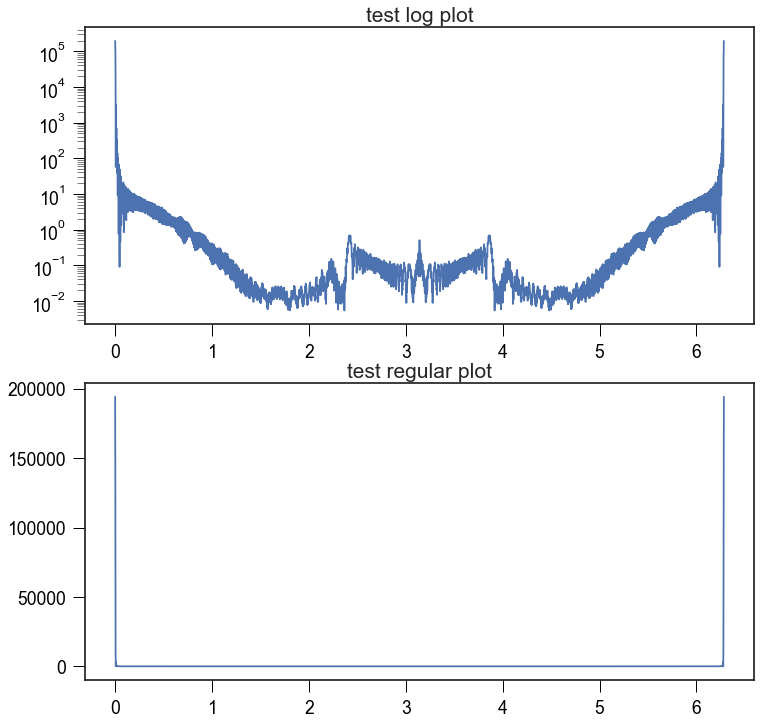

In [28]:
#why we get this strange plot?
# debug:
P_test = phase_func_natural_d[15,:,0].T
# P_test = phase_func_natural_d[idx_d,:,0]

print('shape of P_test is {}'.format(P_test.shape))
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
axs[0].semilogy(ang, P_test)
axs[0].grid(False)
# plt.ylim([0,500])
axs[0].set_title('test log plot')

axs[1].plot(ang, P_test)
axs[1].grid(False)
# plt.ylim([0,500])
axs[1].set_title('test regular plot')

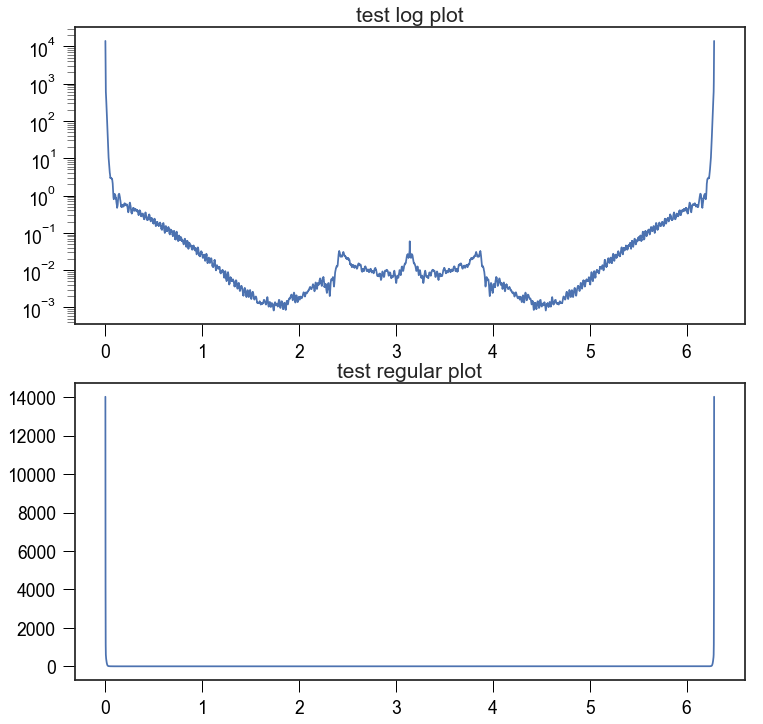

In [30]:

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
axs[0].semilogy(ang, Phase_Total)
axs[0].grid(False)
# plt.ylim([0,500])
axs[0].set_title('test log plot')

axs[1].plot(ang, Phase_Total)
axs[1].grid(False)
# plt.ylim([0,500])
axs[1].set_title('test regular plot')

test Eshkols mean PDF case

the total scatterin cross section is 2.3348916983014033e-09
the beta in this example is 0.1509290338023915
sanity check: integral of the Phase function over sphere 0.9997502529347955
estimated g = 0.8735954509636371


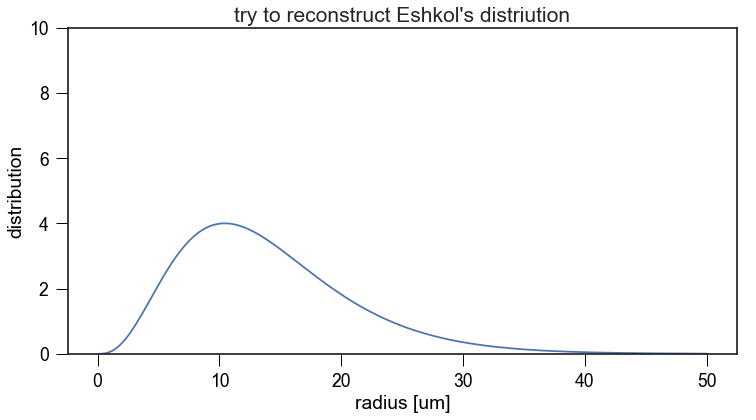

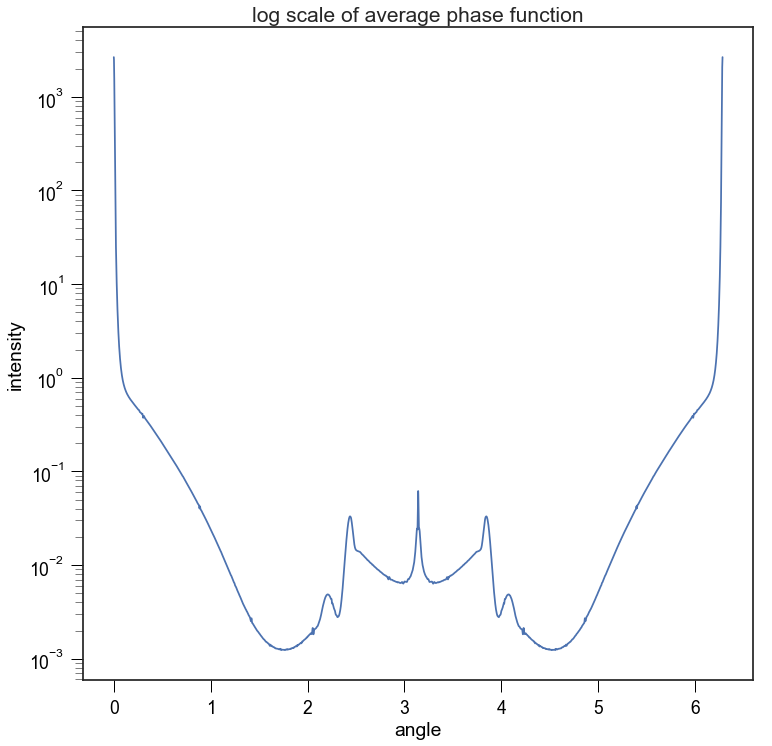

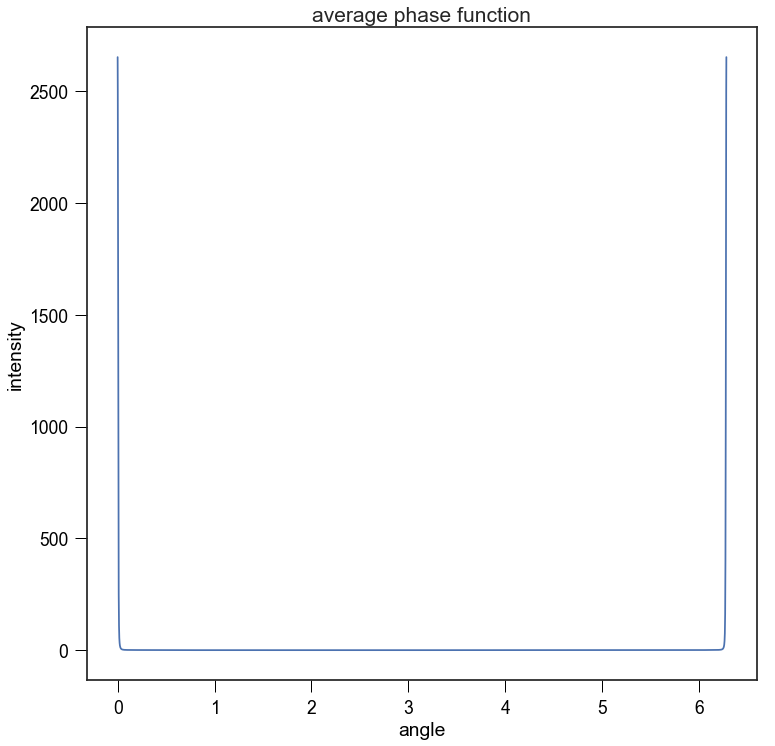

In [140]:
alpha_esh = 2.9659
b_esh = 0.28407
c_esh = 64.6407

n_d_esh = gamma_dist(1e6*diameters,alpha_esh,b_esh,Constant = 1)
n_d_esh = 4*(n_d_esh/n_d_esh.max())
plt.plot(diameters*0.5e6,n_d_esh)
plt.xlabel('radius [um]')
plt.ylabel('distribution')
plt.ylim([0 ,10])
plt.title('try to reconstruct Eshkol\'s distriution')

# calculate the phase function for this distribution
for idw,w in enumerate(wavelengths):
    scatt_cross_vector_esh = scattering_crosssection_d[:,idw]*n_d
    I1_esh = np.trapz(scatt_cross_vector_esh, x = diameters, axis=0)
    I2_esh = np.trapz(n_d, x = diameters, axis=0)
    scatt_cross_section_effective_esh = I1_esh/I2_esh
    print('the total scatterin cross section is {}'.format(scatt_cross_section_effective_esh))

    beta_example_esh = 1e6*c_esh*scatt_cross_section_effective_esh
    print('the beta in this example is {}'.format(beta_example_esh))
    
    p_esh = phase_func_natural_d[:,:,idw] # p.shape = (31,3997,) , scatt_cross_vector.shape = 31
    trp_toint_esh = p_esh.T*scatt_cross_vector_esh
    trp_int_esh = np.trapz(trp_toint_esh,diameters,axis=1) 
    trp_normalization_esh = 2*np.pi*np.trapz(trp_int_esh[ang < np.pi]*np.sin(theta),theta,axis=0) 

    Phase_Total_esh = trp_int_esh/trp_normalization_esh
    v_natural = Phase_Total_esh[ang < np.pi] # to ensure integration from 0 to pi

    h = (v_natural*np.sin(theta))*(2*np.pi/cor_ang_num)
    print("sanity check: integral of the Phase function over sphere {}".format(2*np.pi*h.sum()) )

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
axs.semilogy(ang, Phase_Total_esh)
axs.grid(False)
plt.xlabel('angle')
plt.ylabel('intensity')
axs.set_title('log scale of average phase function')

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
axs.plot(ang, Phase_Total_esh)
axs.grid(False)
plt.xlabel('angle')
plt.ylabel('intensity')
axs.set_title('average phase function')

# calculate g:
ge = np.trapz(v_natural*np.cos(theta)*2*np.pi*np.sin(theta),theta)
print('estimated g = {}'.format(ge))

Plot the cross sections as a function of particles diameter

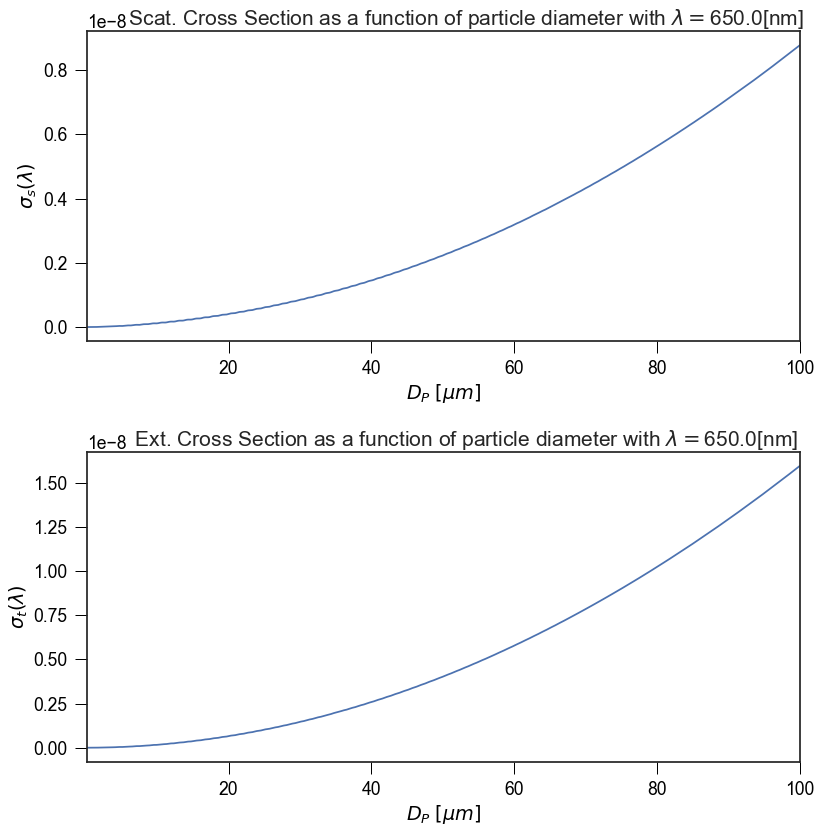

In [39]:
f,a = plt.subplots(nrows=2, ncols=1, sharey=False, figsize=(12, 12))
a[0].plot(diameters*1e6, scattering_crosssection_d[:,0])
a[0].set_ylabel("$\sigma_{s}(\lambda)$")
a[0].set_xlabel("$D_P\;[\mu m]$")
a[0].set_xlim(low_d, high_d)
a[0].set_title("\tScat. Cross Section as a function of particle diameter with $\lambda = ${}[nm]".format(1e9*wavelengths[0])) 

a[1].plot(diameters*1e6, extinction_crosssection_d[:,0])
a[1].set_ylabel("$\sigma_{t}(\lambda)$")
a[1].set_xlabel("$D_P\;[\mu m]$")
a[1].set_xlim(low_d, high_d)
a[1].set_title("\tExt. Cross Section as a function of particle diameter with $\lambda = ${}[nm]".format(1e9*wavelengths[0]))



f.tight_layout()

Plot one example of phase function __per__ diameter 

natural Normaliezed integral 0.9997270786340774


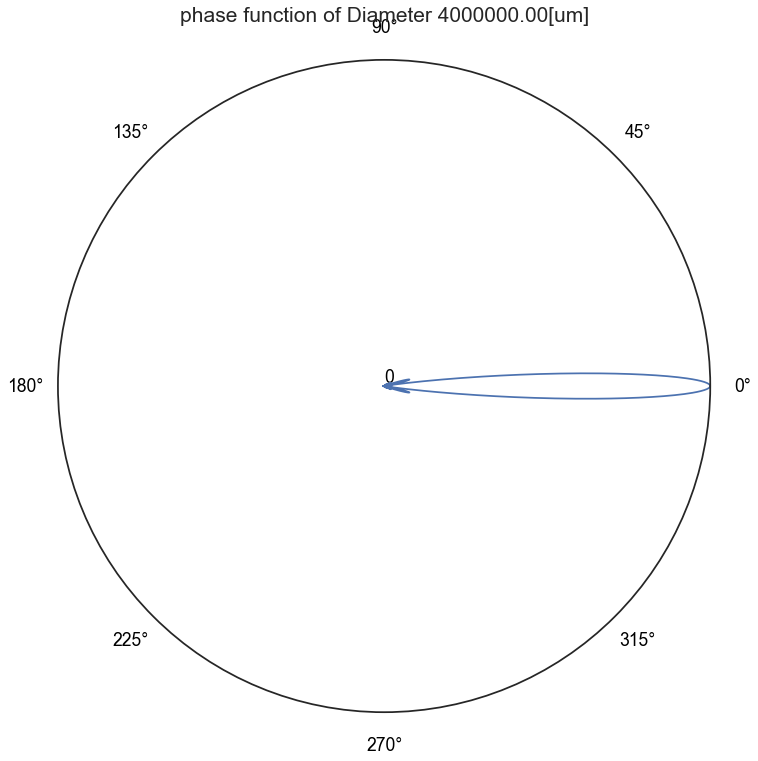

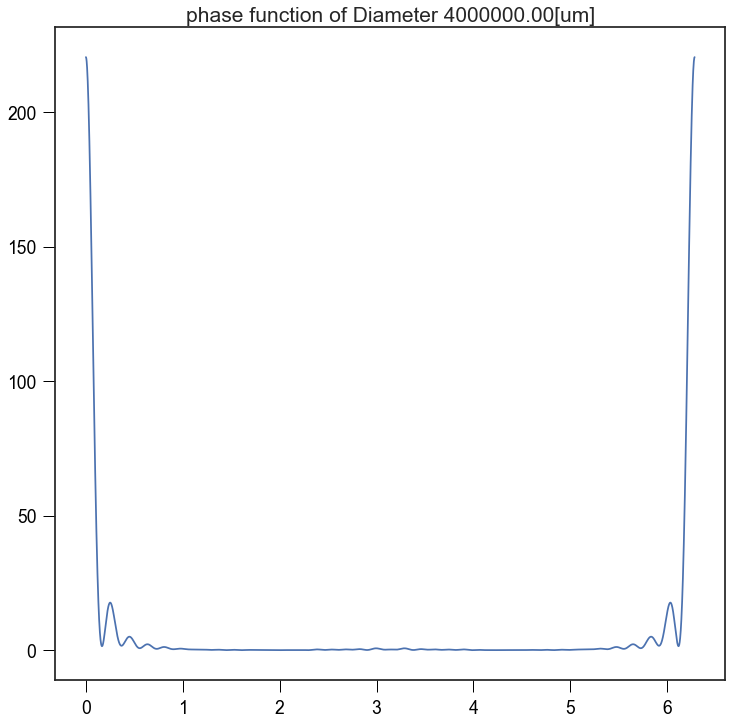

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection='polar'), figsize=(12, 12))
idx_d = 0

Pnatural = phase_func_natural_d[idx_d,:,0]
v_natural = Pnatural[ang < np.pi] # to ensure integration from 0 to pi
theta = ang[ang < np.pi]

h = (v_natural*np.sin(theta))*(2*np.pi/cor_ang_num)
print("natural Normaliezed integral {}".format(0.5*h.sum()) )

axs.plot(ang, Pnatural)
axs.grid(False)
axs.set_rmax(Pnatural.max())
axs.set_title('phase function of Diameter {:10.2f}[um]'.format(diameters[idx_d]*1e6))
axs.set_rticks([0])

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
axs.plot(ang, Pnatural)
axs.grid(False)
axs.set_title('phase function of Diameter {:10.2f}[um]'.format(diameters[idx_d]*1e6))


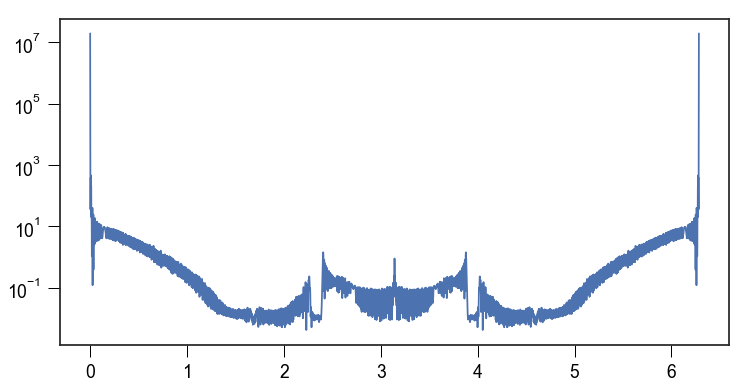

In [242]:
phase_func_natural_d1 = np.zeros([diameters.size,cor_ang_num,len(wavelengths)])
phase_func_natural_d2 = np.zeros([diameters.size,cor_ang_num,len(wavelengths)])
for indx,d in enumerate(diameters):
    #input
    mc.parameters.diameter = d
    mc.parameters.wavelength = wavelengths[0]
    mc.parameters.refractive_index = refractive_index[indx]
    #output
    extinction_crosssection_d[indx,0] = mc.extinction_crosssection
    phase_func_natural_d1[indx,:,0] = mc.phase_func.natural.values
    
plt.figure()
plt.semilogy(ang,phase_func_natural_d1[25,:,0])
plt.xlabel('angle [rad]')
plt.ylabel('phase intensity [1/st]')
plt.title('Phase function example')

for indx,d in enumerate(diameters):
    #input
    mc.parameters.diameter = d*1e-6
    mc.parameters.wavelength = wavelengths[0]*1e-6
    mc.parameters.refractive_index = refractive_index[indx]
    #output
    extinction_crosssection_d[indx,0] = mc.extinction_crosssection
    phase_func_natural_d2[indx,:,0] = mc.phase_func.natural.values

plt.figure()
plt.semilogy(ang,phase_func_natural_d2[25,:,0])
plt.xlabel('angle [rad]')
plt.ylabel('phase intensity [1/st]')
plt.title('Phase function example')

In [34]:
"""beta_s = 0.0850[m^-1] = 0.00085[cm^-1] = 85.04[km^-1]
sigma_s = 1.315e-09[m^2] = 1.315e-5[cm^2]"""

'beta_s = 0.0850[m^-1] = 0.00085[cm^-1] = 85.04[km^-1]\nsigma_s = 1.315e-09[m^2] = 1.315e-5[cm^2]'

# Validate Mie function - Compare Mie and Rayiligh functions in x=0.2 (particle number)

sanity check: integral of the Mie Phase function over sphere 0.9997495033686418
sanity check: integral of the Ray. Phase function over sphere 0.9997495033936229


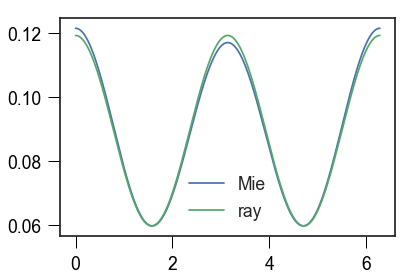

In [43]:
wl = 0.650
cor_ang_num = 3997
t = np.linspace(0,2*np.pi,cor_ang_num)
mc = mie_py.Bohren_Huffman()
mc.parameters.wavelength = wl
mc.parameters.diameter = (wl*0.2)/np.pi
Pmie = mc.phase_func.natural.values/(4*np.pi)

plt.figure()
plt.plot(t,Pmie,label='Mie')
mu = np.cos(t)
P_ray = (3/(16*np.pi))*(1+mu*mu)
plt.plot(t,P_ray,label='ray')

theta = t[t < np.pi]
vmie = Pmie[t < np.pi] # to ensure integration from 0 to pi
vray = P_ray[t < np.pi] # to ensure integration from 0 to pi
h = (vmie*np.sin(theta))*(2*np.pi/cor_ang_num)
print("sanity check: integral of the Mie Phase function over sphere {}".format(2*np.pi*h.sum()) )

h = (vray*np.sin(theta))*(2*np.pi/cor_ang_num)
print("sanity check: integral of the Ray. Phase function over sphere {}".format(2*np.pi*h.sum()) )

plt.legend()